# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4449685835402337 -2.338701400356254
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [16]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [17]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [18]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [19]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [20]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [21]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [24]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [27]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 gloss:0.0271 dloss:1.4051 dlossR:0.7124 dlossQ:0.6928
Episode:1 meanR:13.0000 gloss:-0.0154 dloss:1.3741 dlossR:0.6811 dlossQ:0.6931
Episode:2 meanR:12.0000 gloss:-0.0673 dloss:1.3333 dlossR:0.6421 dlossQ:0.6912
Episode:3 meanR:11.5000 gloss:-0.1252 dloss:1.2911 dlossR:0.6044 dlossQ:0.6867
Episode:4 meanR:12.2000 gloss:-0.1400 dloss:1.2833 dlossR:0.5999 dlossQ:0.6835
Episode:5 meanR:18.1667 gloss:-0.0941 dloss:1.3291 dlossR:0.6418 dlossQ:0.6874
Episode:6 meanR:23.7143 gloss:-0.0946 dloss:1.3331 dlossR:0.6426 dlossQ:0.6905
Episode:7 meanR:26.3750 gloss:-0.0562 dloss:1.3520 dlossR:0.6594 dlossQ:0.6926
Episode:8 meanR:26.0000 gloss:-0.0649 dloss:1.3414 dlossR:0.6492 dlossQ:0.6923
Episode:9 meanR:25.3000 gloss:-0.0632 dloss:1.3405 dlossR:0.6482 dlossQ:0.6922
Episode:10 meanR:25.0909 gloss:-0.0849 dloss:1.3273 dlossR:0.6360 dlossQ:0.6913
Episode:11 meanR:24.8333 gloss:-0.0923 dloss:1.3220 dlossR:0.6310 dlossQ:0.6910
Episode:12 meanR:24.0769 gloss:-0.1059 dloss:1.3094

Episode:103 meanR:36.9700 gloss:-1.4585 dloss:1.0960 dlossR:0.7529 dlossQ:0.3431
Episode:104 meanR:41.8200 gloss:-1.3569 dloss:2.4712 dlossR:2.0984 dlossQ:0.3728
Episode:105 meanR:43.4400 gloss:-1.2960 dloss:1.3268 dlossR:0.9330 dlossQ:0.3938
Episode:106 meanR:44.1100 gloss:-1.3665 dloss:0.9980 dlossR:0.6242 dlossQ:0.3739
Episode:107 meanR:44.2800 gloss:-1.4167 dloss:0.7400 dlossR:0.3799 dlossQ:0.3602
Episode:108 meanR:44.8100 gloss:-1.3825 dloss:0.8064 dlossR:0.4361 dlossQ:0.3703
Episode:109 meanR:45.4300 gloss:-1.4383 dloss:0.8149 dlossR:0.4606 dlossQ:0.3543
Episode:110 meanR:45.9900 gloss:-1.3612 dloss:0.8219 dlossR:0.4464 dlossQ:0.3755
Episode:111 meanR:46.5200 gloss:-1.3465 dloss:0.8108 dlossR:0.4306 dlossQ:0.3802
Episode:112 meanR:47.0100 gloss:-1.4072 dloss:0.7465 dlossR:0.3864 dlossQ:0.3601
Episode:113 meanR:47.4100 gloss:-1.4145 dloss:0.7081 dlossR:0.3499 dlossQ:0.3583
Episode:114 meanR:47.5700 gloss:-1.2341 dloss:0.6633 dlossR:0.2497 dlossQ:0.4136
Episode:115 meanR:47.6600 gl

Episode:208 meanR:49.1000 gloss:-1.2740 dloss:0.6894 dlossR:0.2863 dlossQ:0.4031
Episode:209 meanR:51.1800 gloss:-1.3142 dloss:1.6260 dlossR:1.2390 dlossQ:0.3870
Episode:210 meanR:50.9900 gloss:-1.3447 dloss:0.7486 dlossR:0.3696 dlossQ:0.3790
Episode:211 meanR:50.8400 gloss:-1.2999 dloss:0.7630 dlossR:0.3702 dlossQ:0.3928
Episode:212 meanR:50.8300 gloss:-1.2352 dloss:0.7958 dlossR:0.3829 dlossQ:0.4129
Episode:213 meanR:50.8000 gloss:-1.2298 dloss:0.7579 dlossR:0.3434 dlossQ:0.4145
Episode:214 meanR:51.4300 gloss:-2.0215 dloss:0.8872 dlossR:0.6171 dlossQ:0.2701
Episode:215 meanR:51.6000 gloss:-1.1932 dloss:0.7185 dlossR:0.2922 dlossQ:0.4263
Episode:216 meanR:51.6500 gloss:-1.2352 dloss:0.6572 dlossR:0.2426 dlossQ:0.4146
Episode:217 meanR:51.7400 gloss:-1.2048 dloss:0.6870 dlossR:0.2634 dlossQ:0.4236
Episode:218 meanR:51.8600 gloss:-1.2701 dloss:0.6324 dlossR:0.2299 dlossQ:0.4025
Episode:219 meanR:51.9000 gloss:-1.3123 dloss:0.6030 dlossR:0.2136 dlossQ:0.3894
Episode:220 meanR:51.9100 gl

Episode:317 meanR:60.0800 gloss:-1.6091 dloss:0.4873 dlossR:0.1812 dlossQ:0.3062
Episode:318 meanR:59.9800 gloss:-1.7248 dloss:0.4228 dlossR:0.1465 dlossQ:0.2762
Episode:319 meanR:59.9300 gloss:-1.8526 dloss:0.3928 dlossR:0.1482 dlossQ:0.2446
Episode:320 meanR:59.9500 gloss:-1.8243 dloss:0.4181 dlossR:0.1620 dlossQ:0.2561
Episode:321 meanR:59.8500 gloss:-2.0556 dloss:0.3287 dlossR:0.1249 dlossQ:0.2038
Episode:322 meanR:59.9100 gloss:-1.6592 dloss:0.4989 dlossR:0.1952 dlossQ:0.3037
Episode:323 meanR:60.2700 gloss:-1.4757 dloss:0.6653 dlossR:0.3211 dlossQ:0.3442
Episode:324 meanR:60.4100 gloss:-1.5660 dloss:0.5459 dlossR:0.2239 dlossQ:0.3220
Episode:325 meanR:60.5400 gloss:-1.6149 dloss:0.5721 dlossR:0.2632 dlossQ:0.3089
Episode:326 meanR:61.9200 gloss:-1.4259 dloss:1.1117 dlossR:0.7547 dlossQ:0.3569
Episode:327 meanR:62.4000 gloss:-1.5288 dloss:0.7037 dlossR:0.3761 dlossQ:0.3276
Episode:328 meanR:62.4300 gloss:-1.5162 dloss:0.6027 dlossR:0.2712 dlossQ:0.3315
Episode:329 meanR:62.5400 gl

Episode:426 meanR:61.1300 gloss:-1.4151 dloss:0.5817 dlossR:0.2166 dlossQ:0.3651
Episode:427 meanR:60.8500 gloss:-1.2327 dloss:0.6961 dlossR:0.2762 dlossQ:0.4199
Episode:428 meanR:61.2000 gloss:-1.2006 dloss:0.8458 dlossR:0.4172 dlossQ:0.4287
Episode:429 meanR:65.4200 gloss:-1.2195 dloss:2.2122 dlossR:1.7920 dlossQ:0.4202
Episode:430 meanR:65.6200 gloss:-1.1847 dloss:0.7580 dlossR:0.3281 dlossQ:0.4299
Episode:431 meanR:65.3600 gloss:-1.1724 dloss:0.6888 dlossR:0.2552 dlossQ:0.4336
Episode:432 meanR:65.4400 gloss:-1.1775 dloss:0.7161 dlossR:0.2845 dlossQ:0.4316
Episode:433 meanR:65.3400 gloss:-1.2312 dloss:0.6400 dlossR:0.2253 dlossQ:0.4147
Episode:434 meanR:65.2300 gloss:-1.2261 dloss:0.6394 dlossR:0.2228 dlossQ:0.4166
Episode:435 meanR:65.2800 gloss:-1.2222 dloss:0.6583 dlossR:0.2407 dlossQ:0.4175
Episode:436 meanR:65.2100 gloss:-1.2487 dloss:0.6367 dlossR:0.2270 dlossQ:0.4097
Episode:437 meanR:65.1900 gloss:-1.2914 dloss:0.6094 dlossR:0.2135 dlossQ:0.3959
Episode:438 meanR:65.1900 gl

Episode:535 meanR:55.0800 gloss:-1.5385 dloss:0.5260 dlossR:0.1996 dlossQ:0.3264
Episode:536 meanR:55.1100 gloss:-1.6245 dloss:0.5071 dlossR:0.2036 dlossQ:0.3035
Episode:537 meanR:55.1400 gloss:-1.6528 dloss:0.4889 dlossR:0.1929 dlossQ:0.2960
Episode:538 meanR:55.0800 gloss:-1.7348 dloss:0.4599 dlossR:0.1840 dlossQ:0.2760
Episode:539 meanR:55.0800 gloss:-1.8030 dloss:0.4315 dlossR:0.1716 dlossQ:0.2599
Episode:540 meanR:54.9800 gloss:-1.9449 dloss:0.3717 dlossR:0.1445 dlossQ:0.2272
Episode:541 meanR:54.8100 gloss:-2.2790 dloss:0.2859 dlossR:0.1193 dlossQ:0.1666
Episode:542 meanR:54.7800 gloss:-2.2637 dloss:0.2856 dlossR:0.1143 dlossQ:0.1713
Episode:543 meanR:54.7600 gloss:-2.3457 dloss:0.2804 dlossR:0.1199 dlossQ:0.1605
Episode:544 meanR:55.8900 gloss:-1.7256 dloss:0.9909 dlossR:0.7113 dlossQ:0.2796
Episode:545 meanR:55.7200 gloss:-1.9838 dloss:0.3809 dlossR:0.1622 dlossQ:0.2187
Episode:546 meanR:55.2800 gloss:-2.2892 dloss:0.2930 dlossR:0.1287 dlossQ:0.1642
Episode:547 meanR:55.2600 gl

Episode:639 meanR:72.9200 gloss:-1.0114 dloss:0.9098 dlossR:0.4210 dlossQ:0.4888
Episode:640 meanR:73.3200 gloss:-1.0597 dloss:0.8486 dlossR:0.3758 dlossQ:0.4728
Episode:641 meanR:77.2800 gloss:-0.7876 dloss:1.7643 dlossR:1.2079 dlossQ:0.5564
Episode:642 meanR:82.1800 gloss:-0.7106 dloss:1.9137 dlossR:1.3333 dlossQ:0.5804
Episode:643 meanR:82.9500 gloss:-0.9297 dloss:0.9917 dlossR:0.4791 dlossQ:0.5126
Episode:644 meanR:82.1300 gloss:-0.8919 dloss:0.8942 dlossR:0.3677 dlossQ:0.5265
Episode:645 meanR:83.2000 gloss:-0.9279 dloss:1.1025 dlossR:0.5856 dlossQ:0.5169
Episode:646 meanR:84.6400 gloss:-0.7194 dloss:1.2113 dlossR:0.6338 dlossQ:0.5775
Episode:647 meanR:85.0300 gloss:-0.8322 dloss:0.9354 dlossR:0.3921 dlossQ:0.5433
Episode:648 meanR:84.9700 gloss:-1.4408 dloss:0.5608 dlossR:0.2010 dlossQ:0.3598
Episode:649 meanR:85.6700 gloss:-0.8197 dloss:1.0378 dlossR:0.4903 dlossQ:0.5475
Episode:650 meanR:86.0800 gloss:-0.8133 dloss:1.0176 dlossR:0.4673 dlossQ:0.5503
Episode:651 meanR:85.9900 gl

Episode:740 meanR:130.7000 gloss:-0.1796 dloss:1.5245 dlossR:0.8528 dlossQ:0.6718
Episode:741 meanR:127.9800 gloss:-0.6169 dloss:1.1962 dlossR:0.5929 dlossQ:0.6033
Episode:742 meanR:123.2800 gloss:-0.7933 dloss:0.9096 dlossR:0.3560 dlossQ:0.5535
Episode:743 meanR:122.6500 gloss:-0.6289 dloss:0.9926 dlossR:0.3919 dlossQ:0.6006
Episode:744 meanR:122.3900 gloss:-0.6247 dloss:0.9834 dlossR:0.3794 dlossQ:0.6040
Episode:745 meanR:121.3600 gloss:-0.6410 dloss:0.9782 dlossR:0.3784 dlossQ:0.5998
Episode:746 meanR:119.9500 gloss:-0.7943 dloss:0.8770 dlossR:0.3206 dlossQ:0.5564
Episode:747 meanR:119.6000 gloss:-0.9269 dloss:0.7946 dlossR:0.2791 dlossQ:0.5155
Episode:748 meanR:119.7000 gloss:-0.6665 dloss:0.9653 dlossR:0.3704 dlossQ:0.5950
Episode:749 meanR:118.9600 gloss:-0.9566 dloss:0.7890 dlossR:0.2811 dlossQ:0.5079
Episode:750 meanR:118.3700 gloss:-0.8639 dloss:0.8485 dlossR:0.3094 dlossQ:0.5391
Episode:751 meanR:118.3100 gloss:-0.9203 dloss:0.8362 dlossR:0.3174 dlossQ:0.5188
Episode:752 mean

Episode:843 meanR:127.4000 gloss:-1.2579 dloss:0.7864 dlossR:0.3751 dlossQ:0.4114
Episode:844 meanR:132.2200 gloss:-1.1704 dloss:2.2942 dlossR:1.8591 dlossQ:0.4351
Episode:845 meanR:137.0000 gloss:-0.5137 dloss:1.7685 dlossR:1.1452 dlossQ:0.6234
Episode:846 meanR:141.5800 gloss:-0.6852 dloss:1.8631 dlossR:1.2955 dlossQ:0.5677
Episode:847 meanR:144.0100 gloss:-0.4853 dloss:1.4159 dlossR:0.8007 dlossQ:0.6152
Episode:848 meanR:144.7200 gloss:-0.9400 dloss:1.0054 dlossR:0.5028 dlossQ:0.5027
Episode:849 meanR:145.2000 gloss:-1.2532 dloss:0.8031 dlossR:0.3931 dlossQ:0.4100
Episode:850 meanR:145.5200 gloss:-0.9515 dloss:0.8777 dlossR:0.3729 dlossQ:0.5049
Episode:851 meanR:145.6500 gloss:-1.2843 dloss:0.6980 dlossR:0.2966 dlossQ:0.4015
Episode:852 meanR:145.5100 gloss:-1.3835 dloss:0.6334 dlossR:0.2622 dlossQ:0.3712
Episode:853 meanR:145.2500 gloss:-1.4064 dloss:0.5939 dlossR:0.2291 dlossQ:0.3648
Episode:854 meanR:145.2600 gloss:-1.4416 dloss:0.5741 dlossR:0.2189 dlossQ:0.3552
Episode:855 mean

Episode:944 meanR:142.3000 gloss:-0.0930 dloss:1.4568 dlossR:0.7772 dlossQ:0.6796
Episode:945 meanR:142.3000 gloss:0.0405 dloss:1.3605 dlossR:0.6803 dlossQ:0.6803
Episode:946 meanR:138.7000 gloss:-0.7102 dloss:1.1277 dlossR:0.5511 dlossQ:0.5766
Episode:947 meanR:137.7400 gloss:-0.6571 dloss:1.2355 dlossR:0.6444 dlossQ:0.5911
Episode:948 meanR:137.5900 gloss:-0.7778 dloss:1.0339 dlossR:0.4778 dlossQ:0.5562
Episode:949 meanR:138.4000 gloss:-0.6168 dloss:1.2175 dlossR:0.6180 dlossQ:0.5996
Episode:950 meanR:139.4200 gloss:-0.5119 dloss:1.2566 dlossR:0.6316 dlossQ:0.6250
Episode:951 meanR:140.5900 gloss:-0.6046 dloss:1.2371 dlossR:0.6343 dlossQ:0.6028
Episode:952 meanR:141.7500 gloss:-0.5818 dloss:1.2305 dlossR:0.6215 dlossQ:0.6091
Episode:953 meanR:145.2600 gloss:0.2079 dloss:1.3138 dlossR:0.6430 dlossQ:0.6708
Episode:954 meanR:146.9100 gloss:-0.5809 dloss:1.2953 dlossR:0.6868 dlossQ:0.6086
Episode:955 meanR:149.4400 gloss:0.2363 dloss:1.3666 dlossR:0.6985 dlossQ:0.6681
Episode:956 meanR:1

Episode:1044 meanR:115.6600 gloss:-0.9234 dloss:0.8117 dlossR:0.2937 dlossQ:0.5181
Episode:1045 meanR:110.8000 gloss:-0.9598 dloss:0.7803 dlossR:0.2742 dlossQ:0.5061
Episode:1046 meanR:109.7800 gloss:-1.0634 dloss:0.7195 dlossR:0.2468 dlossQ:0.4727
Episode:1047 meanR:108.4200 gloss:-0.7203 dloss:0.9424 dlossR:0.3667 dlossQ:0.5756
Episode:1048 meanR:107.8900 gloss:-0.6746 dloss:0.9722 dlossR:0.3827 dlossQ:0.5896
Episode:1049 meanR:106.6400 gloss:-0.6915 dloss:0.9577 dlossR:0.3725 dlossQ:0.5852
Episode:1050 meanR:105.3500 gloss:-0.8417 dloss:0.8725 dlossR:0.3274 dlossQ:0.5451
Episode:1051 meanR:104.4400 gloss:-0.8992 dloss:0.9457 dlossR:0.4249 dlossQ:0.5208
Episode:1052 meanR:103.7800 gloss:-0.9344 dloss:0.9814 dlossR:0.4722 dlossQ:0.5092
Episode:1053 meanR:100.9500 gloss:-1.0577 dloss:0.9787 dlossR:0.5054 dlossQ:0.4734
Episode:1054 meanR:99.7500 gloss:-1.0547 dloss:0.9032 dlossR:0.4253 dlossQ:0.4779
Episode:1055 meanR:97.6100 gloss:-0.8743 dloss:0.9659 dlossR:0.4373 dlossQ:0.5286
Episod

Episode:1147 meanR:179.4800 gloss:-0.5958 dloss:1.0054 dlossR:0.3994 dlossQ:0.6059
Episode:1148 meanR:179.3400 gloss:-0.7349 dloss:0.9187 dlossR:0.3517 dlossQ:0.5670
Episode:1149 meanR:179.3400 gloss:-0.4480 dloss:1.1116 dlossR:0.4804 dlossQ:0.6312
Episode:1150 meanR:179.8500 gloss:-0.5794 dloss:1.1223 dlossR:0.5172 dlossQ:0.6051
Episode:1151 meanR:184.1900 gloss:-0.2260 dloss:1.5546 dlossR:0.8715 dlossQ:0.6831
Episode:1152 meanR:188.3600 gloss:-0.0790 dloss:1.4465 dlossR:0.7573 dlossQ:0.6892
Episode:1153 meanR:192.4300 gloss:0.0050 dloss:1.3843 dlossR:0.6945 dlossQ:0.6898
Episode:1154 meanR:196.7500 gloss:0.1105 dloss:1.3076 dlossR:0.6204 dlossQ:0.6872
Episode:1155 meanR:201.0500 gloss:0.1298 dloss:1.2939 dlossR:0.6091 dlossQ:0.6848
Episode:1156 meanR:205.3000 gloss:0.2375 dloss:1.2403 dlossR:0.5801 dlossQ:0.6603
Episode:1157 meanR:208.1700 gloss:0.2580 dloss:1.3319 dlossR:0.6690 dlossQ:0.6629
Episode:1158 meanR:210.4900 gloss:0.1809 dloss:1.3845 dlossR:0.7189 dlossQ:0.6656
Episode:11

Episode:1247 meanR:130.4100 gloss:-1.6306 dloss:0.5350 dlossR:0.2044 dlossQ:0.3306
Episode:1248 meanR:133.9000 gloss:-0.1252 dloss:1.4333 dlossR:0.7581 dlossQ:0.6752
Episode:1249 meanR:136.5900 gloss:-0.9142 dloss:1.5517 dlossR:1.0262 dlossQ:0.5255
Episode:1250 meanR:137.5900 gloss:-0.9244 dloss:1.2312 dlossR:0.7142 dlossQ:0.5170
Episode:1251 meanR:133.5300 gloss:-0.9281 dloss:1.0160 dlossR:0.5016 dlossQ:0.5144
Episode:1252 meanR:129.1800 gloss:-1.0712 dloss:0.8767 dlossR:0.4057 dlossQ:0.4710
Episode:1253 meanR:124.8500 gloss:-1.0288 dloss:0.9036 dlossR:0.4209 dlossQ:0.4826
Episode:1254 meanR:119.9700 gloss:-1.5866 dloss:0.5256 dlossR:0.1953 dlossQ:0.3303
Episode:1255 meanR:115.0600 gloss:-1.9249 dloss:0.4478 dlossR:0.1778 dlossQ:0.2700
Episode:1256 meanR:111.0800 gloss:-1.1086 dloss:0.8893 dlossR:0.4310 dlossQ:0.4584
Episode:1257 meanR:108.7100 gloss:-0.9683 dloss:0.9833 dlossR:0.4805 dlossQ:0.5028
Episode:1258 meanR:107.6300 gloss:-0.9464 dloss:1.1579 dlossR:0.6505 dlossQ:0.5074
Epis

Episode:1346 meanR:151.5300 gloss:-0.9278 dloss:1.5017 dlossR:0.9749 dlossQ:0.5268
Episode:1347 meanR:153.6400 gloss:-0.9452 dloss:1.3868 dlossR:0.8667 dlossQ:0.5201
Episode:1348 meanR:154.9200 gloss:-0.2904 dloss:1.6060 dlossR:0.9688 dlossQ:0.6372
Episode:1349 meanR:152.1600 gloss:-2.0661 dloss:0.4457 dlossR:0.1959 dlossQ:0.2498
Episode:1350 meanR:152.4600 gloss:-0.9695 dloss:1.3415 dlossR:0.8237 dlossQ:0.5178
Episode:1351 meanR:152.6600 gloss:-1.1591 dloss:1.0384 dlossR:0.5852 dlossQ:0.4532
Episode:1352 meanR:152.5700 gloss:-1.1067 dloss:0.9006 dlossR:0.4127 dlossQ:0.4880
Episode:1353 meanR:153.1100 gloss:-0.8941 dloss:1.1353 dlossR:0.5946 dlossQ:0.5407
Episode:1354 meanR:153.6000 gloss:-1.1096 dloss:0.9013 dlossR:0.4228 dlossQ:0.4785
Episode:1355 meanR:154.2400 gloss:-1.2136 dloss:0.8997 dlossR:0.4554 dlossQ:0.4443
Episode:1356 meanR:154.2000 gloss:-1.2233 dloss:0.8714 dlossR:0.4296 dlossQ:0.4419
Episode:1357 meanR:154.3500 gloss:-1.0285 dloss:1.0529 dlossR:0.5545 dlossQ:0.4984
Epis

Episode:1446 meanR:230.8600 gloss:-0.3825 dloss:1.6379 dlossR:0.9913 dlossQ:0.6466
Episode:1447 meanR:231.8200 gloss:-0.4055 dloss:1.4810 dlossR:0.8385 dlossQ:0.6425
Episode:1448 meanR:230.0000 gloss:-0.4156 dloss:1.4637 dlossR:0.8232 dlossQ:0.6405
Episode:1449 meanR:232.3700 gloss:-0.3899 dloss:1.3979 dlossR:0.7533 dlossQ:0.6446
Episode:1450 meanR:235.1000 gloss:-0.3587 dloss:1.6384 dlossR:0.9934 dlossQ:0.6450
Episode:1451 meanR:236.9600 gloss:-0.2976 dloss:1.4346 dlossR:0.7723 dlossQ:0.6623
Episode:1452 meanR:239.2400 gloss:-0.2711 dloss:1.4174 dlossR:0.7478 dlossQ:0.6697
Episode:1453 meanR:243.0300 gloss:-0.1765 dloss:1.5163 dlossR:0.8356 dlossQ:0.6807
Episode:1454 meanR:245.6400 gloss:-0.2792 dloss:1.4509 dlossR:0.7902 dlossQ:0.6607
Episode:1455 meanR:249.9100 gloss:-0.0870 dloss:1.4504 dlossR:0.7596 dlossQ:0.6908
Episode:1456 meanR:254.2600 gloss:-0.1345 dloss:1.4852 dlossR:0.7990 dlossQ:0.6863
Episode:1457 meanR:258.2200 gloss:-0.1067 dloss:1.4648 dlossR:0.7752 dlossQ:0.6895
Epis

Episode:1547 meanR:204.8500 gloss:-0.6082 dloss:1.1813 dlossR:0.5815 dlossQ:0.5998
Episode:1548 meanR:202.5000 gloss:-0.7502 dloss:1.0308 dlossR:0.4691 dlossQ:0.5617
Episode:1549 meanR:200.4000 gloss:-0.9541 dloss:0.8682 dlossR:0.3643 dlossQ:0.5038
Episode:1550 meanR:196.0000 gloss:-1.0101 dloss:0.8331 dlossR:0.3441 dlossQ:0.4890
Episode:1551 meanR:193.3400 gloss:-1.0849 dloss:0.7846 dlossR:0.3188 dlossQ:0.4658
Episode:1552 meanR:190.8100 gloss:-1.0488 dloss:0.7964 dlossR:0.3167 dlossQ:0.4797
Episode:1553 meanR:185.9300 gloss:-1.3831 dloss:0.6005 dlossR:0.2118 dlossQ:0.3888
Episode:1554 meanR:182.9800 gloss:-1.0905 dloss:0.7742 dlossR:0.3005 dlossQ:0.4737
Episode:1555 meanR:178.3300 gloss:-1.0668 dloss:0.8035 dlossR:0.3274 dlossQ:0.4761
Episode:1556 meanR:173.9300 gloss:-1.0218 dloss:0.8937 dlossR:0.4050 dlossQ:0.4888
Episode:1557 meanR:171.9200 gloss:-0.8641 dloss:1.5423 dlossR:1.0101 dlossQ:0.5322
Episode:1558 meanR:168.9500 gloss:-0.9688 dloss:1.3039 dlossR:0.8029 dlossQ:0.5010
Epis

Episode:1646 meanR:197.4000 gloss:0.1936 dloss:1.3171 dlossR:0.6453 dlossQ:0.6718
Episode:1647 meanR:198.7400 gloss:0.0882 dloss:1.3856 dlossR:0.7024 dlossQ:0.6832
Episode:1648 meanR:198.1900 gloss:-0.4970 dloss:1.0805 dlossR:0.4546 dlossQ:0.6259
Episode:1649 meanR:197.9600 gloss:-0.3337 dloss:1.1823 dlossR:0.5261 dlossQ:0.6561
Episode:1650 meanR:198.8800 gloss:-0.0436 dloss:1.3731 dlossR:0.6893 dlossQ:0.6839
Episode:1651 meanR:199.0400 gloss:-0.2155 dloss:1.2668 dlossR:0.5904 dlossQ:0.6764
Episode:1652 meanR:198.9000 gloss:-0.4600 dloss:1.1043 dlossR:0.4701 dlossQ:0.6342
Episode:1653 meanR:199.2800 gloss:-0.3107 dloss:1.2133 dlossR:0.5457 dlossQ:0.6676
Episode:1654 meanR:199.1800 gloss:-0.4744 dloss:1.0959 dlossR:0.4649 dlossQ:0.6310
Episode:1655 meanR:198.9500 gloss:-0.5957 dloss:1.0212 dlossR:0.4169 dlossQ:0.6043
Episode:1656 meanR:198.4900 gloss:-0.6166 dloss:1.0108 dlossR:0.4115 dlossQ:0.5993
Episode:1657 meanR:199.3500 gloss:0.3335 dloss:1.2587 dlossR:0.6040 dlossQ:0.6547
Episode

Episode:1746 meanR:236.4100 gloss:0.1462 dloss:1.3906 dlossR:0.7045 dlossQ:0.6861
Episode:1747 meanR:236.2600 gloss:0.1476 dloss:1.3901 dlossR:0.7038 dlossQ:0.6863
Episode:1748 meanR:237.7700 gloss:0.1800 dloss:1.4295 dlossR:0.7457 dlossQ:0.6839
Episode:1749 meanR:239.7200 gloss:0.1397 dloss:1.4013 dlossR:0.7144 dlossQ:0.6869
Episode:1750 meanR:241.5000 gloss:0.1079 dloss:1.3690 dlossR:0.6804 dlossQ:0.6886
Episode:1751 meanR:242.8100 gloss:0.1482 dloss:1.4161 dlossR:0.7298 dlossQ:0.6863
Episode:1752 meanR:245.3000 gloss:0.0956 dloss:1.3826 dlossR:0.6936 dlossQ:0.6890
Episode:1753 meanR:246.9300 gloss:0.1344 dloss:1.4008 dlossR:0.7135 dlossQ:0.6873
Episode:1754 meanR:249.2200 gloss:0.1084 dloss:1.3883 dlossR:0.6993 dlossQ:0.6890
Episode:1755 meanR:250.9400 gloss:0.1312 dloss:1.4114 dlossR:0.7234 dlossQ:0.6880
Episode:1756 meanR:252.8700 gloss:0.0914 dloss:1.3981 dlossR:0.7084 dlossQ:0.6898
Episode:1757 meanR:250.8600 gloss:0.0899 dloss:1.4038 dlossR:0.7140 dlossQ:0.6899
Episode:1758 mea

Episode:1847 meanR:230.5200 gloss:-0.1214 dloss:1.3603 dlossR:0.6752 dlossQ:0.6851
Episode:1848 meanR:230.6300 gloss:-0.1163 dloss:1.3626 dlossR:0.6757 dlossQ:0.6868
Episode:1849 meanR:230.4200 gloss:-0.1343 dloss:1.3645 dlossR:0.6796 dlossQ:0.6850
Episode:1850 meanR:229.5000 gloss:-0.1264 dloss:1.3745 dlossR:0.6884 dlossQ:0.6861
Episode:1851 meanR:229.6000 gloss:-0.1212 dloss:1.3660 dlossR:0.6789 dlossQ:0.6871
Episode:1852 meanR:229.9500 gloss:-0.1234 dloss:1.4047 dlossR:0.7178 dlossQ:0.6869
Episode:1853 meanR:229.8400 gloss:-0.1298 dloss:1.3687 dlossR:0.6822 dlossQ:0.6866
Episode:1854 meanR:229.3000 gloss:-0.1327 dloss:1.3647 dlossR:0.6797 dlossQ:0.6850
Episode:1855 meanR:230.9600 gloss:-0.0298 dloss:1.3955 dlossR:0.7091 dlossQ:0.6864
Episode:1856 meanR:231.2200 gloss:-0.1205 dloss:1.3812 dlossR:0.6937 dlossQ:0.6875
Episode:1857 meanR:233.8200 gloss:-0.0255 dloss:1.4013 dlossR:0.7144 dlossQ:0.6870
Episode:1858 meanR:235.1700 gloss:-0.0839 dloss:1.4156 dlossR:0.7255 dlossQ:0.6900
Epis

Episode:1949 meanR:238.6000 gloss:-0.6316 dloss:1.0542 dlossR:0.4616 dlossQ:0.5926
Episode:1950 meanR:237.6200 gloss:-0.3874 dloss:1.2473 dlossR:0.5973 dlossQ:0.6500
Episode:1951 meanR:236.8300 gloss:-0.3968 dloss:1.2373 dlossR:0.5953 dlossQ:0.6420
Episode:1952 meanR:235.1800 gloss:-0.3484 dloss:1.2787 dlossR:0.6276 dlossQ:0.6511
Episode:1953 meanR:234.7400 gloss:-0.3447 dloss:1.3023 dlossR:0.6501 dlossQ:0.6522
Episode:1954 meanR:234.3600 gloss:-0.3378 dloss:1.3008 dlossR:0.6497 dlossQ:0.6511
Episode:1955 meanR:232.3200 gloss:-0.3423 dloss:1.2918 dlossR:0.6421 dlossQ:0.6496
Episode:1956 meanR:231.7000 gloss:-0.2011 dloss:1.3497 dlossR:0.6771 dlossQ:0.6725
Episode:1957 meanR:228.5600 gloss:-0.2668 dloss:1.3055 dlossR:0.6488 dlossQ:0.6566
Episode:1958 meanR:225.4600 gloss:-0.5032 dloss:1.1315 dlossR:0.5193 dlossQ:0.6123
Episode:1959 meanR:223.8200 gloss:-0.4472 dloss:1.1342 dlossR:0.5103 dlossQ:0.6238
Episode:1960 meanR:222.4800 gloss:-0.5557 dloss:1.0970 dlossR:0.4958 dlossQ:0.6011
Epis

Episode:2049 meanR:136.6500 gloss:-0.1464 dloss:1.3527 dlossR:0.6813 dlossQ:0.6714
Episode:2050 meanR:137.0900 gloss:-0.2587 dloss:1.3298 dlossR:0.6708 dlossQ:0.6590
Episode:2051 meanR:137.5000 gloss:-0.2755 dloss:1.3182 dlossR:0.6616 dlossQ:0.6566
Episode:2052 meanR:137.5300 gloss:-0.2023 dloss:1.3313 dlossR:0.6977 dlossQ:0.6336
Episode:2053 meanR:136.8600 gloss:-0.7412 dloss:1.0763 dlossR:0.5079 dlossQ:0.5685
Episode:2054 meanR:135.7700 gloss:-1.1871 dloss:0.7924 dlossR:0.3497 dlossQ:0.4428
Episode:2055 meanR:134.6500 gloss:-1.1700 dloss:0.7835 dlossR:0.3277 dlossQ:0.4558
Episode:2056 meanR:133.2400 gloss:-1.2687 dloss:0.7360 dlossR:0.3048 dlossQ:0.4312
Episode:2057 meanR:132.2600 gloss:-1.4321 dloss:0.6614 dlossR:0.2837 dlossQ:0.3777
Episode:2058 meanR:132.0000 gloss:-1.5387 dloss:0.6126 dlossR:0.2719 dlossQ:0.3407
Episode:2059 meanR:132.1200 gloss:-1.0887 dloss:0.8318 dlossR:0.3557 dlossQ:0.4761
Episode:2060 meanR:132.0000 gloss:-1.0779 dloss:0.8328 dlossR:0.3572 dlossQ:0.4756
Epis

Episode:2149 meanR:75.9600 gloss:-0.2314 dloss:1.4956 dlossR:0.8403 dlossQ:0.6553
Episode:2150 meanR:77.3900 gloss:-0.2798 dloss:1.4406 dlossR:0.7939 dlossQ:0.6467
Episode:2151 meanR:78.7100 gloss:-0.3237 dloss:1.4298 dlossR:0.7868 dlossQ:0.6430
Episode:2152 meanR:79.2500 gloss:-0.1954 dloss:1.3603 dlossR:0.7021 dlossQ:0.6582
Episode:2153 meanR:80.1700 gloss:-0.2382 dloss:1.3453 dlossR:0.6885 dlossQ:0.6568
Episode:2154 meanR:81.0400 gloss:-0.6889 dloss:1.1735 dlossR:0.5903 dlossQ:0.5832
Episode:2155 meanR:81.5500 gloss:-0.8929 dloss:1.0003 dlossR:0.4714 dlossQ:0.5288
Episode:2156 meanR:81.9200 gloss:-1.0926 dloss:0.8771 dlossR:0.4105 dlossQ:0.4666
Episode:2157 meanR:82.2500 gloss:-1.0409 dloss:0.8912 dlossR:0.4086 dlossQ:0.4826
Episode:2158 meanR:82.4600 gloss:-1.2188 dloss:0.7879 dlossR:0.3607 dlossQ:0.4273
Episode:2159 meanR:82.6100 gloss:-1.1506 dloss:0.8270 dlossR:0.3766 dlossQ:0.4505
Episode:2160 meanR:82.7000 gloss:-1.2172 dloss:0.7900 dlossR:0.3563 dlossQ:0.4337
Episode:2161 mea

Episode:2251 meanR:83.0200 gloss:-1.6541 dloss:0.4944 dlossR:0.1875 dlossQ:0.3069
Episode:2252 meanR:81.2200 gloss:-1.8742 dloss:0.4191 dlossR:0.1636 dlossQ:0.2555
Episode:2253 meanR:79.5900 gloss:-1.6752 dloss:0.5082 dlossR:0.2029 dlossQ:0.3052
Episode:2254 meanR:78.9200 gloss:-1.4513 dloss:0.7744 dlossR:0.4082 dlossQ:0.3662
Episode:2255 meanR:78.9900 gloss:-1.2174 dloss:0.9391 dlossR:0.5029 dlossQ:0.4362
Episode:2256 meanR:79.5000 gloss:-1.2049 dloss:1.0362 dlossR:0.5951 dlossQ:0.4411
Episode:2257 meanR:79.9300 gloss:-1.0432 dloss:1.0501 dlossR:0.5544 dlossQ:0.4958
Episode:2258 meanR:80.3500 gloss:-1.2225 dloss:0.9662 dlossR:0.5251 dlossQ:0.4412
Episode:2259 meanR:80.6900 gloss:-1.1658 dloss:0.9586 dlossR:0.5001 dlossQ:0.4584
Episode:2260 meanR:80.7900 gloss:-1.2950 dloss:0.8232 dlossR:0.3996 dlossQ:0.4235
Episode:2261 meanR:80.5700 gloss:-1.5495 dloss:0.6145 dlossR:0.2690 dlossQ:0.3455
Episode:2262 meanR:80.5800 gloss:-1.6126 dloss:0.6038 dlossR:0.2860 dlossQ:0.3178
Episode:2263 mea

Episode:2351 meanR:226.4200 gloss:0.2211 dloss:1.3715 dlossR:0.6951 dlossQ:0.6764
Episode:2352 meanR:231.2500 gloss:0.2740 dloss:1.1925 dlossR:0.5210 dlossQ:0.6715
Episode:2353 meanR:235.3400 gloss:0.2613 dloss:1.2520 dlossR:0.5800 dlossQ:0.6720
Episode:2354 meanR:239.0700 gloss:0.2836 dloss:1.2333 dlossR:0.5648 dlossQ:0.6685
Episode:2355 meanR:242.8400 gloss:0.2972 dloss:1.1992 dlossR:0.5307 dlossQ:0.6685
Episode:2356 meanR:244.8900 gloss:0.3430 dloss:1.3153 dlossR:0.6564 dlossQ:0.6589
Episode:2357 meanR:247.5100 gloss:0.3201 dloss:1.2767 dlossR:0.6146 dlossQ:0.6621
Episode:2358 meanR:250.4600 gloss:0.3100 dloss:1.2615 dlossR:0.5991 dlossQ:0.6624
Episode:2359 meanR:254.0900 gloss:0.3285 dloss:1.1958 dlossR:0.5395 dlossQ:0.6562
Episode:2360 meanR:258.2600 gloss:0.3977 dloss:1.1279 dlossR:0.4806 dlossQ:0.6474
Episode:2361 meanR:262.9400 gloss:0.4085 dloss:1.0944 dlossR:0.4518 dlossQ:0.6426
Episode:2362 meanR:264.9700 gloss:0.2760 dloss:1.3969 dlossR:0.7459 dlossQ:0.6510
Episode:2363 mea

Episode:2451 meanR:233.0900 gloss:-0.8610 dloss:1.0218 dlossR:0.5011 dlossQ:0.5208
Episode:2452 meanR:228.7500 gloss:-1.1946 dloss:0.8433 dlossR:0.4168 dlossQ:0.4265
Episode:2453 meanR:224.6400 gloss:-0.9233 dloss:0.8178 dlossR:0.3055 dlossQ:0.5123
Episode:2454 meanR:220.4900 gloss:-0.7005 dloss:0.9653 dlossR:0.3935 dlossQ:0.5718
Episode:2455 meanR:216.0200 gloss:-0.6557 dloss:0.9890 dlossR:0.4039 dlossQ:0.5851
Episode:2456 meanR:213.0100 gloss:-0.6578 dloss:0.9870 dlossR:0.4015 dlossQ:0.5856
Episode:2457 meanR:209.4600 gloss:-0.8006 dloss:0.8975 dlossR:0.3492 dlossQ:0.5483
Episode:2458 meanR:205.6600 gloss:-1.1781 dloss:0.6941 dlossR:0.2562 dlossQ:0.4379
Episode:2459 meanR:201.3200 gloss:-0.9161 dloss:0.8501 dlossR:0.3322 dlossQ:0.5179
Episode:2460 meanR:196.7600 gloss:-0.8808 dloss:0.8619 dlossR:0.3348 dlossQ:0.5271
Episode:2461 meanR:191.9400 gloss:-1.2857 dloss:0.6696 dlossR:0.2539 dlossQ:0.4156
Episode:2462 meanR:190.0800 gloss:-0.9368 dloss:0.9464 dlossR:0.4312 dlossQ:0.5152
Epis

Episode:2550 meanR:148.6000 gloss:0.1730 dloss:1.3746 dlossR:0.7288 dlossQ:0.6458
Episode:2551 meanR:150.2600 gloss:0.2601 dloss:1.4041 dlossR:0.7634 dlossQ:0.6407
Episode:2552 meanR:152.1000 gloss:0.2680 dloss:1.4067 dlossR:0.7664 dlossQ:0.6402
Episode:2553 meanR:155.0100 gloss:0.1614 dloss:1.3730 dlossR:0.7212 dlossQ:0.6518
Episode:2554 meanR:157.5300 gloss:0.2051 dloss:1.3868 dlossR:0.7389 dlossQ:0.6479
Episode:2555 meanR:162.1000 gloss:0.3081 dloss:1.2017 dlossR:0.5714 dlossQ:0.6303
Episode:2556 meanR:164.4300 gloss:0.2295 dloss:1.3989 dlossR:0.7494 dlossQ:0.6494
Episode:2557 meanR:167.7500 gloss:0.1356 dloss:1.3548 dlossR:0.6801 dlossQ:0.6747
Episode:2558 meanR:172.6400 gloss:-0.0035 dloss:1.3948 dlossR:0.7134 dlossQ:0.6814
Episode:2559 meanR:177.4500 gloss:-0.1333 dloss:1.4917 dlossR:0.8048 dlossQ:0.6869
Episode:2560 meanR:179.2100 gloss:-0.4773 dloss:1.3365 dlossR:0.7017 dlossQ:0.6348
Episode:2561 meanR:183.3900 gloss:-0.0234 dloss:1.4042 dlossR:0.7148 dlossQ:0.6893
Episode:2562

Episode:2650 meanR:269.8300 gloss:0.4558 dloss:1.4029 dlossR:0.8073 dlossQ:0.5956
Episode:2651 meanR:269.6600 gloss:0.4733 dloss:1.4348 dlossR:0.8482 dlossQ:0.5866
Episode:2652 meanR:269.9200 gloss:0.4918 dloss:1.3742 dlossR:0.7871 dlossQ:0.5871
Episode:2653 meanR:269.5200 gloss:0.5239 dloss:1.3812 dlossR:0.8017 dlossQ:0.5796
Episode:2654 meanR:270.2000 gloss:0.2996 dloss:1.3100 dlossR:0.6770 dlossQ:0.6330
Episode:2655 meanR:268.3700 gloss:0.3102 dloss:1.3501 dlossR:0.7131 dlossQ:0.6369
Episode:2656 meanR:268.3600 gloss:0.3351 dloss:1.3887 dlossR:0.7512 dlossQ:0.6375
Episode:2657 meanR:268.2300 gloss:0.3753 dloss:1.2997 dlossR:0.6777 dlossQ:0.6220
Episode:2658 meanR:266.0700 gloss:0.3240 dloss:1.3578 dlossR:0.7171 dlossQ:0.6406
Episode:2659 meanR:264.4600 gloss:0.3734 dloss:1.2874 dlossR:0.6573 dlossQ:0.6300
Episode:2660 meanR:266.5200 gloss:0.3077 dloss:1.2427 dlossR:0.5974 dlossQ:0.6453
Episode:2661 meanR:266.2300 gloss:0.3730 dloss:1.2031 dlossR:0.5676 dlossQ:0.6355
Episode:2662 mea

Episode:2749 meanR:124.1400 gloss:-1.7259 dloss:0.5662 dlossR:0.2435 dlossQ:0.3227
Episode:2750 meanR:121.9100 gloss:-1.7110 dloss:0.5764 dlossR:0.2530 dlossQ:0.3234
Episode:2751 meanR:119.8600 gloss:-1.7121 dloss:0.5754 dlossR:0.2484 dlossQ:0.3271
Episode:2752 meanR:117.5000 gloss:-1.5952 dloss:0.6450 dlossR:0.2874 dlossQ:0.3576
Episode:2753 meanR:115.1600 gloss:-1.5013 dloss:0.6691 dlossR:0.2876 dlossQ:0.3815
Episode:2754 meanR:112.3200 gloss:-1.2973 dloss:0.8268 dlossR:0.3941 dlossQ:0.4328
Episode:2755 meanR:109.9200 gloss:-1.3005 dloss:0.8090 dlossR:0.3766 dlossQ:0.4325
Episode:2756 meanR:108.1400 gloss:-1.2002 dloss:0.9037 dlossR:0.4464 dlossQ:0.4573
Episode:2757 meanR:105.8800 gloss:-1.1351 dloss:1.0202 dlossR:0.5518 dlossQ:0.4683
Episode:2758 meanR:105.1400 gloss:-0.1237 dloss:1.3830 dlossR:0.7253 dlossQ:0.6576
Episode:2759 meanR:106.7500 gloss:-0.3898 dloss:1.6823 dlossR:1.0340 dlossQ:0.6483
Episode:2760 meanR:104.9100 gloss:-1.0882 dloss:1.3896 dlossR:0.9106 dlossQ:0.4790
Epis

Episode:2852 meanR:67.8100 gloss:-1.5258 dloss:0.6226 dlossR:0.2604 dlossQ:0.3622
Episode:2853 meanR:67.8500 gloss:-1.3707 dloss:0.7096 dlossR:0.3054 dlossQ:0.4042
Episode:2854 meanR:67.6400 gloss:-1.3970 dloss:0.6977 dlossR:0.3000 dlossQ:0.3977
Episode:2855 meanR:67.4500 gloss:-1.3983 dloss:0.6956 dlossR:0.2978 dlossQ:0.3978
Episode:2856 meanR:67.9000 gloss:-0.4811 dloss:1.2340 dlossR:0.6087 dlossQ:0.6253
Episode:2857 meanR:68.0700 gloss:-0.7824 dloss:1.1397 dlossR:0.5859 dlossQ:0.5538
Episode:2858 meanR:70.9700 gloss:-0.6258 dloss:1.8590 dlossR:1.2477 dlossQ:0.6113
Episode:2859 meanR:67.7000 gloss:-0.8292 dloss:1.2733 dlossR:0.7193 dlossQ:0.5540
Episode:2860 meanR:67.8700 gloss:-0.8517 dloss:1.4106 dlossR:0.8626 dlossQ:0.5479
Episode:2861 meanR:67.8700 gloss:-0.7194 dloss:1.9258 dlossR:1.3442 dlossQ:0.5816
Episode:2862 meanR:71.5200 gloss:-0.6789 dloss:1.8981 dlossR:1.3019 dlossQ:0.5963
Episode:2863 meanR:71.5200 gloss:-0.6394 dloss:1.8661 dlossR:1.2603 dlossQ:0.6058
Episode:2864 mea

Episode:2953 meanR:339.6000 gloss:0.4314 dloss:1.0759 dlossR:0.4291 dlossQ:0.6467
Episode:2954 meanR:344.2200 gloss:0.3540 dloss:1.1310 dlossR:0.4696 dlossQ:0.6614
Episode:2955 meanR:347.1600 gloss:0.5345 dloss:1.2692 dlossR:0.6618 dlossQ:0.6074
Episode:2956 meanR:350.7000 gloss:0.5765 dloss:1.0203 dlossR:0.4203 dlossQ:0.6000
Episode:2957 meanR:352.3700 gloss:0.5705 dloss:1.3276 dlossR:0.7317 dlossQ:0.5959
Episode:2958 meanR:352.3700 gloss:0.5593 dloss:0.9863 dlossR:0.3692 dlossQ:0.6171
Episode:2959 meanR:355.6400 gloss:0.4351 dloss:1.0733 dlossR:0.4273 dlossQ:0.6459
Episode:2960 meanR:358.2800 gloss:0.6119 dloss:0.9501 dlossR:0.3465 dlossQ:0.6035
Episode:2961 meanR:356.6200 gloss:0.8098 dloss:1.2128 dlossR:0.6728 dlossQ:0.5400
Episode:2962 meanR:356.6200 gloss:0.7123 dloss:0.8824 dlossR:0.3069 dlossQ:0.5755
Episode:2963 meanR:356.6200 gloss:0.7332 dloss:0.8685 dlossR:0.2992 dlossQ:0.5693
Episode:2964 meanR:356.6200 gloss:0.6236 dloss:0.9415 dlossR:0.3406 dlossQ:0.6009
Episode:2965 mea

Episode:3054 meanR:295.5600 gloss:0.3888 dloss:1.2610 dlossR:0.6290 dlossQ:0.6320
Episode:3055 meanR:296.2800 gloss:0.4131 dloss:1.2068 dlossR:0.5801 dlossQ:0.6266
Episode:3056 meanR:293.6200 gloss:0.2970 dloss:1.4245 dlossR:0.7666 dlossQ:0.6578
Episode:3057 meanR:294.1300 gloss:0.3865 dloss:1.2854 dlossR:0.6544 dlossQ:0.6310
Episode:3058 meanR:290.4000 gloss:-0.1479 dloss:1.3371 dlossR:0.6651 dlossQ:0.6720
Episode:3059 meanR:288.8300 gloss:0.3709 dloss:1.2892 dlossR:0.6537 dlossQ:0.6355
Episode:3060 meanR:288.1500 gloss:0.4198 dloss:1.1683 dlossR:0.5402 dlossQ:0.6281
Episode:3061 meanR:289.8100 gloss:0.5065 dloss:1.0225 dlossR:0.3929 dlossQ:0.6295
Episode:3062 meanR:289.8100 gloss:0.3832 dloss:1.1098 dlossR:0.4539 dlossQ:0.6558
Episode:3063 meanR:288.6700 gloss:0.3944 dloss:1.2339 dlossR:0.6007 dlossQ:0.6332
Episode:3064 meanR:285.1800 gloss:-0.0699 dloss:1.3694 dlossR:0.6944 dlossQ:0.6750
Episode:3065 meanR:283.4400 gloss:-0.0381 dloss:1.3780 dlossR:0.7019 dlossQ:0.6761
Episode:3066 

Episode:3155 meanR:259.8100 gloss:0.1061 dloss:1.3401 dlossR:0.6632 dlossQ:0.6769
Episode:3156 meanR:258.6800 gloss:-0.2336 dloss:1.2958 dlossR:0.6555 dlossQ:0.6403
Episode:3157 meanR:258.5700 gloss:0.5408 dloss:1.2669 dlossR:0.6571 dlossQ:0.6097
Episode:3158 meanR:262.3000 gloss:0.6584 dloss:0.9182 dlossR:0.3289 dlossQ:0.5894
Episode:3159 meanR:263.2200 gloss:0.5663 dloss:1.0916 dlossR:0.4838 dlossQ:0.6078
Episode:3160 meanR:263.9000 gloss:0.2237 dloss:1.2246 dlossR:0.5446 dlossQ:0.6800
Episode:3161 meanR:263.9000 gloss:0.7135 dloss:0.8815 dlossR:0.3083 dlossQ:0.5733
Episode:3162 meanR:262.5200 gloss:0.6059 dloss:1.1999 dlossR:0.6026 dlossQ:0.5974
Episode:3163 meanR:263.6600 gloss:0.2944 dloss:1.1736 dlossR:0.5039 dlossQ:0.6697
Episode:3164 meanR:267.1500 gloss:0.6036 dloss:0.9545 dlossR:0.3497 dlossQ:0.6049
Episode:3165 meanR:270.6200 gloss:0.5116 dloss:1.0182 dlossR:0.3896 dlossQ:0.6286
Episode:3166 meanR:273.8700 gloss:0.3187 dloss:1.1560 dlossR:0.4887 dlossQ:0.6672
Episode:3167 me

Episode:3256 meanR:313.5400 gloss:0.1604 dloss:1.4509 dlossR:0.8480 dlossQ:0.6028
Episode:3257 meanR:314.0600 gloss:0.4236 dloss:1.2232 dlossR:0.6007 dlossQ:0.6226
Episode:3258 meanR:313.0400 gloss:0.7647 dloss:1.0805 dlossR:0.5536 dlossQ:0.5269
Episode:3259 meanR:309.9200 gloss:0.0818 dloss:1.4331 dlossR:0.8295 dlossQ:0.6036
Episode:3260 meanR:307.0600 gloss:0.1952 dloss:1.4234 dlossR:0.8162 dlossQ:0.6072
Episode:3261 meanR:302.8100 gloss:-0.5131 dloss:1.1689 dlossR:0.6002 dlossQ:0.5687
Episode:3262 meanR:299.9100 gloss:-0.5421 dloss:1.1514 dlossR:0.5796 dlossQ:0.5718
Episode:3263 meanR:299.1000 gloss:0.6798 dloss:1.0646 dlossR:0.5122 dlossQ:0.5524
Episode:3264 meanR:296.1200 gloss:0.3287 dloss:1.4470 dlossR:0.8475 dlossQ:0.5995
Episode:3265 meanR:291.8600 gloss:-0.4709 dloss:1.1816 dlossR:0.5900 dlossQ:0.5916
Episode:3266 meanR:290.6300 gloss:0.5124 dloss:1.2039 dlossR:0.6142 dlossQ:0.5897
Episode:3267 meanR:289.3100 gloss:-0.1808 dloss:1.3145 dlossR:0.7032 dlossQ:0.6112
Episode:3268

Episode:3359 meanR:122.7400 gloss:-1.8731 dloss:0.5858 dlossR:0.2891 dlossQ:0.2967
Episode:3360 meanR:120.8300 gloss:-1.4281 dloss:0.6726 dlossR:0.2767 dlossQ:0.3959
Episode:3361 meanR:120.3500 gloss:-1.4684 dloss:0.6217 dlossR:0.2649 dlossQ:0.3568
Episode:3362 meanR:119.7400 gloss:-1.3630 dloss:0.6089 dlossR:0.2254 dlossQ:0.3835
Episode:3363 meanR:115.6400 gloss:-1.4618 dloss:0.5831 dlossR:0.2147 dlossQ:0.3684
Episode:3364 meanR:113.7400 gloss:-1.2521 dloss:0.6573 dlossR:0.2425 dlossQ:0.4148
Episode:3365 meanR:113.1100 gloss:-1.4240 dloss:0.6153 dlossR:0.2334 dlossQ:0.3819
Episode:3366 meanR:109.4400 gloss:-2.9827 dloss:0.3721 dlossR:0.1817 dlossQ:0.1904
Episode:3367 meanR:108.7500 gloss:-1.5252 dloss:0.5404 dlossR:0.1985 dlossQ:0.3419
Episode:3368 meanR:104.7000 gloss:-1.6416 dloss:0.5200 dlossR:0.1954 dlossQ:0.3246
Episode:3369 meanR:101.0800 gloss:-1.9118 dloss:0.4774 dlossR:0.1890 dlossQ:0.2884
Episode:3370 meanR:100.4400 gloss:-1.8534 dloss:0.4425 dlossR:0.1678 dlossQ:0.2747
Epis

Episode:3463 meanR:50.4300 gloss:-1.7587 dloss:0.7851 dlossR:0.5107 dlossQ:0.2744
Episode:3464 meanR:51.4000 gloss:-1.3894 dloss:0.9554 dlossR:0.5770 dlossQ:0.3784
Episode:3465 meanR:52.4200 gloss:-1.2092 dloss:1.0147 dlossR:0.5782 dlossQ:0.4365
Episode:3466 meanR:53.4500 gloss:-1.0318 dloss:1.0660 dlossR:0.5709 dlossQ:0.4951
Episode:3467 meanR:55.4400 gloss:-0.8641 dloss:1.3317 dlossR:0.7925 dlossQ:0.5392
Episode:3468 meanR:60.3300 gloss:-0.8536 dloss:2.0249 dlossR:1.4902 dlossQ:0.5347
Episode:3469 meanR:65.2200 gloss:-0.8351 dloss:2.0101 dlossR:1.4696 dlossQ:0.5404
Episode:3470 meanR:68.2400 gloss:-0.4298 dloss:1.4710 dlossR:0.8421 dlossQ:0.6289
Episode:3471 meanR:70.2000 gloss:-0.4088 dloss:1.3438 dlossR:0.7063 dlossQ:0.6375
Episode:3472 meanR:72.1600 gloss:-0.5807 dloss:1.3266 dlossR:0.7258 dlossQ:0.6008
Episode:3473 meanR:73.6400 gloss:-0.6237 dloss:1.2363 dlossR:0.6415 dlossQ:0.5948
Episode:3474 meanR:75.0600 gloss:-0.7747 dloss:1.1883 dlossR:0.6350 dlossQ:0.5532
Episode:3475 mea

Episode:3563 meanR:163.8000 gloss:-0.0474 dloss:1.3788 dlossR:0.6975 dlossQ:0.6812
Episode:3564 meanR:164.0600 gloss:-0.2787 dloss:1.2962 dlossR:0.6252 dlossQ:0.6710
Episode:3565 meanR:163.5000 gloss:-0.7054 dloss:1.0252 dlossR:0.4551 dlossQ:0.5701
Episode:3566 meanR:162.7800 gloss:-0.6227 dloss:1.0626 dlossR:0.4689 dlossQ:0.5937
Episode:3567 meanR:161.0300 gloss:-0.7670 dloss:0.9622 dlossR:0.4042 dlossQ:0.5581
Episode:3568 meanR:156.5000 gloss:-0.6155 dloss:1.0676 dlossR:0.4728 dlossQ:0.5948
Episode:3569 meanR:151.9300 gloss:-0.5447 dloss:1.1029 dlossR:0.4959 dlossQ:0.6071
Episode:3570 meanR:149.3700 gloss:-0.4946 dloss:1.1342 dlossR:0.5168 dlossQ:0.6175
Episode:3571 meanR:147.9000 gloss:-0.8222 dloss:0.9957 dlossR:0.4583 dlossQ:0.5374
Episode:3572 meanR:146.9900 gloss:-0.4406 dloss:1.2237 dlossR:0.5822 dlossQ:0.6415
Episode:3573 meanR:146.4700 gloss:-0.6671 dloss:1.1412 dlossR:0.5703 dlossQ:0.5710
Episode:3574 meanR:146.3600 gloss:-0.4003 dloss:1.2647 dlossR:0.6161 dlossQ:0.6486
Epis

Episode:3666 meanR:260.7200 gloss:-0.7508 dloss:0.9897 dlossR:0.4511 dlossQ:0.5386
Episode:3667 meanR:260.6300 gloss:-0.5508 dloss:1.1167 dlossR:0.5320 dlossQ:0.5846
Episode:3668 meanR:260.3700 gloss:-1.0429 dloss:0.8208 dlossR:0.3424 dlossQ:0.4784
Episode:3669 meanR:260.1600 gloss:-0.8950 dloss:0.9183 dlossR:0.4006 dlossQ:0.5176
Episode:3670 meanR:259.7900 gloss:-1.1767 dloss:0.7770 dlossR:0.3278 dlossQ:0.4492
Episode:3671 meanR:259.3400 gloss:-1.2005 dloss:0.7472 dlossR:0.3053 dlossQ:0.4420
Episode:3672 meanR:258.3700 gloss:-1.3291 dloss:0.7079 dlossR:0.3016 dlossQ:0.4063
Episode:3673 meanR:257.4600 gloss:-1.5571 dloss:0.5994 dlossR:0.2508 dlossQ:0.3487
Episode:3674 meanR:256.2700 gloss:-1.2892 dloss:0.7537 dlossR:0.3187 dlossQ:0.4350
Episode:3675 meanR:255.7800 gloss:-1.8527 dloss:0.4951 dlossR:0.2089 dlossQ:0.2862
Episode:3676 meanR:254.9300 gloss:-1.6232 dloss:0.6366 dlossR:0.2784 dlossQ:0.3582
Episode:3677 meanR:254.6600 gloss:-1.4106 dloss:0.7635 dlossR:0.3571 dlossQ:0.4063
Epis

Episode:3766 meanR:141.1800 gloss:-0.3021 dloss:1.3560 dlossR:0.6896 dlossQ:0.6664
Episode:3767 meanR:143.4500 gloss:-0.2485 dloss:1.3940 dlossR:0.7219 dlossQ:0.6721
Episode:3768 meanR:146.1800 gloss:-0.1947 dloss:1.4158 dlossR:0.7368 dlossQ:0.6789
Episode:3769 meanR:148.4200 gloss:-0.1969 dloss:1.3880 dlossR:0.7098 dlossQ:0.6782
Episode:3770 meanR:151.1500 gloss:-0.1649 dloss:1.4125 dlossR:0.7325 dlossQ:0.6801
Episode:3771 meanR:153.3000 gloss:-0.2166 dloss:1.3841 dlossR:0.7096 dlossQ:0.6745
Episode:3772 meanR:155.3100 gloss:-0.2181 dloss:1.3761 dlossR:0.7015 dlossQ:0.6746
Episode:3773 meanR:157.9300 gloss:-0.1350 dloss:1.4028 dlossR:0.7215 dlossQ:0.6813
Episode:3774 meanR:160.4600 gloss:-0.1449 dloss:1.4030 dlossR:0.7214 dlossQ:0.6816
Episode:3775 meanR:163.0400 gloss:-0.1219 dloss:1.3997 dlossR:0.7177 dlossQ:0.6820
Episode:3776 meanR:164.8300 gloss:-0.2024 dloss:1.3666 dlossR:0.6912 dlossQ:0.6753
Episode:3777 meanR:167.2900 gloss:-0.0991 dloss:1.3984 dlossR:0.7138 dlossQ:0.6846
Epis

Episode:3866 meanR:392.5800 gloss:0.5235 dloss:1.4460 dlossR:0.8703 dlossQ:0.5757
Episode:3867 meanR:392.5500 gloss:0.5697 dloss:1.4415 dlossR:0.8835 dlossQ:0.5579
Episode:3868 meanR:391.3900 gloss:0.2752 dloss:1.4698 dlossR:0.8497 dlossQ:0.6200
Episode:3869 meanR:390.1100 gloss:-0.0356 dloss:1.3842 dlossR:0.7345 dlossQ:0.6497
Episode:3870 meanR:388.7400 gloss:0.1397 dloss:1.4391 dlossR:0.7949 dlossQ:0.6442
Episode:3871 meanR:388.0000 gloss:0.1897 dloss:1.4697 dlossR:0.8831 dlossQ:0.5866
Episode:3872 meanR:387.0500 gloss:-0.0573 dloss:1.3830 dlossR:0.7512 dlossQ:0.6317
Episode:3873 meanR:389.0300 gloss:0.8691 dloss:0.9065 dlossR:0.4424 dlossQ:0.4641
Episode:3874 meanR:387.6500 gloss:0.0285 dloss:1.4169 dlossR:0.8072 dlossQ:0.6097
Episode:3875 meanR:386.6400 gloss:0.1908 dloss:1.4659 dlossR:0.8985 dlossQ:0.5674
Episode:3876 meanR:385.7800 gloss:-0.2184 dloss:1.3225 dlossR:0.7016 dlossQ:0.6209
Episode:3877 meanR:383.8800 gloss:-0.4385 dloss:1.2201 dlossR:0.6333 dlossQ:0.5868
Episode:3878

Episode:3971 meanR:142.8100 gloss:-1.7272 dloss:0.5373 dlossR:0.2393 dlossQ:0.2981
Episode:3972 meanR:141.7900 gloss:-1.6414 dloss:0.5427 dlossR:0.2275 dlossQ:0.3152
Episode:3973 meanR:137.2100 gloss:-1.8132 dloss:0.4640 dlossR:0.1928 dlossQ:0.2712
Episode:3974 meanR:136.0400 gloss:-1.6380 dloss:0.5227 dlossR:0.2093 dlossQ:0.3134
Episode:3975 meanR:134.5200 gloss:-1.6100 dloss:0.5540 dlossR:0.2290 dlossQ:0.3250
Episode:3976 meanR:133.5400 gloss:-1.7042 dloss:0.5112 dlossR:0.2129 dlossQ:0.2983
Episode:3977 meanR:132.7600 gloss:-1.6863 dloss:0.5020 dlossR:0.1988 dlossQ:0.3031
Episode:3978 meanR:131.3200 gloss:-1.8634 dloss:0.4428 dlossR:0.1814 dlossQ:0.2614
Episode:3979 meanR:130.2000 gloss:-1.9367 dloss:0.3978 dlossR:0.1503 dlossQ:0.2475
Episode:3980 meanR:129.2400 gloss:-2.0093 dloss:0.4010 dlossR:0.1512 dlossQ:0.2498
Episode:3981 meanR:128.2800 gloss:-2.1040 dloss:0.3800 dlossR:0.1462 dlossQ:0.2338
Episode:3982 meanR:127.6700 gloss:-1.6633 dloss:0.5732 dlossR:0.2519 dlossQ:0.3213
Epis

Episode:4071 meanR:135.1100 gloss:-0.3117 dloss:1.5494 dlossR:0.8843 dlossQ:0.6651
Episode:4072 meanR:139.8800 gloss:-0.2579 dloss:1.5818 dlossR:0.9053 dlossQ:0.6765
Episode:4073 meanR:144.6900 gloss:-0.4212 dloss:1.7069 dlossR:1.0480 dlossQ:0.6589
Episode:4074 meanR:149.2200 gloss:-0.4214 dloss:1.6779 dlossR:1.0304 dlossQ:0.6474
Episode:4075 meanR:152.9600 gloss:-0.4433 dloss:1.5939 dlossR:0.9527 dlossQ:0.6412
Episode:4076 meanR:155.2100 gloss:-0.6339 dloss:1.4020 dlossR:0.8029 dlossQ:0.5991
Episode:4077 meanR:157.3300 gloss:-0.6743 dloss:1.3809 dlossR:0.8037 dlossQ:0.5772
Episode:4078 meanR:158.9500 gloss:-0.7547 dloss:1.2664 dlossR:0.7057 dlossQ:0.5606
Episode:4079 meanR:159.9800 gloss:-1.2894 dloss:0.9841 dlossR:0.5809 dlossQ:0.4032
Episode:4080 meanR:160.7700 gloss:-1.7341 dloss:0.8408 dlossR:0.5496 dlossQ:0.2912
Episode:4081 meanR:161.2200 gloss:-2.0586 dloss:0.6357 dlossR:0.4020 dlossQ:0.2337
Episode:4082 meanR:161.1900 gloss:-1.3532 dloss:0.6691 dlossR:0.2691 dlossQ:0.4000
Epis

Episode:4171 meanR:300.0000 gloss:0.5976 dloss:1.2347 dlossR:0.6378 dlossQ:0.5968
Episode:4172 meanR:299.1900 gloss:0.5998 dloss:1.1001 dlossR:0.5027 dlossQ:0.5974
Episode:4173 meanR:296.3800 gloss:0.3360 dloss:1.4198 dlossR:0.7645 dlossQ:0.6553
Episode:4174 meanR:294.2200 gloss:0.3922 dloss:1.3837 dlossR:0.7406 dlossQ:0.6430
Episode:4175 meanR:292.5800 gloss:0.3869 dloss:1.4096 dlossR:0.7651 dlossQ:0.6445
Episode:4176 meanR:292.8600 gloss:0.4460 dloss:1.3596 dlossR:0.7288 dlossQ:0.6308
Episode:4177 meanR:293.8300 gloss:0.4557 dloss:1.2903 dlossR:0.6611 dlossQ:0.6293
Episode:4178 meanR:294.5700 gloss:0.3605 dloss:1.3870 dlossR:0.7382 dlossQ:0.6488
Episode:4179 meanR:297.4200 gloss:0.4704 dloss:1.1892 dlossR:0.5628 dlossQ:0.6264
Episode:4180 meanR:298.6700 gloss:0.2034 dloss:1.4111 dlossR:0.7412 dlossQ:0.6698
Episode:4181 meanR:301.5000 gloss:0.4010 dloss:1.2881 dlossR:0.6470 dlossQ:0.6411
Episode:4182 meanR:303.2400 gloss:0.1528 dloss:1.4115 dlossR:0.7345 dlossQ:0.6770
Episode:4183 mea

Episode:4274 meanR:132.7400 gloss:-1.5650 dloss:0.6398 dlossR:0.2773 dlossQ:0.3626
Episode:4275 meanR:130.5600 gloss:-2.0647 dloss:0.3950 dlossR:0.1653 dlossQ:0.2298
Episode:4276 meanR:127.9400 gloss:-2.3190 dloss:0.3396 dlossR:0.1512 dlossQ:0.1884
Episode:4277 meanR:124.8400 gloss:-2.0179 dloss:0.4704 dlossR:0.2070 dlossQ:0.2635
Episode:4278 meanR:122.4400 gloss:-2.4227 dloss:0.3735 dlossR:0.1758 dlossQ:0.1977
Episode:4279 meanR:118.5900 gloss:-2.3279 dloss:0.4129 dlossR:0.1952 dlossQ:0.2177
Episode:4280 meanR:116.5900 gloss:-2.3519 dloss:0.4036 dlossR:0.1903 dlossQ:0.2133
Episode:4281 meanR:113.3900 gloss:-1.9525 dloss:0.4960 dlossR:0.2164 dlossQ:0.2796
Episode:4282 meanR:111.5500 gloss:-2.0792 dloss:0.4180 dlossR:0.1768 dlossQ:0.2413
Episode:4283 meanR:109.8900 gloss:-1.4197 dloss:0.6806 dlossR:0.2933 dlossQ:0.3873
Episode:4284 meanR:107.3400 gloss:-1.3784 dloss:0.7295 dlossR:0.3391 dlossQ:0.3904
Episode:4285 meanR:106.6400 gloss:-0.8784 dloss:1.0941 dlossR:0.5607 dlossQ:0.5334
Epis

Episode:4375 meanR:258.1200 gloss:0.0185 dloss:1.3886 dlossR:0.7063 dlossQ:0.6823
Episode:4376 meanR:260.1600 gloss:-0.0310 dloss:1.3851 dlossR:0.7022 dlossQ:0.6829
Episode:4377 meanR:262.2400 gloss:-0.0083 dloss:1.3872 dlossR:0.7060 dlossQ:0.6812
Episode:4378 meanR:264.0500 gloss:-0.0913 dloss:1.3735 dlossR:0.6898 dlossQ:0.6837
Episode:4379 meanR:265.3200 gloss:-0.2335 dloss:1.3143 dlossR:0.6375 dlossQ:0.6768
Episode:4380 meanR:266.9700 gloss:-0.1545 dloss:1.3567 dlossR:0.6761 dlossQ:0.6806
Episode:4381 meanR:268.3300 gloss:-0.2022 dloss:1.3325 dlossR:0.6601 dlossQ:0.6724
Episode:4382 meanR:269.5700 gloss:-0.2764 dloss:1.3006 dlossR:0.6323 dlossQ:0.6683
Episode:4383 meanR:270.7600 gloss:-0.2680 dloss:1.3126 dlossR:0.6436 dlossQ:0.6690
Episode:4384 meanR:271.7200 gloss:-0.3011 dloss:1.2961 dlossR:0.6409 dlossQ:0.6552
Episode:4385 meanR:271.7500 gloss:-0.4238 dloss:1.2318 dlossR:0.5885 dlossQ:0.6433
Episode:4386 meanR:268.9300 gloss:-0.2732 dloss:1.3128 dlossR:0.6688 dlossQ:0.6441
Episo

Episode:4474 meanR:204.5700 gloss:0.4534 dloss:1.0622 dlossR:0.4185 dlossQ:0.6437
Episode:4475 meanR:207.2700 gloss:0.4848 dloss:1.0388 dlossR:0.4028 dlossQ:0.6360
Episode:4476 meanR:210.1100 gloss:0.4769 dloss:1.0439 dlossR:0.4066 dlossQ:0.6373
Episode:4477 meanR:212.8700 gloss:0.6074 dloss:0.9544 dlossR:0.3497 dlossQ:0.6047
Episode:4478 meanR:215.9400 gloss:0.6134 dloss:0.9502 dlossR:0.3472 dlossQ:0.6031
Episode:4479 meanR:219.5400 gloss:0.6376 dloss:0.9339 dlossR:0.3374 dlossQ:0.5966
Episode:4480 meanR:222.7600 gloss:0.5980 dloss:0.9586 dlossR:0.3510 dlossQ:0.6077
Episode:4481 meanR:226.2300 gloss:0.6176 dloss:0.9449 dlossR:0.3425 dlossQ:0.6023
Episode:4482 meanR:229.8400 gloss:0.6199 dloss:0.9437 dlossR:0.3417 dlossQ:0.6020
Episode:4483 meanR:231.0500 gloss:0.3999 dloss:1.3670 dlossR:0.7308 dlossQ:0.6362
Episode:4484 meanR:234.6400 gloss:0.6853 dloss:0.8996 dlossR:0.3158 dlossQ:0.5839
Episode:4485 meanR:238.4500 gloss:0.7238 dloss:0.8731 dlossR:0.3007 dlossQ:0.5724
Episode:4486 mea

Episode:4574 meanR:304.4300 gloss:0.0026 dloss:1.3924 dlossR:0.7388 dlossQ:0.6536
Episode:4575 meanR:301.6600 gloss:-0.1085 dloss:1.3823 dlossR:0.7078 dlossQ:0.6745
Episode:4576 meanR:298.6500 gloss:-0.2099 dloss:1.3612 dlossR:0.6938 dlossQ:0.6674
Episode:4577 meanR:297.6300 gloss:0.2164 dloss:1.2980 dlossR:0.6556 dlossQ:0.6424
Episode:4578 meanR:297.6300 gloss:0.8029 dloss:0.8155 dlossR:0.2696 dlossQ:0.5459
Episode:4579 meanR:294.9300 gloss:-0.0806 dloss:1.3869 dlossR:0.7247 dlossQ:0.6623
Episode:4580 meanR:292.5500 gloss:-0.0331 dloss:1.3945 dlossR:0.7440 dlossQ:0.6505
Episode:4581 meanR:290.0400 gloss:-0.2100 dloss:1.4020 dlossR:0.7669 dlossQ:0.6350
Episode:4582 meanR:286.9100 gloss:-0.2158 dloss:1.3537 dlossR:0.6917 dlossQ:0.6620
Episode:4583 meanR:285.9200 gloss:-0.1908 dloss:1.3500 dlossR:0.6922 dlossQ:0.6579
Episode:4584 meanR:282.4500 gloss:-0.1966 dloss:1.3334 dlossR:0.6588 dlossQ:0.6747
Episode:4585 meanR:278.9700 gloss:-0.3345 dloss:1.2973 dlossR:0.6450 dlossQ:0.6522
Episode

Episode:4673 meanR:150.1900 gloss:-1.2496 dloss:0.9260 dlossR:0.5035 dlossQ:0.4224
Episode:4674 meanR:147.9700 gloss:-1.3227 dloss:0.8799 dlossR:0.4715 dlossQ:0.4084
Episode:4675 meanR:146.1000 gloss:-1.7397 dloss:0.5829 dlossR:0.2877 dlossQ:0.2953
Episode:4676 meanR:144.4900 gloss:-1.4302 dloss:0.7115 dlossR:0.3250 dlossQ:0.3866
Episode:4677 meanR:140.7300 gloss:-1.6927 dloss:0.5347 dlossR:0.2232 dlossQ:0.3115
Episode:4678 meanR:135.9500 gloss:-1.8738 dloss:0.4813 dlossR:0.2119 dlossQ:0.2694
Episode:4679 meanR:133.9800 gloss:-1.3351 dloss:0.7473 dlossR:0.3247 dlossQ:0.4226
Episode:4680 meanR:131.5600 gloss:-1.7967 dloss:0.5088 dlossR:0.2151 dlossQ:0.2937
Episode:4681 meanR:129.2500 gloss:-1.8758 dloss:0.4719 dlossR:0.1986 dlossQ:0.2733
Episode:4682 meanR:127.5800 gloss:-1.7910 dloss:0.5084 dlossR:0.2139 dlossQ:0.2945
Episode:4683 meanR:126.1100 gloss:-1.5930 dloss:0.6107 dlossR:0.2613 dlossQ:0.3494
Episode:4684 meanR:124.8100 gloss:-1.6230 dloss:0.5813 dlossR:0.2420 dlossQ:0.3392
Epis

Episode:4772 meanR:148.2500 gloss:0.1127 dloss:1.3099 dlossR:0.6186 dlossQ:0.6913
Episode:4773 meanR:152.4400 gloss:0.3292 dloss:1.1522 dlossR:0.4868 dlossQ:0.6654
Episode:4774 meanR:154.1600 gloss:0.2459 dloss:1.3948 dlossR:0.7235 dlossQ:0.6713
Episode:4775 meanR:157.4400 gloss:0.1904 dloss:1.3260 dlossR:0.6542 dlossQ:0.6718
Episode:4776 meanR:162.0600 gloss:0.2143 dloss:1.2333 dlossR:0.5520 dlossQ:0.6813
Episode:4777 meanR:166.0600 gloss:0.4914 dloss:1.1466 dlossR:0.5223 dlossQ:0.6243
Episode:4778 meanR:170.4100 gloss:0.2802 dloss:1.2200 dlossR:0.5516 dlossQ:0.6684
Episode:4779 meanR:175.0800 gloss:0.5596 dloss:0.9875 dlossR:0.3705 dlossQ:0.6170
Episode:4780 meanR:176.3300 gloss:-0.0180 dloss:1.3823 dlossR:0.6979 dlossQ:0.6844
Episode:4781 meanR:179.8500 gloss:0.3489 dloss:1.2673 dlossR:0.6128 dlossQ:0.6546
Episode:4782 meanR:183.0500 gloss:0.3536 dloss:1.2963 dlossR:0.6424 dlossQ:0.6539
Episode:4783 meanR:185.8100 gloss:0.3568 dloss:1.3360 dlossR:0.6838 dlossQ:0.6522
Episode:4784 me

Episode:4873 meanR:220.3000 gloss:-0.6093 dloss:1.2083 dlossR:0.7041 dlossQ:0.5042
Episode:4874 meanR:218.4400 gloss:-0.8356 dloss:0.9931 dlossR:0.4754 dlossQ:0.5177
Episode:4875 meanR:215.9800 gloss:-0.6031 dloss:1.2609 dlossR:0.7485 dlossQ:0.5125
Episode:4876 meanR:211.8900 gloss:-0.8018 dloss:1.1059 dlossR:0.5961 dlossQ:0.5098
Episode:4877 meanR:208.5400 gloss:-0.8266 dloss:1.0621 dlossR:0.5344 dlossQ:0.5277
Episode:4878 meanR:204.7100 gloss:-0.7375 dloss:1.0600 dlossR:0.5079 dlossQ:0.5520
Episode:4879 meanR:200.4800 gloss:-0.9909 dloss:0.9626 dlossR:0.4693 dlossQ:0.4933
Episode:4880 meanR:199.9300 gloss:-0.9993 dloss:1.0527 dlossR:0.5732 dlossQ:0.4796
Episode:4881 meanR:197.6000 gloss:-0.4971 dloss:1.2464 dlossR:0.6284 dlossQ:0.6180
Episode:4882 meanR:195.1100 gloss:-0.8144 dloss:1.0650 dlossR:0.5260 dlossQ:0.5390
Episode:4883 meanR:193.1500 gloss:-0.6337 dloss:1.1545 dlossR:0.5695 dlossQ:0.5850
Episode:4884 meanR:192.0800 gloss:-0.6242 dloss:1.1845 dlossR:0.5984 dlossQ:0.5861
Epis

Episode:4972 meanR:148.5400 gloss:-0.2696 dloss:1.3762 dlossR:0.7107 dlossQ:0.6655
Episode:4973 meanR:150.9200 gloss:-0.1977 dloss:1.4379 dlossR:0.7681 dlossQ:0.6697
Episode:4974 meanR:152.7200 gloss:-0.2595 dloss:1.3811 dlossR:0.7191 dlossQ:0.6621
Episode:4975 meanR:151.7800 gloss:-1.3059 dloss:0.7937 dlossR:0.3347 dlossQ:0.4589
Episode:4976 meanR:151.8800 gloss:-0.6337 dloss:1.1558 dlossR:0.5537 dlossQ:0.6021
Episode:4977 meanR:151.1100 gloss:-2.5372 dloss:0.4140 dlossR:0.1729 dlossQ:0.2411
Episode:4978 meanR:154.2800 gloss:-0.0694 dloss:1.4176 dlossR:0.7390 dlossQ:0.6786
Episode:4979 meanR:153.6700 gloss:-1.8040 dloss:0.4788 dlossR:0.1928 dlossQ:0.2860
Episode:4980 meanR:152.8600 gloss:-2.2781 dloss:0.3364 dlossR:0.1354 dlossQ:0.2010
Episode:4981 meanR:151.6200 gloss:-2.1467 dloss:0.4291 dlossR:0.1952 dlossQ:0.2339
Episode:4982 meanR:150.8300 gloss:-1.9678 dloss:0.4803 dlossR:0.2153 dlossQ:0.2650
Episode:4983 meanR:149.8800 gloss:-2.2879 dloss:0.3885 dlossR:0.1654 dlossQ:0.2231
Epis

Episode:5071 meanR:127.7700 gloss:-0.1911 dloss:1.3910 dlossR:0.7146 dlossQ:0.6764
Episode:5072 meanR:128.8200 gloss:-0.0014 dloss:1.3925 dlossR:0.7046 dlossQ:0.6879
Episode:5073 meanR:130.2300 gloss:0.1494 dloss:1.2954 dlossR:0.6117 dlossQ:0.6838
Episode:5074 meanR:132.8700 gloss:0.1795 dloss:1.2664 dlossR:0.5837 dlossQ:0.6827
Episode:5075 meanR:134.9200 gloss:0.1212 dloss:1.4090 dlossR:0.7446 dlossQ:0.6644
Episode:5076 meanR:137.5800 gloss:0.1640 dloss:1.3371 dlossR:0.6558 dlossQ:0.6813
Episode:5077 meanR:142.2600 gloss:0.2499 dloss:1.2264 dlossR:0.5534 dlossQ:0.6731
Episode:5078 meanR:143.3500 gloss:0.1129 dloss:1.3169 dlossR:0.6227 dlossQ:0.6942
Episode:5079 meanR:146.8600 gloss:0.3108 dloss:1.2858 dlossR:0.6220 dlossQ:0.6638
Episode:5080 meanR:151.7700 gloss:0.2973 dloss:1.1822 dlossR:0.5112 dlossQ:0.6710
Episode:5081 meanR:155.2600 gloss:0.3906 dloss:1.2646 dlossR:0.6174 dlossQ:0.6472
Episode:5082 meanR:160.1400 gloss:0.1970 dloss:1.2506 dlossR:0.5635 dlossQ:0.6871
Episode:5083 m

Episode:5171 meanR:297.3400 gloss:0.2374 dloss:1.2341 dlossR:0.5620 dlossQ:0.6722
Episode:5172 meanR:298.9800 gloss:0.9246 dloss:0.7443 dlossR:0.2339 dlossQ:0.5104
Episode:5173 meanR:299.0500 gloss:1.3040 dloss:0.6129 dlossR:0.2215 dlossQ:0.3914
Episode:5174 meanR:298.5300 gloss:1.3596 dloss:0.7199 dlossR:0.3449 dlossQ:0.3750
Episode:5175 meanR:301.2400 gloss:0.7224 dloss:0.8755 dlossR:0.3021 dlossQ:0.5734
Episode:5176 meanR:301.7800 gloss:0.4503 dloss:1.1680 dlossR:0.5353 dlossQ:0.6327
Episode:5177 meanR:302.0000 gloss:0.7339 dloss:0.8668 dlossR:0.2970 dlossQ:0.5698
Episode:5178 meanR:301.1000 gloss:0.4690 dloss:1.1734 dlossR:0.5424 dlossQ:0.6311
Episode:5179 meanR:302.4300 gloss:0.8260 dloss:0.8063 dlossR:0.2648 dlossQ:0.5415
Episode:5180 meanR:299.3700 gloss:0.0802 dloss:1.4025 dlossR:0.7201 dlossQ:0.6823
Episode:5181 meanR:299.3400 gloss:0.6457 dloss:1.1947 dlossR:0.6150 dlossQ:0.5797
Episode:5182 meanR:296.2400 gloss:0.2232 dloss:1.4318 dlossR:0.7738 dlossQ:0.6580
Episode:5183 mea

Episode:5272 meanR:245.1500 gloss:-0.3874 dloss:1.2778 dlossR:0.7239 dlossQ:0.5539
Episode:5273 meanR:241.0600 gloss:-0.7897 dloss:1.0381 dlossR:0.4980 dlossQ:0.5401
Episode:5274 meanR:237.6600 gloss:-0.2650 dloss:1.3314 dlossR:0.8099 dlossQ:0.5215
Episode:5275 meanR:233.3000 gloss:-0.9553 dloss:0.9504 dlossR:0.4482 dlossQ:0.5022
Episode:5276 meanR:229.9100 gloss:-0.5740 dloss:1.1832 dlossR:0.6737 dlossQ:0.5096
Episode:5277 meanR:225.4900 gloss:-1.0188 dloss:0.9277 dlossR:0.4522 dlossQ:0.4755
Episode:5278 meanR:222.0300 gloss:-0.7982 dloss:1.0311 dlossR:0.5094 dlossQ:0.5218
Episode:5279 meanR:217.7000 gloss:-0.7882 dloss:1.0804 dlossR:0.6038 dlossQ:0.4767
Episode:5280 meanR:216.2700 gloss:-1.2194 dloss:0.8218 dlossR:0.3882 dlossQ:0.4336
Episode:5281 meanR:213.4400 gloss:-0.7459 dloss:1.1253 dlossR:0.6472 dlossQ:0.4782
Episode:5282 meanR:212.0200 gloss:-1.1331 dloss:0.8336 dlossR:0.3777 dlossQ:0.4559
Episode:5283 meanR:207.6500 gloss:-1.0217 dloss:0.9158 dlossR:0.4342 dlossQ:0.4816
Epis

Episode:5372 meanR:196.8400 gloss:-0.0724 dloss:1.3804 dlossR:0.7081 dlossQ:0.6723
Episode:5373 meanR:197.9600 gloss:-0.0491 dloss:1.3793 dlossR:0.7059 dlossQ:0.6734
Episode:5374 meanR:200.5900 gloss:0.1791 dloss:1.3254 dlossR:0.6639 dlossQ:0.6616
Episode:5375 meanR:203.4400 gloss:-0.2366 dloss:1.4777 dlossR:0.8183 dlossQ:0.6594
Episode:5376 meanR:207.6200 gloss:-0.0379 dloss:1.4346 dlossR:0.7467 dlossQ:0.6879
Episode:5377 meanR:212.0400 gloss:-0.3388 dloss:1.6369 dlossR:0.9731 dlossQ:0.6639
Episode:5378 meanR:216.4000 gloss:0.0006 dloss:1.3877 dlossR:0.7004 dlossQ:0.6873
Episode:5379 meanR:220.4500 gloss:-0.0052 dloss:1.3966 dlossR:0.7101 dlossQ:0.6864
Episode:5380 meanR:221.6800 gloss:-0.3453 dloss:1.3179 dlossR:0.6728 dlossQ:0.6452
Episode:5381 meanR:222.9400 gloss:-0.3930 dloss:1.3394 dlossR:0.7032 dlossQ:0.6361
Episode:5382 meanR:224.3400 gloss:-0.3085 dloss:1.3382 dlossR:0.6905 dlossQ:0.6477
Episode:5383 meanR:225.9300 gloss:-0.2388 dloss:1.3703 dlossR:0.7114 dlossQ:0.6589
Episod

Episode:5473 meanR:269.8100 gloss:-0.5035 dloss:1.2238 dlossR:0.6211 dlossQ:0.6027
Episode:5474 meanR:267.6600 gloss:-0.3182 dloss:1.3314 dlossR:0.7791 dlossQ:0.5524
Episode:5475 meanR:265.6100 gloss:-0.3340 dloss:1.2913 dlossR:0.6436 dlossQ:0.6477
Episode:5476 meanR:262.6200 gloss:-0.0087 dloss:1.3916 dlossR:0.7189 dlossQ:0.6727
Episode:5477 meanR:259.1700 gloss:-0.2264 dloss:1.3336 dlossR:0.6799 dlossQ:0.6537
Episode:5478 meanR:255.8700 gloss:-0.1871 dloss:1.3518 dlossR:0.6967 dlossQ:0.6551
Episode:5479 meanR:252.6300 gloss:-0.3356 dloss:1.2950 dlossR:0.6499 dlossQ:0.6451
Episode:5480 meanR:252.4800 gloss:-0.2175 dloss:1.3362 dlossR:0.6809 dlossQ:0.6552
Episode:5481 meanR:253.6600 gloss:0.2914 dloss:1.3368 dlossR:0.7062 dlossQ:0.6306
Episode:5482 meanR:256.7300 gloss:0.8223 dloss:0.8172 dlossR:0.3078 dlossQ:0.5094
Episode:5483 meanR:257.2400 gloss:0.1746 dloss:1.3841 dlossR:0.7398 dlossQ:0.6443
Episode:5484 meanR:260.2200 gloss:1.3735 dloss:0.8646 dlossR:0.5130 dlossQ:0.3516
Episode:

Episode:5572 meanR:133.4500 gloss:-2.0248 dloss:0.6606 dlossR:0.4513 dlossQ:0.2093
Episode:5573 meanR:132.7700 gloss:-2.0842 dloss:0.6042 dlossR:0.4051 dlossQ:0.1990
Episode:5574 meanR:131.3300 gloss:-3.1289 dloss:0.3613 dlossR:0.2003 dlossQ:0.1609
Episode:5575 meanR:129.9900 gloss:-3.3974 dloss:0.3958 dlossR:0.2032 dlossQ:0.1926
Episode:5576 meanR:128.4400 gloss:-1.6737 dloss:0.6131 dlossR:0.3166 dlossQ:0.2965
Episode:5577 meanR:127.8100 gloss:-1.2257 dloss:0.9155 dlossR:0.4927 dlossQ:0.4228
Episode:5578 meanR:127.0900 gloss:-0.8906 dloss:1.0250 dlossR:0.5029 dlossQ:0.5221
Episode:5579 meanR:127.0000 gloss:-0.5740 dloss:1.2174 dlossR:0.6090 dlossQ:0.6085
Episode:5580 meanR:127.4800 gloss:-0.3063 dloss:1.3547 dlossR:0.6934 dlossQ:0.6613
Episode:5581 meanR:127.0400 gloss:-0.1248 dloss:1.4079 dlossR:0.7220 dlossQ:0.6859
Episode:5582 meanR:123.1200 gloss:-0.8314 dloss:1.1592 dlossR:0.5815 dlossQ:0.5777
Episode:5583 meanR:121.2000 gloss:-0.9534 dloss:1.0839 dlossR:0.5299 dlossQ:0.5540
Epis

Episode:5675 meanR:91.4000 gloss:-1.2643 dloss:0.9053 dlossR:0.4968 dlossQ:0.4085
Episode:5676 meanR:91.8300 gloss:-1.2205 dloss:0.9074 dlossR:0.4855 dlossQ:0.4219
Episode:5677 meanR:91.7200 gloss:-1.2833 dloss:0.8602 dlossR:0.4575 dlossQ:0.4027
Episode:5678 meanR:91.5700 gloss:-1.3151 dloss:0.8608 dlossR:0.4670 dlossQ:0.3939
Episode:5679 meanR:90.7800 gloss:-1.4463 dloss:0.7405 dlossR:0.3830 dlossQ:0.3575
Episode:5680 meanR:88.8900 gloss:-1.9443 dloss:0.4157 dlossR:0.1800 dlossQ:0.2357
Episode:5681 meanR:86.3100 gloss:-1.7990 dloss:0.4710 dlossR:0.1937 dlossQ:0.2774
Episode:5682 meanR:85.4400 gloss:-1.8467 dloss:0.4602 dlossR:0.1892 dlossQ:0.2711
Episode:5683 meanR:84.7900 gloss:-1.8762 dloss:0.4411 dlossR:0.1788 dlossQ:0.2623
Episode:5684 meanR:81.1000 gloss:-1.9368 dloss:0.4430 dlossR:0.1828 dlossQ:0.2602
Episode:5685 meanR:80.6000 gloss:-2.0171 dloss:0.4262 dlossR:0.1756 dlossQ:0.2506
Episode:5686 meanR:78.6900 gloss:-2.0856 dloss:0.3818 dlossR:0.1557 dlossQ:0.2260
Episode:5687 mea

Episode:5775 meanR:108.3700 gloss:-1.5219 dloss:0.6541 dlossR:0.3007 dlossQ:0.3533
Episode:5776 meanR:107.8500 gloss:-1.4487 dloss:0.6543 dlossR:0.2919 dlossQ:0.3624
Episode:5777 meanR:107.3900 gloss:-1.3861 dloss:0.6647 dlossR:0.2853 dlossQ:0.3793
Episode:5778 meanR:107.1200 gloss:-1.2735 dloss:0.7779 dlossR:0.3673 dlossQ:0.4106
Episode:5779 meanR:107.1100 gloss:-1.3249 dloss:0.7716 dlossR:0.3762 dlossQ:0.3954
Episode:5780 meanR:107.4200 gloss:-1.4203 dloss:0.7012 dlossR:0.3351 dlossQ:0.3661
Episode:5781 meanR:107.6400 gloss:-1.4698 dloss:0.6484 dlossR:0.2963 dlossQ:0.3521
Episode:5782 meanR:107.8600 gloss:-1.6308 dloss:0.5997 dlossR:0.2865 dlossQ:0.3132
Episode:5783 meanR:108.1000 gloss:-1.7925 dloss:0.5770 dlossR:0.3003 dlossQ:0.2767
Episode:5784 meanR:108.1500 gloss:-2.0825 dloss:0.4099 dlossR:0.1945 dlossQ:0.2154
Episode:5785 meanR:108.2200 gloss:-2.0150 dloss:0.4253 dlossR:0.1915 dlossQ:0.2337
Episode:5786 meanR:108.2600 gloss:-2.1411 dloss:0.4154 dlossR:0.1839 dlossQ:0.2315
Epis

Episode:5875 meanR:181.0000 gloss:0.4768 dloss:1.2343 dlossR:0.6045 dlossQ:0.6298
Episode:5876 meanR:185.6300 gloss:0.5404 dloss:1.0013 dlossR:0.3811 dlossQ:0.6202
Episode:5877 meanR:188.0100 gloss:0.3490 dloss:1.3647 dlossR:0.7034 dlossQ:0.6614
Episode:5878 meanR:192.2000 gloss:0.5519 dloss:1.0324 dlossR:0.4192 dlossQ:0.6133
Episode:5879 meanR:195.0600 gloss:0.2648 dloss:1.3167 dlossR:0.6623 dlossQ:0.6545
Episode:5880 meanR:197.9300 gloss:0.1320 dloss:1.3561 dlossR:0.6789 dlossQ:0.6772
Episode:5881 meanR:199.0300 gloss:-0.1892 dloss:1.3325 dlossR:0.6580 dlossQ:0.6745
Episode:5882 meanR:202.4100 gloss:0.2443 dloss:1.3003 dlossR:0.6365 dlossQ:0.6638
Episode:5883 meanR:207.0100 gloss:0.6997 dloss:0.8916 dlossR:0.3179 dlossQ:0.5737
Episode:5884 meanR:208.3800 gloss:-0.2089 dloss:1.3314 dlossR:0.6603 dlossQ:0.6711
Episode:5885 meanR:211.7600 gloss:0.5802 dloss:1.2128 dlossR:0.6038 dlossQ:0.6091
Episode:5886 meanR:215.2600 gloss:0.3163 dloss:1.2841 dlossR:0.6360 dlossQ:0.6481
Episode:5887 m

Episode:5975 meanR:232.8600 gloss:-1.2075 dloss:0.8984 dlossR:0.4748 dlossQ:0.4236
Episode:5976 meanR:228.5700 gloss:-1.2934 dloss:0.8433 dlossR:0.4476 dlossQ:0.3957
Episode:5977 meanR:226.1700 gloss:-1.1026 dloss:0.7870 dlossR:0.3311 dlossQ:0.4560
Episode:5978 meanR:221.7000 gloss:-1.1307 dloss:0.7523 dlossR:0.3008 dlossQ:0.4515
Episode:5979 meanR:218.4400 gloss:-1.1976 dloss:0.7039 dlossR:0.2745 dlossQ:0.4294
Episode:5980 meanR:215.2700 gloss:-1.3294 dloss:0.6484 dlossR:0.2564 dlossQ:0.3921
Episode:5981 meanR:213.9300 gloss:-1.3844 dloss:0.6245 dlossR:0.2463 dlossQ:0.3782
Episode:5982 meanR:210.3100 gloss:-1.5003 dloss:0.5832 dlossR:0.2335 dlossQ:0.3497
Episode:5983 meanR:205.4600 gloss:-1.5132 dloss:0.5911 dlossR:0.2421 dlossQ:0.3490
Episode:5984 meanR:204.0200 gloss:-1.6064 dloss:0.5604 dlossR:0.2313 dlossQ:0.3291
Episode:5985 meanR:200.5700 gloss:-1.7975 dloss:0.4834 dlossR:0.1954 dlossQ:0.2880
Episode:5986 meanR:197.0500 gloss:-1.9809 dloss:0.4410 dlossR:0.1894 dlossQ:0.2516
Epis

Episode:6075 meanR:126.1600 gloss:-0.3600 dloss:1.3165 dlossR:0.6608 dlossQ:0.6557
Episode:6076 meanR:127.1900 gloss:-0.3582 dloss:1.3143 dlossR:0.6611 dlossQ:0.6533
Episode:6077 meanR:128.2900 gloss:-0.4099 dloss:1.2669 dlossR:0.6229 dlossQ:0.6441
Episode:6078 meanR:129.5200 gloss:-0.4115 dloss:1.2756 dlossR:0.6283 dlossQ:0.6473
Episode:6079 meanR:130.6800 gloss:-0.4859 dloss:1.2362 dlossR:0.6121 dlossQ:0.6242
Episode:6080 meanR:132.3500 gloss:-0.3984 dloss:1.3192 dlossR:0.6697 dlossQ:0.6495
Episode:6081 meanR:133.4700 gloss:-0.4832 dloss:1.2243 dlossR:0.5917 dlossQ:0.6326
Episode:6082 meanR:134.5300 gloss:-0.5460 dloss:1.1928 dlossR:0.5754 dlossQ:0.6174
Episode:6083 meanR:135.8300 gloss:-0.5358 dloss:1.2354 dlossR:0.6131 dlossQ:0.6222
Episode:6084 meanR:136.8300 gloss:-0.6375 dloss:1.1507 dlossR:0.5563 dlossQ:0.5944
Episode:6085 meanR:136.8200 gloss:-2.2028 dloss:0.4931 dlossR:0.2084 dlossQ:0.2847
Episode:6086 meanR:140.3200 gloss:-0.2548 dloss:1.4763 dlossR:0.8034 dlossQ:0.6729
Epis

Episode:6174 meanR:149.7500 gloss:-0.0734 dloss:1.4418 dlossR:0.7506 dlossQ:0.6912
Episode:6175 meanR:152.1100 gloss:-0.0348 dloss:1.4053 dlossR:0.7121 dlossQ:0.6933
Episode:6176 meanR:153.3500 gloss:0.2765 dloss:1.3499 dlossR:0.6872 dlossQ:0.6627
Episode:6177 meanR:156.9200 gloss:0.2854 dloss:1.1835 dlossR:0.5128 dlossQ:0.6707
Episode:6178 meanR:158.7900 gloss:0.3063 dloss:1.3111 dlossR:0.6515 dlossQ:0.6596
Episode:6179 meanR:161.3700 gloss:0.1358 dloss:1.3342 dlossR:0.6474 dlossQ:0.6868
Episode:6180 meanR:162.9000 gloss:0.1793 dloss:1.3427 dlossR:0.6607 dlossQ:0.6820
Episode:6181 meanR:166.4200 gloss:0.3752 dloss:1.1415 dlossR:0.4927 dlossQ:0.6488
Episode:6182 meanR:167.3300 gloss:0.1453 dloss:1.4045 dlossR:0.7206 dlossQ:0.6839
Episode:6183 meanR:170.0300 gloss:0.4410 dloss:1.1803 dlossR:0.5464 dlossQ:0.6339
Episode:6184 meanR:173.9000 gloss:0.4687 dloss:1.0523 dlossR:0.4207 dlossQ:0.6316
Episode:6185 meanR:178.7900 gloss:0.5358 dloss:1.0051 dlossR:0.3838 dlossQ:0.6213
Episode:6186 m

Episode:6275 meanR:198.6600 gloss:-0.7205 dloss:1.1269 dlossR:0.5575 dlossQ:0.5694
Episode:6276 meanR:198.4000 gloss:-0.2650 dloss:1.4067 dlossR:0.7391 dlossQ:0.6676
Episode:6277 meanR:197.1000 gloss:-0.1106 dloss:1.4278 dlossR:0.7514 dlossQ:0.6764
Episode:6278 meanR:195.8700 gloss:-0.3956 dloss:1.3512 dlossR:0.7048 dlossQ:0.6464
Episode:6279 meanR:194.0600 gloss:-0.4020 dloss:1.3461 dlossR:0.6998 dlossQ:0.6463
Episode:6280 meanR:192.5700 gloss:-0.4372 dloss:1.3149 dlossR:0.6761 dlossQ:0.6388
Episode:6281 meanR:190.3500 gloss:-0.4343 dloss:1.4015 dlossR:0.7598 dlossQ:0.6418
Episode:6282 meanR:190.2400 gloss:-0.5302 dloss:1.3178 dlossR:0.6987 dlossQ:0.6191
Episode:6283 meanR:187.8100 gloss:-0.5577 dloss:1.2685 dlossR:0.6552 dlossQ:0.6133
Episode:6284 meanR:184.8200 gloss:-0.5419 dloss:1.3169 dlossR:0.6993 dlossQ:0.6176
Episode:6285 meanR:181.3000 gloss:-0.6157 dloss:1.2167 dlossR:0.6193 dlossQ:0.5974
Episode:6286 meanR:177.6500 gloss:-0.6963 dloss:1.1719 dlossR:0.5952 dlossQ:0.5767
Epis

Episode:6377 meanR:87.8000 gloss:-1.3679 dloss:0.7637 dlossR:0.3824 dlossQ:0.3813
Episode:6378 meanR:86.2000 gloss:-1.5150 dloss:0.7144 dlossR:0.3676 dlossQ:0.3468
Episode:6379 meanR:84.2900 gloss:-1.7284 dloss:0.5201 dlossR:0.2150 dlossQ:0.3051
Episode:6380 meanR:83.1100 gloss:-1.2125 dloss:0.8562 dlossR:0.4289 dlossQ:0.4273
Episode:6381 meanR:81.8100 gloss:-0.9489 dloss:1.0943 dlossR:0.5896 dlossQ:0.5047
Episode:6382 meanR:81.0700 gloss:-0.8492 dloss:1.1106 dlossR:0.5761 dlossQ:0.5345
Episode:6383 meanR:80.8100 gloss:-0.8384 dloss:1.1646 dlossR:0.6274 dlossQ:0.5372
Episode:6384 meanR:79.9600 gloss:-0.8110 dloss:1.0995 dlossR:0.5554 dlossQ:0.5441
Episode:6385 meanR:79.6700 gloss:-0.8099 dloss:1.1048 dlossR:0.5593 dlossQ:0.5455
Episode:6386 meanR:79.2900 gloss:-0.8891 dloss:1.0274 dlossR:0.5043 dlossQ:0.5231
Episode:6387 meanR:78.6600 gloss:-1.0499 dloss:0.9071 dlossR:0.4317 dlossQ:0.4754
Episode:6388 meanR:78.3400 gloss:-1.0323 dloss:0.9734 dlossR:0.4920 dlossQ:0.4813
Episode:6389 mea

Episode:6480 meanR:137.4700 gloss:-1.1040 dloss:0.9609 dlossR:0.5024 dlossQ:0.4584
Episode:6481 meanR:137.4500 gloss:-0.9237 dloss:1.0913 dlossR:0.5787 dlossQ:0.5125
Episode:6482 meanR:137.6200 gloss:-0.8495 dloss:1.1529 dlossR:0.6180 dlossQ:0.5349
Episode:6483 meanR:137.8200 gloss:-0.7065 dloss:1.2307 dlossR:0.6537 dlossQ:0.5769
Episode:6484 meanR:138.0300 gloss:-0.6436 dloss:1.1879 dlossR:0.5967 dlossQ:0.5912
Episode:6485 meanR:138.6500 gloss:-0.5906 dloss:1.2789 dlossR:0.6719 dlossQ:0.6070
Episode:6486 meanR:139.6500 gloss:-0.5713 dloss:1.3087 dlossR:0.6947 dlossQ:0.6140
Episode:6487 meanR:141.7100 gloss:-0.3938 dloss:1.4240 dlossR:0.7718 dlossQ:0.6522
Episode:6488 meanR:143.2800 gloss:-0.3768 dloss:1.3916 dlossR:0.7370 dlossQ:0.6547
Episode:6489 meanR:145.4800 gloss:-0.4198 dloss:1.4229 dlossR:0.7808 dlossQ:0.6421
Episode:6490 meanR:147.5500 gloss:-0.4198 dloss:1.3978 dlossR:0.7554 dlossQ:0.6424
Episode:6491 meanR:149.8800 gloss:-0.4320 dloss:1.4241 dlossR:0.7820 dlossQ:0.6421
Epis

Episode:6582 meanR:149.3000 gloss:-1.0362 dloss:0.9028 dlossR:0.4212 dlossQ:0.4816
Episode:6583 meanR:148.2300 gloss:-1.1438 dloss:0.8472 dlossR:0.3943 dlossQ:0.4529
Episode:6584 meanR:147.0900 gloss:-1.5832 dloss:0.5882 dlossR:0.2435 dlossQ:0.3447
Episode:6585 meanR:145.8800 gloss:-1.0675 dloss:0.8766 dlossR:0.3999 dlossQ:0.4766
Episode:6586 meanR:144.1400 gloss:-1.4456 dloss:0.6029 dlossR:0.2382 dlossQ:0.3647
Episode:6587 meanR:142.5100 gloss:-0.7841 dloss:1.1025 dlossR:0.5467 dlossQ:0.5558
Episode:6588 meanR:141.4700 gloss:-0.7648 dloss:1.1828 dlossR:0.6174 dlossQ:0.5655
Episode:6589 meanR:141.0600 gloss:-0.6527 dloss:1.3729 dlossR:0.7768 dlossQ:0.5961
Episode:6590 meanR:143.5100 gloss:-0.5567 dloss:1.8055 dlossR:1.1826 dlossQ:0.6228
Episode:6591 meanR:142.1300 gloss:-0.7209 dloss:1.1738 dlossR:0.6005 dlossQ:0.5733
Episode:6592 meanR:140.8000 gloss:-0.8388 dloss:1.1529 dlossR:0.6083 dlossQ:0.5446
Episode:6593 meanR:138.9500 gloss:-0.8708 dloss:1.0464 dlossR:0.5106 dlossQ:0.5358
Epis

Episode:6682 meanR:263.2200 gloss:1.1691 dloss:0.9899 dlossR:0.5568 dlossQ:0.4331
Episode:6683 meanR:266.4700 gloss:1.1883 dloss:0.9995 dlossR:0.5725 dlossQ:0.4270
Episode:6684 meanR:271.2400 gloss:1.1248 dloss:0.6283 dlossR:0.1815 dlossQ:0.4468
Episode:6685 meanR:275.6400 gloss:1.2958 dloss:0.5381 dlossR:0.1454 dlossQ:0.3927
Episode:6686 meanR:280.4100 gloss:1.2940 dloss:0.5402 dlossR:0.1468 dlossQ:0.3934
Episode:6687 meanR:284.2700 gloss:1.0737 dloss:0.6554 dlossR:0.1921 dlossQ:0.4633
Episode:6688 meanR:286.4400 gloss:1.2352 dloss:1.0709 dlossR:0.6584 dlossQ:0.4125
Episode:6689 meanR:289.1300 gloss:1.1333 dloss:0.6212 dlossR:0.1774 dlossQ:0.4438
Episode:6690 meanR:285.9800 gloss:0.0856 dloss:1.4056 dlossR:0.7307 dlossQ:0.6749
Episode:6691 meanR:288.0300 gloss:1.2840 dloss:1.1395 dlossR:0.7420 dlossQ:0.3976
Episode:6692 meanR:291.6700 gloss:1.1939 dloss:0.5875 dlossR:0.1634 dlossQ:0.4240
Episode:6693 meanR:295.7400 gloss:1.1977 dloss:0.5852 dlossR:0.1625 dlossQ:0.4227
Episode:6694 mea

Episode:6790 meanR:216.4200 gloss:-2.1121 dloss:0.4382 dlossR:0.1958 dlossQ:0.2424
Episode:6791 meanR:213.3100 gloss:-1.7211 dloss:0.6180 dlossR:0.2832 dlossQ:0.3348
Episode:6792 meanR:208.7900 gloss:-1.5846 dloss:0.7223 dlossR:0.3633 dlossQ:0.3589
Episode:6793 meanR:204.4500 gloss:-1.4660 dloss:0.8291 dlossR:0.4434 dlossQ:0.3857
Episode:6794 meanR:200.4300 gloss:-1.3487 dloss:0.9587 dlossR:0.5546 dlossQ:0.4041
Episode:6795 meanR:198.9600 gloss:-0.7368 dloss:1.5259 dlossR:0.9612 dlossQ:0.5647
Episode:6796 meanR:197.2400 gloss:-0.6880 dloss:1.5591 dlossR:0.9785 dlossQ:0.5806
Episode:6797 meanR:196.7200 gloss:-0.7744 dloss:1.5626 dlossR:1.0057 dlossQ:0.5569
Episode:6798 meanR:193.7600 gloss:-0.9346 dloss:1.3013 dlossR:0.7933 dlossQ:0.5080
Episode:6799 meanR:192.4600 gloss:-0.9676 dloss:1.7659 dlossR:1.2662 dlossQ:0.4997
Episode:6800 meanR:188.8800 gloss:-1.1924 dloss:1.0907 dlossR:0.6609 dlossQ:0.4298
Episode:6801 meanR:184.6600 gloss:-1.4833 dloss:0.8062 dlossR:0.4570 dlossQ:0.3492
Epis

Episode:6890 meanR:243.5000 gloss:0.0136 dloss:1.3891 dlossR:0.7082 dlossQ:0.6809
Episode:6891 meanR:245.7700 gloss:-0.0139 dloss:1.3912 dlossR:0.7169 dlossQ:0.6743
Episode:6892 meanR:248.3200 gloss:0.0313 dloss:1.3852 dlossR:0.7035 dlossQ:0.6817
Episode:6893 meanR:251.2400 gloss:0.2433 dloss:1.3152 dlossR:0.6518 dlossQ:0.6633
Episode:6894 meanR:252.3600 gloss:-0.0889 dloss:1.3794 dlossR:0.6962 dlossQ:0.6832
Episode:6895 meanR:251.0000 gloss:-0.1545 dloss:1.3518 dlossR:0.6679 dlossQ:0.6838
Episode:6896 meanR:249.6500 gloss:-0.1399 dloss:1.3659 dlossR:0.6809 dlossQ:0.6849
Episode:6897 meanR:248.7200 gloss:-0.0564 dloss:1.3863 dlossR:0.7130 dlossQ:0.6733
Episode:6898 meanR:248.5700 gloss:-0.1279 dloss:1.3659 dlossR:0.6805 dlossQ:0.6854
Episode:6899 meanR:247.3700 gloss:0.0088 dloss:1.3911 dlossR:0.7172 dlossQ:0.6739
Episode:6900 meanR:247.8300 gloss:-0.1010 dloss:1.3716 dlossR:0.6855 dlossQ:0.6861
Episode:6901 meanR:249.1000 gloss:-0.0479 dloss:1.3835 dlossR:0.6994 dlossQ:0.6841
Episode:

Episode:6989 meanR:207.0500 gloss:-0.2558 dloss:1.3141 dlossR:0.6520 dlossQ:0.6622
Episode:6990 meanR:205.6200 gloss:-0.3505 dloss:1.2851 dlossR:0.6309 dlossQ:0.6542
Episode:6991 meanR:204.1700 gloss:-0.3747 dloss:1.2489 dlossR:0.5968 dlossQ:0.6521
Episode:6992 meanR:201.9300 gloss:-0.4180 dloss:1.1940 dlossR:0.5504 dlossQ:0.6436
Episode:6993 meanR:200.1400 gloss:-0.2716 dloss:1.3396 dlossR:0.6779 dlossQ:0.6616
Episode:6994 meanR:199.1400 gloss:-0.3492 dloss:1.2705 dlossR:0.6227 dlossQ:0.6478
Episode:6995 meanR:198.6000 gloss:-0.4123 dloss:1.2589 dlossR:0.6186 dlossQ:0.6403
Episode:6996 meanR:197.9400 gloss:-0.4121 dloss:1.2640 dlossR:0.6261 dlossQ:0.6379
Episode:6997 meanR:196.4500 gloss:-0.5453 dloss:1.1419 dlossR:0.5328 dlossQ:0.6091
Episode:6998 meanR:194.9400 gloss:-0.7831 dloss:0.9626 dlossR:0.4033 dlossQ:0.5593
Episode:6999 meanR:193.7200 gloss:-0.4168 dloss:1.2487 dlossR:0.6102 dlossQ:0.6385
Episode:7000 meanR:193.8600 gloss:-0.3804 dloss:1.3377 dlossR:0.6862 dlossQ:0.6516
Epis

Episode:7094 meanR:220.5600 gloss:-0.8335 dloss:1.0721 dlossR:0.5764 dlossQ:0.4957
Episode:7095 meanR:219.6600 gloss:-1.3691 dloss:0.6998 dlossR:0.2977 dlossQ:0.4021
Episode:7096 meanR:218.8100 gloss:-1.0750 dloss:0.8451 dlossR:0.3668 dlossQ:0.4784
Episode:7097 meanR:221.8400 gloss:0.6419 dloss:1.1565 dlossR:0.5600 dlossQ:0.5965
Episode:7098 meanR:226.2900 gloss:0.6463 dloss:0.9603 dlossR:0.3666 dlossQ:0.5937
Episode:7099 meanR:228.0800 gloss:0.5767 dloss:1.2977 dlossR:0.6881 dlossQ:0.6096
Episode:7100 meanR:228.0500 gloss:0.3144 dloss:1.4366 dlossR:0.7760 dlossQ:0.6606
Episode:7101 meanR:227.6300 gloss:0.2871 dloss:1.4539 dlossR:0.7917 dlossQ:0.6621
Episode:7102 meanR:226.4300 gloss:0.2994 dloss:1.4835 dlossR:0.8256 dlossQ:0.6578
Episode:7103 meanR:222.7000 gloss:0.1821 dloss:1.4559 dlossR:0.7910 dlossQ:0.6649
Episode:7104 meanR:218.7100 gloss:0.0727 dloss:1.4227 dlossR:0.7606 dlossQ:0.6621
Episode:7105 meanR:213.8300 gloss:-0.8137 dloss:0.9116 dlossR:0.3676 dlossQ:0.5440
Episode:7106

Episode:7194 meanR:224.2600 gloss:0.5213 dloss:1.0660 dlossR:0.4515 dlossQ:0.6145
Episode:7195 meanR:226.2600 gloss:0.3764 dloss:1.4169 dlossR:0.7692 dlossQ:0.6477
Episode:7196 meanR:228.3200 gloss:0.3989 dloss:1.3928 dlossR:0.7500 dlossQ:0.6428
Episode:7197 meanR:228.7300 gloss:0.5731 dloss:1.1140 dlossR:0.5154 dlossQ:0.5986
Episode:7198 meanR:228.6700 gloss:0.4906 dloss:1.0722 dlossR:0.4562 dlossQ:0.6160
Episode:7199 meanR:230.6000 gloss:0.5139 dloss:1.0240 dlossR:0.4182 dlossQ:0.6058
Episode:7200 meanR:233.6100 gloss:0.3277 dloss:1.1532 dlossR:0.4867 dlossQ:0.6666
Episode:7201 meanR:236.8900 gloss:0.6285 dloss:0.9421 dlossR:0.3522 dlossQ:0.5900
Episode:7202 meanR:238.5100 gloss:0.1603 dloss:1.3656 dlossR:0.6950 dlossQ:0.6706
Episode:7203 meanR:242.0600 gloss:0.2520 dloss:1.2224 dlossR:0.5629 dlossQ:0.6595
Episode:7204 meanR:245.0700 gloss:0.3703 dloss:1.2281 dlossR:0.5800 dlossQ:0.6480
Episode:7205 meanR:247.2100 gloss:0.4830 dloss:1.4271 dlossR:0.8056 dlossQ:0.6215
Episode:7206 mea

Episode:7295 meanR:202.2200 gloss:-0.3505 dloss:1.3206 dlossR:0.6643 dlossQ:0.6563
Episode:7296 meanR:203.7900 gloss:-0.3127 dloss:1.5321 dlossR:0.8734 dlossQ:0.6587
Episode:7297 meanR:202.3400 gloss:-0.1740 dloss:1.4006 dlossR:0.7204 dlossQ:0.6802
Episode:7298 meanR:200.4300 gloss:-0.1471 dloss:1.4032 dlossR:0.7224 dlossQ:0.6808
Episode:7299 meanR:198.9500 gloss:-0.1442 dloss:1.4306 dlossR:0.7492 dlossQ:0.6814
Episode:7300 meanR:198.9500 gloss:-0.6320 dloss:1.8519 dlossR:1.2528 dlossQ:0.5990
Episode:7301 meanR:198.7500 gloss:-0.1529 dloss:1.4900 dlossR:0.8092 dlossQ:0.6808
Episode:7302 meanR:197.7900 gloss:-0.6670 dloss:1.3175 dlossR:0.7280 dlossQ:0.5895
Episode:7303 meanR:194.2400 gloss:-0.7185 dloss:1.1494 dlossR:0.5744 dlossQ:0.5751
Episode:7304 meanR:195.2200 gloss:-0.0229 dloss:1.4049 dlossR:0.7196 dlossQ:0.6853
Episode:7305 meanR:194.8700 gloss:-0.5665 dloss:1.2998 dlossR:0.6843 dlossQ:0.6155
Episode:7306 meanR:195.9000 gloss:0.0577 dloss:1.3607 dlossR:0.6757 dlossQ:0.6850
Episo

Episode:7396 meanR:240.3900 gloss:-1.9051 dloss:0.3980 dlossR:0.1550 dlossQ:0.2430
Episode:7397 meanR:237.8400 gloss:-1.6232 dloss:0.5842 dlossR:0.2551 dlossQ:0.3292
Episode:7398 meanR:235.1200 gloss:-2.0085 dloss:0.3921 dlossR:0.1639 dlossQ:0.2282
Episode:7399 meanR:231.7500 gloss:-1.7652 dloss:0.5334 dlossR:0.2390 dlossQ:0.2943
Episode:7400 meanR:226.8700 gloss:-2.2040 dloss:0.3335 dlossR:0.1425 dlossQ:0.1909
Episode:7401 meanR:222.2400 gloss:-1.9279 dloss:0.5006 dlossR:0.2327 dlossQ:0.2679
Episode:7402 meanR:220.2900 gloss:-2.2734 dloss:0.3380 dlossR:0.1511 dlossQ:0.1868
Episode:7403 meanR:219.2200 gloss:-1.9193 dloss:0.4920 dlossR:0.2238 dlossQ:0.2682
Episode:7404 meanR:214.4000 gloss:-2.1017 dloss:0.4696 dlossR:0.2291 dlossQ:0.2404
Episode:7405 meanR:212.6300 gloss:-2.4442 dloss:0.3428 dlossR:0.1714 dlossQ:0.1714
Episode:7406 meanR:208.6200 gloss:-2.3752 dloss:0.3689 dlossR:0.1853 dlossQ:0.1836
Episode:7407 meanR:204.6600 gloss:-2.7205 dloss:0.2370 dlossR:0.1205 dlossQ:0.1165
Epis

Episode:7496 meanR:133.4800 gloss:-0.3116 dloss:1.2996 dlossR:0.6357 dlossQ:0.6639
Episode:7497 meanR:135.2200 gloss:-0.2180 dloss:1.3550 dlossR:0.6815 dlossQ:0.6735
Episode:7498 meanR:136.1200 gloss:-0.4273 dloss:1.2136 dlossR:0.5712 dlossQ:0.6423
Episode:7499 meanR:137.3300 gloss:-0.3952 dloss:1.2648 dlossR:0.6154 dlossQ:0.6494
Episode:7500 meanR:138.3500 gloss:-0.4550 dloss:1.2173 dlossR:0.5804 dlossQ:0.6369
Episode:7501 meanR:139.2000 gloss:-0.4919 dloss:1.1861 dlossR:0.5577 dlossQ:0.6284
Episode:7502 meanR:140.1400 gloss:-0.4709 dloss:1.1982 dlossR:0.5641 dlossQ:0.6341
Episode:7503 meanR:141.8900 gloss:-0.2938 dloss:1.3428 dlossR:0.6776 dlossQ:0.6652
Episode:7504 meanR:143.0500 gloss:-0.4019 dloss:1.2557 dlossR:0.6088 dlossQ:0.6468
Episode:7505 meanR:145.1500 gloss:-0.2707 dloss:1.3693 dlossR:0.7028 dlossQ:0.6665
Episode:7506 meanR:146.6500 gloss:-0.3343 dloss:1.3088 dlossR:0.6501 dlossQ:0.6587
Episode:7507 meanR:147.9900 gloss:-0.4260 dloss:1.2618 dlossR:0.6199 dlossQ:0.6419
Epis

Episode:7601 meanR:106.7000 gloss:-2.3588 dloss:0.3584 dlossR:0.1699 dlossQ:0.1885
Episode:7602 meanR:105.7200 gloss:-2.3736 dloss:0.2895 dlossR:0.1165 dlossQ:0.1730
Episode:7603 meanR:103.8700 gloss:-2.4630 dloss:0.3909 dlossR:0.1710 dlossQ:0.2198
Episode:7604 meanR:102.6100 gloss:-2.4326 dloss:0.3152 dlossR:0.1288 dlossQ:0.1864
Episode:7605 meanR:104.8200 gloss:-0.7682 dloss:1.8407 dlossR:1.2776 dlossQ:0.5631
Episode:7606 meanR:103.8000 gloss:-1.4320 dloss:0.7895 dlossR:0.4144 dlossQ:0.3751
Episode:7607 meanR:102.6900 gloss:-1.7660 dloss:0.5791 dlossR:0.2790 dlossQ:0.3001
Episode:7608 meanR:98.7700 gloss:-2.3082 dloss:0.3415 dlossR:0.1716 dlossQ:0.1699
Episode:7609 meanR:97.4500 gloss:-2.3738 dloss:0.3052 dlossR:0.1375 dlossQ:0.1676
Episode:7610 meanR:93.8800 gloss:-2.4319 dloss:0.3026 dlossR:0.1544 dlossQ:0.1483
Episode:7611 meanR:92.3300 gloss:-2.2017 dloss:0.3301 dlossR:0.1490 dlossQ:0.1810
Episode:7612 meanR:91.1400 gloss:-1.5751 dloss:0.6708 dlossR:0.3290 dlossQ:0.3418
Episode:7

Episode:7701 meanR:128.4900 gloss:-0.6648 dloss:1.2521 dlossR:0.6634 dlossQ:0.5887
Episode:7702 meanR:129.5400 gloss:-0.8161 dloss:1.1169 dlossR:0.5736 dlossQ:0.5433
Episode:7703 meanR:130.6900 gloss:-0.8451 dloss:1.1252 dlossR:0.5849 dlossQ:0.5403
Episode:7704 meanR:131.5300 gloss:-0.8943 dloss:1.0362 dlossR:0.5124 dlossQ:0.5237
Episode:7705 meanR:128.1600 gloss:-0.9199 dloss:1.0725 dlossR:0.5542 dlossQ:0.5183
Episode:7706 meanR:128.5800 gloss:-0.9179 dloss:1.0826 dlossR:0.5671 dlossQ:0.5155
Episode:7707 meanR:129.5700 gloss:-0.8859 dloss:1.1715 dlossR:0.6442 dlossQ:0.5274
Episode:7708 meanR:129.6900 gloss:-1.5374 dloss:0.6795 dlossR:0.2968 dlossQ:0.3828
Episode:7709 meanR:130.0200 gloss:-1.8565 dloss:0.6433 dlossR:0.3506 dlossQ:0.2927
Episode:7710 meanR:130.1700 gloss:-1.4553 dloss:0.7294 dlossR:0.3169 dlossQ:0.4125
Episode:7711 meanR:130.8600 gloss:-0.9838 dloss:1.0143 dlossR:0.5004 dlossQ:0.5139
Episode:7712 meanR:131.2300 gloss:-0.9731 dloss:0.9967 dlossR:0.4930 dlossQ:0.5037
Epis

Episode:7801 meanR:237.8400 gloss:0.5350 dloss:1.2086 dlossR:0.5935 dlossQ:0.6151
Episode:7802 meanR:240.8400 gloss:0.5493 dloss:1.1340 dlossR:0.5218 dlossQ:0.6122
Episode:7803 meanR:244.5900 gloss:0.6988 dloss:0.8908 dlossR:0.3113 dlossQ:0.5795
Episode:7804 meanR:246.7800 gloss:0.5156 dloss:1.3020 dlossR:0.6860 dlossQ:0.6160
Episode:7805 meanR:248.2600 gloss:0.4771 dloss:1.3841 dlossR:0.7620 dlossQ:0.6221
Episode:7806 meanR:249.9000 gloss:0.5270 dloss:1.3638 dlossR:0.7525 dlossQ:0.6113
Episode:7807 meanR:252.9900 gloss:0.6543 dloss:1.0356 dlossR:0.4581 dlossQ:0.5776
Episode:7808 meanR:255.5500 gloss:0.3190 dloss:1.3553 dlossR:0.7015 dlossQ:0.6538
Episode:7809 meanR:257.6200 gloss:0.4265 dloss:1.3901 dlossR:0.7562 dlossQ:0.6339
Episode:7810 meanR:262.3100 gloss:0.8079 dloss:0.8189 dlossR:0.2720 dlossQ:0.5469
Episode:7811 meanR:266.4700 gloss:0.7226 dloss:0.8775 dlossR:0.3134 dlossQ:0.5641
Episode:7812 meanR:270.6500 gloss:0.7985 dloss:0.8281 dlossR:0.2845 dlossQ:0.5437
Episode:7813 mea

Episode:7905 meanR:195.3900 gloss:-1.0503 dloss:0.9756 dlossR:0.5079 dlossQ:0.4676
Episode:7906 meanR:194.1200 gloss:-0.7387 dloss:1.1712 dlossR:0.6033 dlossQ:0.5679
Episode:7907 meanR:191.5800 gloss:-0.6858 dloss:1.2745 dlossR:0.6909 dlossQ:0.5836
Episode:7908 meanR:189.9100 gloss:-0.7815 dloss:1.1105 dlossR:0.5591 dlossQ:0.5514
Episode:7909 meanR:190.8600 gloss:-0.6898 dloss:1.5974 dlossR:1.0136 dlossQ:0.5838
Episode:7910 meanR:187.4400 gloss:-0.8915 dloss:1.1920 dlossR:0.6659 dlossQ:0.5262
Episode:7911 meanR:183.8900 gloss:-0.8230 dloss:1.1762 dlossR:0.6285 dlossQ:0.5477
Episode:7912 meanR:180.0600 gloss:-1.0275 dloss:1.0578 dlossR:0.5697 dlossQ:0.4882
Episode:7913 meanR:182.6200 gloss:-0.7730 dloss:1.7844 dlossR:1.2227 dlossQ:0.5618
Episode:7914 meanR:180.3600 gloss:-1.0448 dloss:1.0129 dlossR:0.5312 dlossQ:0.4817
Episode:7915 meanR:179.2000 gloss:-1.0180 dloss:1.0177 dlossR:0.5313 dlossQ:0.4864
Episode:7916 meanR:182.0600 gloss:-0.6382 dloss:1.7245 dlossR:1.1268 dlossQ:0.5978
Epis

Episode:8005 meanR:198.1700 gloss:-0.5424 dloss:1.3591 dlossR:0.7433 dlossQ:0.6158
Episode:8006 meanR:198.2500 gloss:-0.7004 dloss:1.2000 dlossR:0.6206 dlossQ:0.5794
Episode:8007 meanR:198.0800 gloss:-0.6400 dloss:1.2546 dlossR:0.6629 dlossQ:0.5917
Episode:8008 meanR:198.0400 gloss:-0.7187 dloss:1.1219 dlossR:0.5470 dlossQ:0.5749
Episode:8009 meanR:196.5000 gloss:-0.6204 dloss:1.2954 dlossR:0.6984 dlossQ:0.5970
Episode:8010 meanR:196.3200 gloss:-0.7115 dloss:1.1786 dlossR:0.6040 dlossQ:0.5746
Episode:8011 meanR:196.1600 gloss:-0.7123 dloss:1.1595 dlossR:0.5855 dlossQ:0.5740
Episode:8012 meanR:195.5600 gloss:-0.7085 dloss:1.0642 dlossR:0.4963 dlossQ:0.5679
Episode:8013 meanR:192.1700 gloss:-0.7256 dloss:1.0467 dlossR:0.4759 dlossQ:0.5708
Episode:8014 meanR:192.1900 gloss:-0.7159 dloss:1.1080 dlossR:0.5318 dlossQ:0.5762
Episode:8015 meanR:192.2000 gloss:-0.6352 dloss:1.1356 dlossR:0.5368 dlossQ:0.5988
Episode:8016 meanR:189.1700 gloss:-0.6249 dloss:1.1690 dlossR:0.5673 dlossQ:0.6017
Epis

Episode:8106 meanR:142.2600 gloss:-1.2732 dloss:0.7848 dlossR:0.3843 dlossQ:0.4005
Episode:8107 meanR:141.5300 gloss:-1.0392 dloss:0.9761 dlossR:0.5012 dlossQ:0.4750
Episode:8108 meanR:142.5200 gloss:-0.5493 dloss:1.3371 dlossR:0.7240 dlossQ:0.6131
Episode:8109 meanR:144.7700 gloss:-0.5194 dloss:1.6437 dlossR:1.0206 dlossQ:0.6231
Episode:8110 meanR:147.2200 gloss:-0.4295 dloss:1.5593 dlossR:0.9183 dlossQ:0.6410
Episode:8111 meanR:148.5200 gloss:-0.2952 dloss:1.3975 dlossR:0.7334 dlossQ:0.6641
Episode:8112 meanR:151.5100 gloss:-0.2602 dloss:1.4684 dlossR:0.7949 dlossQ:0.6735
Episode:8113 meanR:153.0300 gloss:-0.3870 dloss:1.3683 dlossR:0.7203 dlossQ:0.6480
Episode:8114 meanR:154.0200 gloss:-0.4027 dloss:1.3399 dlossR:0.6930 dlossQ:0.6469
Episode:8115 meanR:154.8300 gloss:-0.5164 dloss:1.3033 dlossR:0.6813 dlossQ:0.6220
Episode:8116 meanR:155.4500 gloss:-0.6324 dloss:1.2811 dlossR:0.6886 dlossQ:0.5925
Episode:8117 meanR:156.9200 gloss:-0.6988 dloss:1.2234 dlossR:0.6470 dlossQ:0.5765
Epis

Episode:8207 meanR:188.7100 gloss:0.2222 dloss:1.4581 dlossR:0.7972 dlossQ:0.6610
Episode:8208 meanR:186.6800 gloss:-2.2117 dloss:0.5009 dlossR:0.2223 dlossQ:0.2785
Episode:8209 meanR:184.1900 gloss:-0.4457 dloss:1.2923 dlossR:0.6583 dlossQ:0.6340
Episode:8210 meanR:180.6800 gloss:-1.5403 dloss:0.6475 dlossR:0.2916 dlossQ:0.3559
Episode:8211 meanR:178.5800 gloss:-1.1336 dloss:0.9039 dlossR:0.4351 dlossQ:0.4688
Episode:8212 meanR:175.1900 gloss:-1.9305 dloss:0.4840 dlossR:0.2160 dlossQ:0.2680
Episode:8213 meanR:173.0000 gloss:-2.5943 dloss:0.2948 dlossR:0.1355 dlossQ:0.1593
Episode:8214 meanR:171.0600 gloss:-2.4656 dloss:0.2893 dlossR:0.1353 dlossQ:0.1540
Episode:8215 meanR:169.8900 gloss:-1.1465 dloss:0.9088 dlossR:0.4768 dlossQ:0.4320
Episode:8216 meanR:169.0300 gloss:-0.8114 dloss:1.0509 dlossR:0.5056 dlossQ:0.5453
Episode:8217 meanR:170.7000 gloss:0.1615 dloss:1.3524 dlossR:0.6728 dlossQ:0.6796
Episode:8218 meanR:173.5800 gloss:0.1440 dloss:1.3168 dlossR:0.6353 dlossQ:0.6815
Episode

Episode:8306 meanR:159.8500 gloss:0.1454 dloss:1.3793 dlossR:0.7007 dlossQ:0.6787
Episode:8307 meanR:162.6600 gloss:0.3776 dloss:1.1788 dlossR:0.5342 dlossQ:0.6446
Episode:8308 meanR:167.3100 gloss:0.4699 dloss:1.0855 dlossR:0.4629 dlossQ:0.6226
Episode:8309 meanR:169.4000 gloss:0.4396 dloss:1.2298 dlossR:0.5998 dlossQ:0.6300
Episode:8310 meanR:172.3300 gloss:0.0076 dloss:1.3864 dlossR:0.6982 dlossQ:0.6882
Episode:8311 meanR:175.0400 gloss:0.0068 dloss:1.3868 dlossR:0.6992 dlossQ:0.6876
Episode:8312 meanR:177.5800 gloss:0.0648 dloss:1.3844 dlossR:0.7030 dlossQ:0.6813
Episode:8313 meanR:180.4600 gloss:0.4338 dloss:1.3338 dlossR:0.7044 dlossQ:0.6294
Episode:8314 meanR:182.0900 gloss:-0.2896 dloss:1.3255 dlossR:0.6567 dlossQ:0.6689
Episode:8315 meanR:185.2900 gloss:0.0535 dloss:1.3679 dlossR:0.7020 dlossQ:0.6659
Episode:8316 meanR:186.2100 gloss:-0.2393 dloss:1.3487 dlossR:0.6946 dlossQ:0.6541
Episode:8317 meanR:184.0700 gloss:-0.6829 dloss:1.1256 dlossR:0.5468 dlossQ:0.5788
Episode:8318 

Episode:8406 meanR:188.8100 gloss:0.3591 dloss:1.2662 dlossR:0.6278 dlossQ:0.6384
Episode:8407 meanR:186.7300 gloss:0.0466 dloss:1.3903 dlossR:0.7033 dlossQ:0.6870
Episode:8408 meanR:185.5800 gloss:0.3714 dloss:1.2709 dlossR:0.6303 dlossQ:0.6406
Episode:8409 meanR:185.5400 gloss:0.3894 dloss:1.2527 dlossR:0.6160 dlossQ:0.6367
Episode:8410 meanR:185.5900 gloss:0.1838 dloss:1.3480 dlossR:0.6798 dlossQ:0.6682
Episode:8411 meanR:186.0900 gloss:0.4459 dloss:1.2388 dlossR:0.6158 dlossQ:0.6231
Episode:8412 meanR:188.3800 gloss:0.5697 dloss:0.9834 dlossR:0.3779 dlossQ:0.6055
Episode:8413 meanR:190.4000 gloss:0.6171 dloss:0.9518 dlossR:0.3559 dlossQ:0.5959
Episode:8414 meanR:193.6500 gloss:0.5548 dloss:0.9970 dlossR:0.3828 dlossQ:0.6142
Episode:8415 meanR:193.5700 gloss:0.5329 dloss:1.1904 dlossR:0.5822 dlossQ:0.6082
Episode:8416 meanR:196.6800 gloss:0.6226 dloss:0.9519 dlossR:0.3553 dlossQ:0.5966
Episode:8417 meanR:199.8700 gloss:0.6528 dloss:1.0620 dlossR:0.4855 dlossQ:0.5765
Episode:8418 mea

Episode:8506 meanR:236.7600 gloss:-0.0527 dloss:1.3992 dlossR:0.7037 dlossQ:0.6955
Episode:8507 meanR:235.8100 gloss:-0.5327 dloss:1.2264 dlossR:0.6103 dlossQ:0.6161
Episode:8508 meanR:232.9900 gloss:-0.7010 dloss:1.0555 dlossR:0.4775 dlossQ:0.5780
Episode:8509 meanR:230.1000 gloss:-0.8020 dloss:1.0326 dlossR:0.4987 dlossQ:0.5339
Episode:8510 meanR:227.6200 gloss:-0.9429 dloss:0.9750 dlossR:0.4706 dlossQ:0.5044
Episode:8511 meanR:224.2600 gloss:-1.4198 dloss:0.6444 dlossR:0.2833 dlossQ:0.3611
Episode:8512 meanR:219.6500 gloss:-1.5345 dloss:0.6249 dlossR:0.2913 dlossQ:0.3336
Episode:8513 meanR:215.0300 gloss:-1.7446 dloss:0.5752 dlossR:0.2895 dlossQ:0.2858
Episode:8514 meanR:210.1700 gloss:-1.7653 dloss:0.4864 dlossR:0.1972 dlossQ:0.2893
Episode:8515 meanR:206.4400 gloss:-1.7775 dloss:0.5274 dlossR:0.2192 dlossQ:0.3081
Episode:8516 meanR:201.5400 gloss:-2.0174 dloss:0.5258 dlossR:0.2470 dlossQ:0.2788
Episode:8517 meanR:197.7000 gloss:-1.7172 dloss:0.6189 dlossR:0.3271 dlossQ:0.2918
Epis

Episode:8605 meanR:134.3500 gloss:-0.1522 dloss:1.3920 dlossR:0.7064 dlossQ:0.6856
Episode:8606 meanR:134.5500 gloss:-0.1336 dloss:1.3971 dlossR:0.7106 dlossQ:0.6865
Episode:8607 meanR:135.9200 gloss:-0.1268 dloss:1.3978 dlossR:0.7109 dlossQ:0.6869
Episode:8608 meanR:139.6500 gloss:-0.0850 dloss:1.4398 dlossR:0.7487 dlossQ:0.6912
Episode:8609 meanR:142.3900 gloss:-0.0935 dloss:1.4192 dlossR:0.7288 dlossQ:0.6905
Episode:8610 meanR:142.4200 gloss:0.0313 dloss:1.4148 dlossR:0.7540 dlossQ:0.6608
Episode:8611 meanR:145.5700 gloss:-0.0428 dloss:1.3998 dlossR:0.7082 dlossQ:0.6916
Episode:8612 meanR:148.1500 gloss:-0.0341 dloss:1.3936 dlossR:0.7036 dlossQ:0.6900
Episode:8613 meanR:152.1200 gloss:-0.0146 dloss:1.3961 dlossR:0.7035 dlossQ:0.6926
Episode:8614 meanR:154.7200 gloss:-0.0213 dloss:1.3902 dlossR:0.7005 dlossQ:0.6897
Episode:8615 meanR:158.4600 gloss:0.0470 dloss:1.3700 dlossR:0.6804 dlossQ:0.6896
Episode:8616 meanR:160.9900 gloss:0.0222 dloss:1.3864 dlossR:0.6958 dlossQ:0.6906
Episode

Episode:8706 meanR:230.5800 gloss:-0.5056 dloss:1.3169 dlossR:0.6923 dlossQ:0.6246
Episode:8707 meanR:229.8700 gloss:-0.4550 dloss:1.3343 dlossR:0.6978 dlossQ:0.6365
Episode:8708 meanR:227.6300 gloss:-0.3694 dloss:1.3668 dlossR:0.7135 dlossQ:0.6533
Episode:8709 meanR:225.7500 gloss:0.0607 dloss:1.4056 dlossR:0.7190 dlossQ:0.6866
Episode:8710 meanR:227.2400 gloss:-0.0281 dloss:1.3884 dlossR:0.6994 dlossQ:0.6890
Episode:8711 meanR:228.7500 gloss:-0.0303 dloss:1.4118 dlossR:0.7196 dlossQ:0.6921
Episode:8712 meanR:226.9400 gloss:-0.1581 dloss:1.3266 dlossR:0.6403 dlossQ:0.6863
Episode:8713 meanR:222.9800 gloss:-0.6339 dloss:1.0231 dlossR:0.4279 dlossQ:0.5953
Episode:8714 meanR:220.6100 gloss:-0.7208 dloss:0.9602 dlossR:0.3923 dlossQ:0.5679
Episode:8715 meanR:217.2200 gloss:-0.7610 dloss:0.9551 dlossR:0.3963 dlossQ:0.5587
Episode:8716 meanR:215.2200 gloss:-0.7236 dloss:1.0156 dlossR:0.4430 dlossQ:0.5725
Episode:8717 meanR:213.7400 gloss:-0.5076 dloss:1.1831 dlossR:0.5590 dlossQ:0.6241
Episo

Episode:8805 meanR:146.4800 gloss:-0.6063 dloss:1.2148 dlossR:0.6163 dlossQ:0.5985
Episode:8806 meanR:145.1600 gloss:-0.9551 dloss:0.9439 dlossR:0.4322 dlossQ:0.5117
Episode:8807 meanR:148.1000 gloss:0.2669 dloss:1.2100 dlossR:0.5367 dlossQ:0.6733
Episode:8808 meanR:146.4400 gloss:-0.8929 dloss:0.9606 dlossR:0.4324 dlossQ:0.5283
Episode:8809 meanR:146.0400 gloss:-0.6840 dloss:1.1866 dlossR:0.6027 dlossQ:0.5839
Episode:8810 meanR:144.9500 gloss:-0.7335 dloss:1.1697 dlossR:0.5923 dlossQ:0.5775
Episode:8811 meanR:141.7000 gloss:-0.5796 dloss:1.2914 dlossR:0.6820 dlossQ:0.6094
Episode:8812 meanR:141.5600 gloss:-0.7543 dloss:1.1153 dlossR:0.5477 dlossQ:0.5676
Episode:8813 meanR:142.3800 gloss:-0.7434 dloss:1.1661 dlossR:0.5963 dlossQ:0.5698
Episode:8814 meanR:142.4900 gloss:-1.0412 dloss:0.8804 dlossR:0.3887 dlossQ:0.4916
Episode:8815 meanR:142.4800 gloss:-1.2523 dloss:0.8069 dlossR:0.3701 dlossQ:0.4367
Episode:8816 meanR:142.1200 gloss:-1.3243 dloss:0.7592 dlossR:0.3185 dlossQ:0.4408
Episo

Episode:8906 meanR:118.0700 gloss:-1.5546 dloss:0.6781 dlossR:0.3482 dlossQ:0.3299
Episode:8907 meanR:115.8000 gloss:-0.8105 dloss:1.4616 dlossR:0.9154 dlossQ:0.5463
Episode:8908 meanR:116.9900 gloss:-0.5334 dloss:1.2883 dlossR:0.6704 dlossQ:0.6179
Episode:8909 meanR:116.6400 gloss:-0.8907 dloss:1.0205 dlossR:0.4978 dlossQ:0.5228
Episode:8910 meanR:115.4600 gloss:-2.4557 dloss:0.3720 dlossR:0.1647 dlossQ:0.2073
Episode:8911 meanR:115.6600 gloss:-0.6462 dloss:1.2955 dlossR:0.7033 dlossQ:0.5922
Episode:8912 meanR:115.0900 gloss:-1.5641 dloss:0.6339 dlossR:0.3117 dlossQ:0.3222
Episode:8913 meanR:114.0300 gloss:-2.1924 dloss:0.3802 dlossR:0.1762 dlossQ:0.2040
Episode:8914 meanR:113.6600 gloss:-2.1383 dloss:0.4128 dlossR:0.1745 dlossQ:0.2383
Episode:8915 meanR:113.3100 gloss:-2.5145 dloss:0.2952 dlossR:0.1284 dlossQ:0.1667
Episode:8916 meanR:113.1900 gloss:-2.2099 dloss:0.3795 dlossR:0.1746 dlossQ:0.2050
Episode:8917 meanR:112.5200 gloss:-1.9257 dloss:0.5221 dlossR:0.2900 dlossQ:0.2321
Epis

Episode:9006 meanR:122.2400 gloss:0.2443 dloss:1.2279 dlossR:0.5451 dlossQ:0.6827
Episode:9007 meanR:124.5100 gloss:0.2123 dloss:1.2437 dlossR:0.5554 dlossQ:0.6883
Episode:9008 meanR:127.7000 gloss:0.3026 dloss:1.1751 dlossR:0.5150 dlossQ:0.6601
Episode:9009 meanR:131.7500 gloss:0.1820 dloss:1.2605 dlossR:0.5764 dlossQ:0.6840
Episode:9010 meanR:133.3400 gloss:-0.3792 dloss:1.3024 dlossR:0.6524 dlossQ:0.6500
Episode:9011 meanR:134.0200 gloss:-0.0477 dloss:1.3926 dlossR:0.7064 dlossQ:0.6862
Episode:9012 meanR:135.5700 gloss:-0.1636 dloss:1.3678 dlossR:0.6927 dlossQ:0.6751
Episode:9013 meanR:136.5300 gloss:-0.5631 dloss:1.1711 dlossR:0.5575 dlossQ:0.6137
Episode:9014 meanR:137.2600 gloss:-0.6096 dloss:1.1200 dlossR:0.5352 dlossQ:0.5848
Episode:9015 meanR:138.2700 gloss:-0.6893 dloss:1.1372 dlossR:0.5573 dlossQ:0.5799
Episode:9016 meanR:138.8200 gloss:-0.5752 dloss:1.1061 dlossR:0.4995 dlossQ:0.6066
Episode:9017 meanR:139.0500 gloss:-0.7602 dloss:1.0070 dlossR:0.4464 dlossQ:0.5606
Episode:

Episode:9108 meanR:199.6400 gloss:-0.4428 dloss:1.4009 dlossR:0.7608 dlossQ:0.6401
Episode:9109 meanR:199.0000 gloss:0.1792 dloss:1.2963 dlossR:0.6389 dlossQ:0.6574
Episode:9110 meanR:202.3200 gloss:0.6825 dloss:0.9072 dlossR:0.3248 dlossQ:0.5824
Episode:9111 meanR:202.2600 gloss:-0.2979 dloss:1.3956 dlossR:0.7252 dlossQ:0.6704
Episode:9112 meanR:201.5200 gloss:-0.6875 dloss:1.1581 dlossR:0.5897 dlossQ:0.5684
Episode:9113 meanR:201.1300 gloss:-1.0890 dloss:0.9094 dlossR:0.4512 dlossQ:0.4582
Episode:9114 meanR:200.6300 gloss:-1.6857 dloss:0.5747 dlossR:0.2797 dlossQ:0.2950
Episode:9115 meanR:199.6600 gloss:-1.9939 dloss:0.5300 dlossR:0.2675 dlossQ:0.2625
Episode:9116 meanR:199.0600 gloss:-2.3376 dloss:0.6070 dlossR:0.3414 dlossQ:0.2656
Episode:9117 meanR:198.5900 gloss:-2.0252 dloss:0.4224 dlossR:0.1883 dlossQ:0.2341
Episode:9118 meanR:198.7500 gloss:-1.2103 dloss:0.8909 dlossR:0.4670 dlossQ:0.4239
Episode:9119 meanR:198.7800 gloss:-0.6730 dloss:1.1919 dlossR:0.6040 dlossQ:0.5879
Episod

Episode:9210 meanR:105.7700 gloss:-0.8486 dloss:1.0744 dlossR:0.5359 dlossQ:0.5385
Episode:9211 meanR:108.2000 gloss:-0.1724 dloss:1.5233 dlossR:0.8311 dlossQ:0.6922
Episode:9212 meanR:111.9400 gloss:-0.1730 dloss:1.5205 dlossR:0.8332 dlossQ:0.6873
Episode:9213 meanR:113.9000 gloss:-0.2704 dloss:1.4060 dlossR:0.7515 dlossQ:0.6545
Episode:9214 meanR:115.8900 gloss:-0.2919 dloss:1.3769 dlossR:0.7307 dlossQ:0.6462
Episode:9215 meanR:117.2300 gloss:-0.4900 dloss:1.2641 dlossR:0.6686 dlossQ:0.5955
Episode:9216 meanR:118.2000 gloss:-0.5669 dloss:1.1839 dlossR:0.6091 dlossQ:0.5748
Episode:9217 meanR:119.1400 gloss:-0.6505 dloss:1.1589 dlossR:0.6156 dlossQ:0.5432
Episode:9218 meanR:119.0600 gloss:-0.6970 dloss:1.1091 dlossR:0.5896 dlossQ:0.5195
Episode:9219 meanR:117.9800 gloss:-1.5339 dloss:0.6236 dlossR:0.2870 dlossQ:0.3366
Episode:9220 meanR:114.4400 gloss:-1.3988 dloss:0.6092 dlossR:0.2345 dlossQ:0.3747
Episode:9221 meanR:111.1900 gloss:-1.4864 dloss:0.6892 dlossR:0.3258 dlossQ:0.3634
Epis

Episode:9315 meanR:128.9600 gloss:-1.1590 dloss:0.9680 dlossR:0.5273 dlossQ:0.4407
Episode:9316 meanR:131.5600 gloss:-0.2010 dloss:1.4605 dlossR:0.7822 dlossQ:0.6783
Episode:9317 meanR:133.6500 gloss:-0.3195 dloss:1.4558 dlossR:0.7924 dlossQ:0.6634
Episode:9318 meanR:135.1900 gloss:-0.3883 dloss:1.3712 dlossR:0.7216 dlossQ:0.6496
Episode:9319 meanR:136.3400 gloss:-0.5640 dloss:1.2360 dlossR:0.6267 dlossQ:0.6093
Episode:9320 meanR:137.3900 gloss:-0.6873 dloss:1.1379 dlossR:0.5584 dlossQ:0.5796
Episode:9321 meanR:138.1900 gloss:-0.8472 dloss:1.0254 dlossR:0.4914 dlossQ:0.5339
Episode:9322 meanR:138.7900 gloss:-1.0876 dloss:0.8848 dlossR:0.4258 dlossQ:0.4590
Episode:9323 meanR:139.0300 gloss:-1.4281 dloss:0.6348 dlossR:0.2763 dlossQ:0.3585
Episode:9324 meanR:138.8100 gloss:-1.6458 dloss:0.5876 dlossR:0.2830 dlossQ:0.3046
Episode:9325 meanR:138.0400 gloss:-1.7967 dloss:0.4640 dlossR:0.1841 dlossQ:0.2800
Episode:9326 meanR:136.9600 gloss:-1.8675 dloss:0.5093 dlossR:0.2469 dlossQ:0.2624
Epis

Episode:9415 meanR:314.1900 gloss:0.2968 dloss:1.3994 dlossR:0.7771 dlossQ:0.6223
Episode:9416 meanR:313.1500 gloss:0.3000 dloss:1.3803 dlossR:0.7414 dlossQ:0.6389
Episode:9417 meanR:312.7600 gloss:0.2891 dloss:1.3706 dlossR:0.7478 dlossQ:0.6228
Episode:9418 meanR:313.1300 gloss:0.2811 dloss:1.3775 dlossR:0.7438 dlossQ:0.6338
Episode:9419 meanR:314.3700 gloss:0.2423 dloss:1.3732 dlossR:0.7379 dlossQ:0.6352
Episode:9420 meanR:315.8600 gloss:0.2235 dloss:1.3866 dlossR:0.7627 dlossQ:0.6240
Episode:9421 meanR:317.5000 gloss:0.2651 dloss:1.3999 dlossR:0.8009 dlossQ:0.5991
Episode:9422 meanR:319.0700 gloss:0.1255 dloss:1.4060 dlossR:0.7768 dlossQ:0.6292
Episode:9423 meanR:320.7300 gloss:0.0477 dloss:1.4008 dlossR:0.7657 dlossQ:0.6350
Episode:9424 meanR:322.2100 gloss:-0.0380 dloss:1.3928 dlossR:0.7623 dlossQ:0.6305
Episode:9425 meanR:323.5200 gloss:-0.2544 dloss:1.3244 dlossR:0.7036 dlossQ:0.6208
Episode:9426 meanR:323.6200 gloss:-0.0658 dloss:1.4581 dlossR:0.9751 dlossQ:0.4830
Episode:9427 

Episode:9514 meanR:144.9900 gloss:-0.2077 dloss:1.4011 dlossR:0.7199 dlossQ:0.6812
Episode:9515 meanR:144.3500 gloss:-0.3739 dloss:1.3233 dlossR:0.6759 dlossQ:0.6474
Episode:9516 meanR:144.7100 gloss:-0.0997 dloss:1.4078 dlossR:0.7188 dlossQ:0.6890
Episode:9517 meanR:143.2900 gloss:-0.3709 dloss:1.2746 dlossR:0.6296 dlossQ:0.6450
Episode:9518 meanR:142.7200 gloss:-0.2698 dloss:1.3647 dlossR:0.6958 dlossQ:0.6689
Episode:9519 meanR:141.7600 gloss:-0.4702 dloss:1.3008 dlossR:0.6727 dlossQ:0.6281
Episode:9520 meanR:140.6900 gloss:-0.4256 dloss:1.2853 dlossR:0.6524 dlossQ:0.6329
Episode:9521 meanR:141.0400 gloss:-0.1366 dloss:1.4117 dlossR:0.7217 dlossQ:0.6900
Episode:9522 meanR:142.6500 gloss:-0.0737 dloss:1.4272 dlossR:0.7373 dlossQ:0.6899
Episode:9523 meanR:145.2800 gloss:0.0385 dloss:1.3760 dlossR:0.6824 dlossQ:0.6937
Episode:9524 meanR:145.3800 gloss:-0.3512 dloss:1.3375 dlossR:0.6916 dlossQ:0.6459
Episode:9525 meanR:145.5100 gloss:-0.3991 dloss:1.2906 dlossR:0.6514 dlossQ:0.6392
Episo

Episode:9615 meanR:234.2100 gloss:-0.0886 dloss:1.3723 dlossR:0.7104 dlossQ:0.6619
Episode:9616 meanR:233.5900 gloss:-0.1072 dloss:1.3870 dlossR:0.7129 dlossQ:0.6741
Episode:9617 meanR:234.2300 gloss:-0.1855 dloss:1.3653 dlossR:0.6923 dlossQ:0.6731
Episode:9618 meanR:233.2300 gloss:-0.7623 dloss:1.0988 dlossR:0.5373 dlossQ:0.5616
Episode:9619 meanR:234.3300 gloss:-0.0894 dloss:1.3992 dlossR:0.7147 dlossQ:0.6845
Episode:9620 meanR:237.2800 gloss:0.1339 dloss:1.3131 dlossR:0.6505 dlossQ:0.6626
Episode:9621 meanR:239.3900 gloss:0.4404 dloss:1.0739 dlossR:0.4354 dlossQ:0.6386
Episode:9622 meanR:237.7800 gloss:0.0377 dloss:1.3930 dlossR:0.7220 dlossQ:0.6710
Episode:9623 meanR:234.6900 gloss:-0.4625 dloss:1.2752 dlossR:0.6748 dlossQ:0.6005
Episode:9624 meanR:233.9000 gloss:-0.6145 dloss:1.1631 dlossR:0.5637 dlossQ:0.5994
Episode:9625 meanR:235.5100 gloss:0.1606 dloss:1.3569 dlossR:0.6873 dlossQ:0.6697
Episode:9626 meanR:235.9500 gloss:0.9018 dloss:0.7606 dlossR:0.2410 dlossQ:0.5196
Episode:9

Episode:9715 meanR:244.1600 gloss:-0.0964 dloss:1.3806 dlossR:0.7108 dlossQ:0.6698
Episode:9716 meanR:244.5900 gloss:-0.0772 dloss:1.3973 dlossR:0.7246 dlossQ:0.6727
Episode:9717 meanR:243.0700 gloss:-1.0062 dloss:0.8452 dlossR:0.3591 dlossQ:0.4861
Episode:9718 meanR:242.8900 gloss:-0.6944 dloss:1.0972 dlossR:0.5371 dlossQ:0.5601
Episode:9719 meanR:242.8400 gloss:-0.0424 dloss:1.3936 dlossR:0.7191 dlossQ:0.6746
Episode:9720 meanR:240.0400 gloss:-0.2790 dloss:1.3277 dlossR:0.6566 dlossQ:0.6710
Episode:9721 meanR:235.7500 gloss:-0.9070 dloss:0.9497 dlossR:0.4318 dlossQ:0.5179
Episode:9722 meanR:235.4200 gloss:-0.3967 dloss:1.3274 dlossR:0.6784 dlossQ:0.6491
Episode:9723 meanR:234.4600 gloss:-0.9658 dloss:0.8953 dlossR:0.3954 dlossQ:0.4999
Episode:9724 meanR:237.3400 gloss:0.0229 dloss:1.3807 dlossR:0.7077 dlossQ:0.6731
Episode:9725 meanR:238.2500 gloss:0.1408 dloss:1.3251 dlossR:0.6636 dlossQ:0.6615
Episode:9726 meanR:236.3600 gloss:-0.0310 dloss:1.3976 dlossR:0.7296 dlossQ:0.6681
Episod

Episode:9815 meanR:277.1300 gloss:1.5932 dloss:0.4041 dlossR:0.0979 dlossQ:0.3062
Episode:9816 meanR:279.3300 gloss:1.4225 dloss:0.4739 dlossR:0.1207 dlossQ:0.3533
Episode:9817 meanR:283.8300 gloss:1.6179 dloss:0.3980 dlossR:0.0977 dlossQ:0.3004
Episode:9818 meanR:287.9000 gloss:1.7582 dloss:0.3401 dlossR:0.0776 dlossQ:0.2625
Episode:9819 meanR:290.0600 gloss:1.4913 dloss:0.4420 dlossR:0.1096 dlossQ:0.3324
Episode:9820 meanR:293.3200 gloss:1.7716 dloss:0.3362 dlossR:0.0766 dlossQ:0.2595
Episode:9821 meanR:297.3400 gloss:1.3462 dloss:0.6514 dlossR:0.2678 dlossQ:0.3836
Episode:9822 meanR:300.4000 gloss:1.6762 dloss:0.3763 dlossR:0.0902 dlossQ:0.2861
Episode:9823 meanR:304.6600 gloss:1.3055 dloss:0.6247 dlossR:0.2295 dlossQ:0.3952
Episode:9824 meanR:304.5500 gloss:1.1322 dloss:0.9992 dlossR:0.5548 dlossQ:0.4444
Episode:9825 meanR:304.3400 gloss:1.0577 dloss:1.0199 dlossR:0.5541 dlossQ:0.4658
Episode:9826 meanR:305.4800 gloss:1.2056 dloss:0.8817 dlossR:0.4620 dlossQ:0.4196
Episode:9827 mea

Episode:9915 meanR:218.6000 gloss:0.6555 dloss:1.3570 dlossR:0.7795 dlossQ:0.5775
Episode:9916 meanR:216.8200 gloss:0.6738 dloss:1.2662 dlossR:0.6955 dlossQ:0.5708
Episode:9917 meanR:214.6000 gloss:0.5326 dloss:1.3575 dlossR:0.7564 dlossQ:0.6012
Episode:9918 meanR:211.2900 gloss:-0.2170 dloss:1.3400 dlossR:0.6740 dlossQ:0.6660
Episode:9919 meanR:209.0800 gloss:0.3576 dloss:1.3645 dlossR:0.7136 dlossQ:0.6509
Episode:9920 meanR:206.8500 gloss:0.3987 dloss:1.3663 dlossR:0.7436 dlossQ:0.6227
Episode:9921 meanR:204.9200 gloss:0.3491 dloss:1.3646 dlossR:0.7207 dlossQ:0.6439
Episode:9922 meanR:201.5200 gloss:-0.3331 dloss:1.3054 dlossR:0.6542 dlossQ:0.6512
Episode:9923 meanR:199.6800 gloss:0.4329 dloss:1.3368 dlossR:0.7384 dlossQ:0.5983
Episode:9924 meanR:199.3700 gloss:0.3536 dloss:1.2856 dlossR:0.6505 dlossQ:0.6351
Episode:9925 meanR:197.4000 gloss:-0.2577 dloss:1.3503 dlossR:0.6904 dlossQ:0.6600
Episode:9926 meanR:196.7500 gloss:0.4646 dloss:1.2556 dlossR:0.6632 dlossQ:0.5924
Episode:9927 

Episode:10016 meanR:245.8800 gloss:0.1185 dloss:1.4187 dlossR:0.8237 dlossQ:0.5950
Episode:10017 meanR:243.8000 gloss:-1.0014 dloss:0.9244 dlossR:0.4388 dlossQ:0.4856
Episode:10018 meanR:246.6800 gloss:0.6086 dloss:1.0482 dlossR:0.5046 dlossQ:0.5436
Episode:10019 meanR:245.7500 gloss:0.0438 dloss:1.4489 dlossR:0.9461 dlossQ:0.5028
Episode:10020 meanR:243.8300 gloss:-0.6163 dloss:1.1669 dlossR:0.6983 dlossQ:0.4685
Episode:10021 meanR:241.6700 gloss:-1.0134 dloss:0.9166 dlossR:0.4488 dlossQ:0.4678
Episode:10022 meanR:241.4900 gloss:-0.2741 dloss:1.3198 dlossR:0.7257 dlossQ:0.5941
Episode:10023 meanR:240.3300 gloss:-0.2071 dloss:1.3671 dlossR:0.7688 dlossQ:0.5983
Episode:10024 meanR:237.5600 gloss:-0.8199 dloss:1.0391 dlossR:0.5200 dlossQ:0.5192
Episode:10025 meanR:237.8700 gloss:-0.1847 dloss:1.3806 dlossR:0.7435 dlossQ:0.6371
Episode:10026 meanR:236.8200 gloss:-0.0551 dloss:1.3909 dlossR:0.7330 dlossQ:0.6579
Episode:10027 meanR:238.4600 gloss:0.4068 dloss:1.1028 dlossR:0.4777 dlossQ:0.6

Episode:10116 meanR:201.7000 gloss:-1.0623 dloss:0.9772 dlossR:0.5108 dlossQ:0.4663
Episode:10117 meanR:202.2700 gloss:-0.9942 dloss:1.0808 dlossR:0.5895 dlossQ:0.4914
Episode:10118 meanR:198.7100 gloss:-0.9806 dloss:1.0049 dlossR:0.5120 dlossQ:0.4929
Episode:10119 meanR:198.1800 gloss:-0.9521 dloss:1.1072 dlossR:0.6077 dlossQ:0.4995
Episode:10120 meanR:198.2800 gloss:-1.0737 dloss:0.9646 dlossR:0.4990 dlossQ:0.4656
Episode:10121 meanR:198.6300 gloss:-1.1057 dloss:0.9617 dlossR:0.5072 dlossQ:0.4545
Episode:10122 meanR:198.0600 gloss:-1.2633 dloss:0.8787 dlossR:0.4705 dlossQ:0.4083
Episode:10123 meanR:197.1400 gloss:-1.3574 dloss:0.8969 dlossR:0.5128 dlossQ:0.3841
Episode:10124 meanR:196.7600 gloss:-1.6845 dloss:0.6049 dlossR:0.3179 dlossQ:0.2870
Episode:10125 meanR:194.7900 gloss:-2.0483 dloss:0.4533 dlossR:0.2399 dlossQ:0.2134
Episode:10126 meanR:192.3400 gloss:-2.2661 dloss:0.3929 dlossR:0.1783 dlossQ:0.2146
Episode:10127 meanR:187.4400 gloss:-2.0660 dloss:0.4822 dlossR:0.2246 dlossQ

Episode:10214 meanR:176.9300 gloss:-0.6484 dloss:1.1050 dlossR:0.5220 dlossQ:0.5830
Episode:10215 meanR:176.8100 gloss:-0.8572 dloss:0.9873 dlossR:0.4550 dlossQ:0.5323
Episode:10216 meanR:176.7900 gloss:-0.6999 dloss:1.1194 dlossR:0.5404 dlossQ:0.5790
Episode:10217 meanR:176.1900 gloss:-0.9109 dloss:0.9863 dlossR:0.4534 dlossQ:0.5329
Episode:10218 meanR:176.0100 gloss:-0.8126 dloss:1.0522 dlossR:0.5030 dlossQ:0.5492
Episode:10219 meanR:175.4500 gloss:-0.9707 dloss:0.9750 dlossR:0.4645 dlossQ:0.5106
Episode:10220 meanR:175.1700 gloss:-0.8751 dloss:0.9695 dlossR:0.4415 dlossQ:0.5280
Episode:10221 meanR:175.0100 gloss:-0.8438 dloss:1.0344 dlossR:0.4952 dlossQ:0.5393
Episode:10222 meanR:174.9100 gloss:-0.8065 dloss:1.0154 dlossR:0.4685 dlossQ:0.5469
Episode:10223 meanR:175.1600 gloss:-0.7966 dloss:1.1333 dlossR:0.5769 dlossQ:0.5564
Episode:10224 meanR:175.6900 gloss:-0.7659 dloss:1.1010 dlossR:0.5375 dlossQ:0.5635
Episode:10225 meanR:176.5600 gloss:-0.6664 dloss:1.1480 dlossR:0.5632 dlossQ

Episode:10314 meanR:129.6300 gloss:-1.2284 dloss:0.7885 dlossR:0.3709 dlossQ:0.4176
Episode:10315 meanR:130.0100 gloss:-0.8767 dloss:1.0550 dlossR:0.5282 dlossQ:0.5268
Episode:10316 meanR:130.5400 gloss:-0.4281 dloss:1.2715 dlossR:0.6302 dlossQ:0.6413
Episode:10317 meanR:133.2300 gloss:-0.2841 dloss:1.4642 dlossR:0.8032 dlossQ:0.6610
Episode:10318 meanR:133.8000 gloss:-0.9514 dloss:1.1170 dlossR:0.6155 dlossQ:0.5015
Episode:10319 meanR:134.0200 gloss:-1.0424 dloss:0.9729 dlossR:0.5003 dlossQ:0.4726
Episode:10320 meanR:134.3800 gloss:-1.0526 dloss:0.9838 dlossR:0.5144 dlossQ:0.4694
Episode:10321 meanR:134.9800 gloss:-1.0955 dloss:1.1012 dlossR:0.6451 dlossQ:0.4562
Episode:10322 meanR:135.2200 gloss:-1.2331 dloss:0.9236 dlossR:0.5110 dlossQ:0.4126
Episode:10323 meanR:135.0900 gloss:-1.2193 dloss:0.9565 dlossR:0.5396 dlossQ:0.4169
Episode:10324 meanR:135.3200 gloss:-1.1511 dloss:1.0411 dlossR:0.6048 dlossQ:0.4362
Episode:10325 meanR:134.7600 gloss:-1.4317 dloss:0.7149 dlossR:0.3639 dlossQ

Episode:10416 meanR:119.5100 gloss:-0.8238 dloss:1.1158 dlossR:0.5733 dlossQ:0.5425
Episode:10417 meanR:121.1500 gloss:-0.1968 dloss:1.5341 dlossR:0.8497 dlossQ:0.6843
Episode:10418 meanR:124.7500 gloss:-0.1528 dloss:1.5008 dlossR:0.8209 dlossQ:0.6799
Episode:10419 meanR:126.6500 gloss:0.6183 dloss:1.3338 dlossR:0.7520 dlossQ:0.5818
Episode:10420 meanR:129.9600 gloss:0.1695 dloss:1.3054 dlossR:0.6621 dlossQ:0.6433
Episode:10421 meanR:130.5500 gloss:-0.2612 dloss:1.3567 dlossR:0.6999 dlossQ:0.6568
Episode:10422 meanR:130.8200 gloss:-0.3559 dloss:1.2653 dlossR:0.6112 dlossQ:0.6541
Episode:10423 meanR:131.1200 gloss:-0.5301 dloss:1.2219 dlossR:0.6043 dlossQ:0.6176
Episode:10424 meanR:130.9000 gloss:-0.7922 dloss:1.0709 dlossR:0.5212 dlossQ:0.5497
Episode:10425 meanR:131.3800 gloss:-0.8387 dloss:1.0811 dlossR:0.5474 dlossQ:0.5337
Episode:10426 meanR:131.2200 gloss:-1.6045 dloss:0.6819 dlossR:0.3730 dlossQ:0.3089
Episode:10427 meanR:130.8700 gloss:-1.5669 dloss:0.6263 dlossR:0.3043 dlossQ:0

Episode:10514 meanR:200.8700 gloss:0.7614 dloss:1.3387 dlossR:0.8331 dlossQ:0.5056
Episode:10515 meanR:203.0000 gloss:0.5222 dloss:1.3806 dlossR:0.7931 dlossQ:0.5876
Episode:10516 meanR:203.5700 gloss:0.2414 dloss:1.4397 dlossR:0.8150 dlossQ:0.6247
Episode:10517 meanR:199.7200 gloss:-0.4127 dloss:1.2308 dlossR:0.5859 dlossQ:0.6449
Episode:10518 meanR:197.5300 gloss:0.2221 dloss:1.3763 dlossR:0.7341 dlossQ:0.6423
Episode:10519 meanR:196.9400 gloss:-0.2694 dloss:1.3814 dlossR:0.7399 dlossQ:0.6415
Episode:10520 meanR:193.5700 gloss:-0.5763 dloss:1.1401 dlossR:0.5299 dlossQ:0.6101
Episode:10521 meanR:193.1800 gloss:-0.0302 dloss:1.3890 dlossR:0.7447 dlossQ:0.6443
Episode:10522 meanR:193.9000 gloss:-0.0286 dloss:1.3901 dlossR:0.7297 dlossQ:0.6604
Episode:10523 meanR:193.5100 gloss:-0.6493 dloss:1.1106 dlossR:0.5190 dlossQ:0.5916
Episode:10524 meanR:193.7700 gloss:-0.4904 dloss:1.2312 dlossR:0.6181 dlossQ:0.6132
Episode:10525 meanR:193.7500 gloss:-0.6488 dloss:1.1275 dlossR:0.5379 dlossQ:0.5

Episode:10614 meanR:202.5400 gloss:-1.7972 dloss:0.5883 dlossR:0.2953 dlossQ:0.2929
Episode:10615 meanR:200.0000 gloss:-1.8846 dloss:0.4852 dlossR:0.2079 dlossQ:0.2773
Episode:10616 meanR:198.2600 gloss:-2.1319 dloss:0.4993 dlossR:0.2449 dlossQ:0.2544
Episode:10617 meanR:197.2400 gloss:-2.0898 dloss:0.5762 dlossR:0.3189 dlossQ:0.2573
Episode:10618 meanR:194.5900 gloss:-1.8566 dloss:0.6129 dlossR:0.3170 dlossQ:0.2959
Episode:10619 meanR:192.5300 gloss:-1.5339 dloss:0.6475 dlossR:0.2893 dlossQ:0.3582
Episode:10620 meanR:192.8100 gloss:-0.8100 dloss:1.1487 dlossR:0.5902 dlossQ:0.5585
Episode:10621 meanR:193.0900 gloss:-0.6019 dloss:1.3120 dlossR:0.7049 dlossQ:0.6070
Episode:10622 meanR:193.1800 gloss:-0.0841 dloss:1.3942 dlossR:0.7181 dlossQ:0.6761
Episode:10623 meanR:194.6300 gloss:0.1231 dloss:1.4142 dlossR:0.7363 dlossQ:0.6779
Episode:10624 meanR:198.3600 gloss:0.8291 dloss:0.8166 dlossR:0.2711 dlossQ:0.5455
Episode:10625 meanR:200.5900 gloss:0.2481 dloss:1.3419 dlossR:0.7098 dlossQ:0.

Episode:10713 meanR:246.2100 gloss:1.0810 dloss:0.7512 dlossR:0.3076 dlossQ:0.4436
Episode:10714 meanR:247.9500 gloss:0.1127 dloss:1.4123 dlossR:0.7265 dlossQ:0.6859
Episode:10715 meanR:251.0000 gloss:1.1756 dloss:1.2509 dlossR:0.8233 dlossQ:0.4276
Episode:10716 meanR:253.7200 gloss:1.0426 dloss:1.3526 dlossR:0.8851 dlossQ:0.4675
Episode:10717 meanR:255.4900 gloss:-0.1060 dloss:1.3705 dlossR:0.6809 dlossQ:0.6896
Episode:10718 meanR:258.5500 gloss:1.0682 dloss:1.2240 dlossR:0.7641 dlossQ:0.4600
Episode:10719 meanR:263.0700 gloss:1.4858 dloss:0.5902 dlossR:0.2518 dlossQ:0.3384
Episode:10720 meanR:264.3900 gloss:0.7847 dloss:1.3949 dlossR:0.8483 dlossQ:0.5466
Episode:10721 meanR:267.4500 gloss:1.0277 dloss:0.7173 dlossR:0.2591 dlossQ:0.4581
Episode:10722 meanR:270.2200 gloss:1.0450 dloss:0.7463 dlossR:0.2927 dlossQ:0.4536
Episode:10723 meanR:270.6400 gloss:0.7050 dloss:1.3475 dlossR:0.7991 dlossQ:0.5484
Episode:10724 meanR:269.1700 gloss:0.8087 dloss:1.1840 dlossR:0.6619 dlossQ:0.5221
Epi

Episode:10811 meanR:198.3600 gloss:0.2505 dloss:1.2073 dlossR:0.5366 dlossQ:0.6706
Episode:10812 meanR:196.4000 gloss:-0.2392 dloss:1.4403 dlossR:0.7904 dlossQ:0.6499
Episode:10813 meanR:196.6300 gloss:0.3005 dloss:1.1731 dlossR:0.5081 dlossQ:0.6650
Episode:10814 meanR:199.4800 gloss:0.1264 dloss:1.3155 dlossR:0.6675 dlossQ:0.6480
Episode:10815 meanR:201.3300 gloss:0.2794 dloss:1.1907 dlossR:0.5193 dlossQ:0.6714
Episode:10816 meanR:201.0100 gloss:0.2212 dloss:1.3904 dlossR:0.7433 dlossQ:0.6471
Episode:10817 meanR:201.3200 gloss:0.0254 dloss:1.3894 dlossR:0.7000 dlossQ:0.6894
Episode:10818 meanR:202.3700 gloss:0.6407 dloss:1.0712 dlossR:0.4918 dlossQ:0.5794
Episode:10819 meanR:199.2200 gloss:-0.2817 dloss:1.3350 dlossR:0.7166 dlossQ:0.6185
Episode:10820 meanR:201.6500 gloss:1.0495 dloss:0.6792 dlossR:0.2129 dlossQ:0.4663
Episode:10821 meanR:197.7700 gloss:-0.7800 dloss:1.0946 dlossR:0.5433 dlossQ:0.5513
Episode:10822 meanR:194.1000 gloss:-0.6756 dloss:1.1576 dlossR:0.5910 dlossQ:0.5666


Episode:10910 meanR:264.0800 gloss:0.9319 dloss:1.0110 dlossR:0.5231 dlossQ:0.4879
Episode:10911 meanR:262.7900 gloss:1.3769 dloss:1.0343 dlossR:0.6628 dlossQ:0.3715
Episode:10912 meanR:264.7500 gloss:1.4504 dloss:0.4768 dlossR:0.1280 dlossQ:0.3488
Episode:10913 meanR:263.2600 gloss:1.2065 dloss:1.1176 dlossR:0.6997 dlossQ:0.4180
Episode:10914 meanR:263.3500 gloss:1.2942 dloss:0.6427 dlossR:0.2544 dlossQ:0.3884
Episode:10915 meanR:263.0400 gloss:1.4274 dloss:0.6190 dlossR:0.2639 dlossQ:0.3551
Episode:10916 meanR:265.5400 gloss:1.2174 dloss:0.5893 dlossR:0.1855 dlossQ:0.4037
Episode:10917 meanR:267.1600 gloss:1.3709 dloss:0.9925 dlossR:0.6223 dlossQ:0.3702
Episode:10918 meanR:266.5500 gloss:1.1845 dloss:1.0773 dlossR:0.6546 dlossQ:0.4227
Episode:10919 meanR:267.8800 gloss:0.9908 dloss:1.3115 dlossR:0.8296 dlossQ:0.4818
Episode:10920 meanR:267.8800 gloss:1.2761 dloss:0.5635 dlossR:0.1806 dlossQ:0.3829
Episode:10921 meanR:269.7300 gloss:0.8324 dloss:1.3115 dlossR:0.7826 dlossQ:0.5289
Epis

Episode:11012 meanR:167.1800 gloss:-2.0378 dloss:0.3622 dlossR:0.1472 dlossQ:0.2151
Episode:11013 meanR:163.8800 gloss:-1.7670 dloss:0.5300 dlossR:0.2287 dlossQ:0.3012
Episode:11014 meanR:159.3400 gloss:-1.6424 dloss:0.5918 dlossR:0.2549 dlossQ:0.3369
Episode:11015 meanR:154.7900 gloss:-1.9442 dloss:0.3761 dlossR:0.1491 dlossQ:0.2270
Episode:11016 meanR:149.9900 gloss:-1.8059 dloss:0.5028 dlossR:0.2290 dlossQ:0.2738
Episode:11017 meanR:146.6600 gloss:-1.3011 dloss:0.8027 dlossR:0.4202 dlossQ:0.3825
Episode:11018 meanR:143.7900 gloss:-1.1338 dloss:0.9147 dlossR:0.4790 dlossQ:0.4357
Episode:11019 meanR:141.9500 gloss:-1.0362 dloss:1.0185 dlossR:0.5428 dlossQ:0.4757
Episode:11020 meanR:138.8300 gloss:-0.6602 dloss:1.2816 dlossR:0.6895 dlossQ:0.5921
Episode:11021 meanR:137.6000 gloss:-0.7169 dloss:1.2397 dlossR:0.6651 dlossQ:0.5746
Episode:11022 meanR:137.4400 gloss:-0.1977 dloss:1.4323 dlossR:0.7505 dlossQ:0.6818
Episode:11023 meanR:139.0900 gloss:1.1265 dloss:0.6367 dlossR:0.1894 dlossQ:

Episode:11110 meanR:207.4100 gloss:0.8127 dloss:0.8210 dlossR:0.2840 dlossQ:0.5370
Episode:11111 meanR:210.7600 gloss:0.5944 dloss:1.2291 dlossR:0.6553 dlossQ:0.5738
Episode:11112 meanR:215.6300 gloss:0.9095 dloss:0.7553 dlossR:0.2410 dlossQ:0.5143
Episode:11113 meanR:217.7900 gloss:0.1649 dloss:1.3967 dlossR:0.7319 dlossQ:0.6648
Episode:11114 meanR:222.0100 gloss:0.7424 dloss:0.9809 dlossR:0.4234 dlossQ:0.5575
Episode:11115 meanR:226.1100 gloss:0.9078 dloss:0.9700 dlossR:0.4646 dlossQ:0.5054
Episode:11116 meanR:228.4600 gloss:0.0657 dloss:1.3895 dlossR:0.7069 dlossQ:0.6826
Episode:11117 meanR:232.9600 gloss:1.0651 dloss:0.6605 dlossR:0.1952 dlossQ:0.4653
Episode:11118 meanR:234.7200 gloss:0.1884 dloss:1.3882 dlossR:0.7280 dlossQ:0.6602
Episode:11119 meanR:237.9400 gloss:0.8999 dloss:0.9435 dlossR:0.4287 dlossQ:0.5148
Episode:11120 meanR:239.0700 gloss:0.7776 dloss:1.3108 dlossR:0.7844 dlossQ:0.5265
Episode:11121 meanR:239.9400 gloss:0.2720 dloss:1.3845 dlossR:0.7195 dlossQ:0.6650
Epis

Episode:11209 meanR:292.8300 gloss:-0.5752 dloss:1.1597 dlossR:0.5579 dlossQ:0.6018
Episode:11210 meanR:288.9800 gloss:-0.5105 dloss:1.1970 dlossR:0.5928 dlossQ:0.6042
Episode:11211 meanR:286.1400 gloss:-0.7983 dloss:0.9725 dlossR:0.4277 dlossQ:0.5448
Episode:11212 meanR:281.8500 gloss:-0.7621 dloss:1.0219 dlossR:0.4877 dlossQ:0.5341
Episode:11213 meanR:280.1300 gloss:-1.0050 dloss:0.8838 dlossR:0.4061 dlossQ:0.4778
Episode:11214 meanR:276.4900 gloss:-0.9691 dloss:0.9672 dlossR:0.4887 dlossQ:0.4785
Episode:11215 meanR:272.9400 gloss:-0.9324 dloss:0.9788 dlossR:0.5398 dlossQ:0.4389
Episode:11216 meanR:270.9500 gloss:-1.4692 dloss:0.6927 dlossR:0.3573 dlossQ:0.3354
Episode:11217 meanR:266.4200 gloss:-1.6548 dloss:0.6025 dlossR:0.3169 dlossQ:0.2856
Episode:11218 meanR:264.3400 gloss:-1.3809 dloss:0.7874 dlossR:0.4140 dlossQ:0.3734
Episode:11219 meanR:260.3600 gloss:-1.8561 dloss:0.5073 dlossR:0.2611 dlossQ:0.2462
Episode:11220 meanR:257.8300 gloss:-1.4967 dloss:0.9197 dlossR:0.5213 dlossQ

Episode:11307 meanR:204.2700 gloss:1.1426 dloss:0.8132 dlossR:0.3969 dlossQ:0.4163
Episode:11308 meanR:207.0900 gloss:1.2133 dloss:0.5662 dlossR:0.1552 dlossQ:0.4111
Episode:11309 meanR:210.0200 gloss:1.0447 dloss:0.9757 dlossR:0.5261 dlossQ:0.4496
Episode:11310 meanR:210.4900 gloss:-0.0096 dloss:1.3853 dlossR:0.7009 dlossQ:0.6845
Episode:11311 meanR:214.2100 gloss:0.9624 dloss:0.8986 dlossR:0.4213 dlossQ:0.4773
Episode:11312 meanR:216.7400 gloss:0.7879 dloss:1.2459 dlossR:0.7156 dlossQ:0.5303
Episode:11313 meanR:218.5900 gloss:0.6564 dloss:1.4075 dlossR:0.8369 dlossQ:0.5705
Episode:11314 meanR:219.2400 gloss:-0.1950 dloss:1.3305 dlossR:0.6502 dlossQ:0.6803
Episode:11315 meanR:222.6000 gloss:1.1920 dloss:0.9432 dlossR:0.5437 dlossQ:0.3996
Episode:11316 meanR:225.0300 gloss:0.8361 dloss:1.3111 dlossR:0.8084 dlossQ:0.5026
Episode:11317 meanR:229.5600 gloss:1.1014 dloss:0.6169 dlossR:0.1753 dlossQ:0.4415
Episode:11318 meanR:234.0900 gloss:1.0817 dloss:0.6291 dlossR:0.1812 dlossQ:0.4479
Ep

Episode:11405 meanR:182.1200 gloss:-0.8991 dloss:0.9909 dlossR:0.4697 dlossQ:0.5212
Episode:11406 meanR:178.9400 gloss:-1.0605 dloss:0.8811 dlossR:0.4126 dlossQ:0.4685
Episode:11407 meanR:174.9700 gloss:-1.1021 dloss:0.8136 dlossR:0.3568 dlossQ:0.4568
Episode:11408 meanR:170.4100 gloss:-1.2449 dloss:0.7376 dlossR:0.3231 dlossQ:0.4145
Episode:11409 meanR:167.6600 gloss:-0.6790 dloss:1.1948 dlossR:0.6219 dlossQ:0.5729
Episode:11410 meanR:166.9200 gloss:-1.0409 dloss:0.9931 dlossR:0.5169 dlossQ:0.4761
Episode:11411 meanR:163.4100 gloss:-0.8667 dloss:1.0527 dlossR:0.5197 dlossQ:0.5330
Episode:11412 meanR:160.9900 gloss:-0.9923 dloss:1.0009 dlossR:0.4918 dlossQ:0.5091
Episode:11413 meanR:159.5600 gloss:-0.6921 dloss:1.1601 dlossR:0.5720 dlossQ:0.5881
Episode:11414 meanR:159.8100 gloss:0.0173 dloss:1.3938 dlossR:0.7151 dlossQ:0.6787
Episode:11415 meanR:156.5300 gloss:-0.9636 dloss:0.9680 dlossR:0.4591 dlossQ:0.5089
Episode:11416 meanR:154.5600 gloss:-0.5351 dloss:1.2104 dlossR:0.5942 dlossQ:

Episode:11503 meanR:120.9100 gloss:0.0979 dloss:1.3317 dlossR:0.6353 dlossQ:0.6964
Episode:11504 meanR:125.0000 gloss:0.1389 dloss:1.2986 dlossR:0.6104 dlossQ:0.6882
Episode:11505 meanR:127.6200 gloss:-0.1007 dloss:1.4182 dlossR:0.7376 dlossQ:0.6806
Episode:11506 meanR:130.7400 gloss:-0.0658 dloss:1.4182 dlossR:0.7445 dlossQ:0.6737
Episode:11507 meanR:131.5800 gloss:-0.7000 dloss:1.1725 dlossR:0.5935 dlossQ:0.5790
Episode:11508 meanR:132.4500 gloss:-0.8113 dloss:1.1300 dlossR:0.5837 dlossQ:0.5463
Episode:11509 meanR:132.5900 gloss:-0.7512 dloss:1.1832 dlossR:0.6161 dlossQ:0.5671
Episode:11510 meanR:132.4600 gloss:-0.9713 dloss:0.9288 dlossR:0.4321 dlossQ:0.4967
Episode:11511 meanR:132.4900 gloss:-0.9966 dloss:0.9897 dlossR:0.5004 dlossQ:0.4892
Episode:11512 meanR:132.0900 gloss:-1.0697 dloss:0.8280 dlossR:0.3566 dlossQ:0.4714
Episode:11513 meanR:131.5400 gloss:-1.2727 dloss:0.7468 dlossR:0.3449 dlossQ:0.4018
Episode:11514 meanR:130.1300 gloss:-1.2751 dloss:0.7233 dlossR:0.3167 dlossQ:0

Episode:11604 meanR:205.6400 gloss:-1.2834 dloss:0.8645 dlossR:0.4581 dlossQ:0.4064
Episode:11605 meanR:202.8500 gloss:-1.2379 dloss:0.8614 dlossR:0.4379 dlossQ:0.4235
Episode:11606 meanR:199.4700 gloss:-1.3486 dloss:0.7045 dlossR:0.3199 dlossQ:0.3846
Episode:11607 meanR:198.7100 gloss:-1.1749 dloss:0.8659 dlossR:0.4216 dlossQ:0.4443
Episode:11608 meanR:197.7500 gloss:-1.2587 dloss:0.7533 dlossR:0.3371 dlossQ:0.4162
Episode:11609 meanR:196.7100 gloss:-1.3848 dloss:0.7329 dlossR:0.3305 dlossQ:0.4024
Episode:11610 meanR:196.3000 gloss:-1.3992 dloss:0.7019 dlossR:0.3154 dlossQ:0.3866
Episode:11611 meanR:195.7300 gloss:-1.4944 dloss:0.6360 dlossR:0.2806 dlossQ:0.3554
Episode:11612 meanR:195.5300 gloss:-1.5439 dloss:0.5795 dlossR:0.2322 dlossQ:0.3473
Episode:11613 meanR:195.3700 gloss:-1.4346 dloss:0.6707 dlossR:0.2952 dlossQ:0.3755
Episode:11614 meanR:195.5300 gloss:-0.9352 dloss:0.9521 dlossR:0.4456 dlossQ:0.5066
Episode:11615 meanR:196.3800 gloss:-0.4400 dloss:1.2414 dlossR:0.6127 dlossQ

Episode:11705 meanR:99.6400 gloss:-0.0590 dloss:1.4359 dlossR:0.7815 dlossQ:0.6543
Episode:11706 meanR:102.3600 gloss:0.0979 dloss:1.3847 dlossR:0.7765 dlossQ:0.6083
Episode:11707 meanR:101.9700 gloss:-1.8219 dloss:0.4236 dlossR:0.1736 dlossQ:0.2500
Episode:11708 meanR:101.8000 gloss:-1.6846 dloss:0.4758 dlossR:0.1866 dlossQ:0.2893
Episode:11709 meanR:101.5100 gloss:-1.4165 dloss:0.5798 dlossR:0.2101 dlossQ:0.3698
Episode:11710 meanR:101.2700 gloss:-1.6500 dloss:0.4870 dlossR:0.1794 dlossQ:0.3075
Episode:11711 meanR:101.0500 gloss:-1.7467 dloss:0.4503 dlossR:0.1659 dlossQ:0.2844
Episode:11712 meanR:100.9500 gloss:-1.8061 dloss:0.4029 dlossR:0.1463 dlossQ:0.2567
Episode:11713 meanR:100.7600 gloss:-2.0212 dloss:0.3675 dlossR:0.1589 dlossQ:0.2086
Episode:11714 meanR:100.5300 gloss:-1.7215 dloss:0.5007 dlossR:0.2228 dlossQ:0.2779
Episode:11715 meanR:101.7300 gloss:-0.3034 dloss:1.4001 dlossR:0.7884 dlossQ:0.6117
Episode:11716 meanR:103.0000 gloss:-0.1520 dloss:1.3781 dlossR:0.7181 dlossQ:0

Episode:11803 meanR:155.0200 gloss:0.4768 dloss:1.1908 dlossR:0.5701 dlossQ:0.6207
Episode:11804 meanR:159.8400 gloss:0.5997 dloss:0.9807 dlossR:0.3795 dlossQ:0.6012
Episode:11805 meanR:159.8400 gloss:0.5021 dloss:1.0415 dlossR:0.4024 dlossQ:0.6391
Episode:11806 meanR:160.6300 gloss:0.2172 dloss:1.3043 dlossR:0.6305 dlossQ:0.6738
Episode:11807 meanR:165.4400 gloss:0.5066 dloss:1.0295 dlossR:0.4064 dlossQ:0.6230
Episode:11808 meanR:168.9400 gloss:0.0688 dloss:1.3674 dlossR:0.6882 dlossQ:0.6792
Episode:11809 meanR:171.9400 gloss:-0.1023 dloss:1.4090 dlossR:0.7328 dlossQ:0.6762
Episode:11810 meanR:174.4300 gloss:-0.2659 dloss:1.3976 dlossR:0.7411 dlossQ:0.6565
Episode:11811 meanR:175.6000 gloss:-0.5656 dloss:1.2003 dlossR:0.5968 dlossQ:0.6035
Episode:11812 meanR:176.8100 gloss:-0.5270 dloss:1.2254 dlossR:0.6228 dlossQ:0.6026
Episode:11813 meanR:178.0300 gloss:-0.5956 dloss:1.2187 dlossR:0.6405 dlossQ:0.5782
Episode:11814 meanR:179.0000 gloss:-0.6658 dloss:1.1783 dlossR:0.6144 dlossQ:0.563

Episode:11902 meanR:159.4000 gloss:-0.2439 dloss:1.3143 dlossR:0.6519 dlossQ:0.6623
Episode:11903 meanR:158.4700 gloss:0.1005 dloss:1.3817 dlossR:0.7098 dlossQ:0.6718
Episode:11904 meanR:154.4700 gloss:-0.5422 dloss:1.1565 dlossR:0.5368 dlossQ:0.6197
Episode:11905 meanR:154.4700 gloss:0.7838 dloss:0.8475 dlossR:0.2877 dlossQ:0.5598
Episode:11906 meanR:152.1100 gloss:-0.1971 dloss:1.3386 dlossR:0.6608 dlossQ:0.6777
Episode:11907 meanR:149.2300 gloss:0.0079 dloss:1.3938 dlossR:0.7260 dlossQ:0.6677
Episode:11908 meanR:147.1400 gloss:-0.1285 dloss:1.3561 dlossR:0.6821 dlossQ:0.6740
Episode:11909 meanR:145.7500 gloss:0.0106 dloss:1.3953 dlossR:0.7271 dlossQ:0.6682
Episode:11910 meanR:145.5600 gloss:0.0670 dloss:1.3935 dlossR:0.7314 dlossQ:0.6621
Episode:11911 meanR:145.2100 gloss:-0.4788 dloss:1.1739 dlossR:0.5381 dlossQ:0.6358
Episode:11912 meanR:145.9400 gloss:-0.1594 dloss:1.3710 dlossR:0.6961 dlossQ:0.6749
Episode:11913 meanR:147.9500 gloss:0.0046 dloss:1.3941 dlossR:0.7174 dlossQ:0.676

Episode:12001 meanR:219.4600 gloss:0.5548 dloss:1.3101 dlossR:0.7185 dlossQ:0.5916
Episode:12002 meanR:220.0300 gloss:0.0234 dloss:1.3922 dlossR:0.7053 dlossQ:0.6869
Episode:12003 meanR:219.5900 gloss:0.3458 dloss:1.3734 dlossR:0.7273 dlossQ:0.6460
Episode:12004 meanR:221.0900 gloss:0.3206 dloss:1.3903 dlossR:0.7378 dlossQ:0.6525
Episode:12005 meanR:218.0600 gloss:0.2035 dloss:1.4215 dlossR:0.7591 dlossQ:0.6625
Episode:12006 meanR:218.6700 gloss:0.1450 dloss:1.4026 dlossR:0.7223 dlossQ:0.6803
Episode:12007 meanR:219.6900 gloss:0.0911 dloss:1.3732 dlossR:0.6907 dlossQ:0.6825
Episode:12008 meanR:220.0100 gloss:0.0096 dloss:1.3912 dlossR:0.7106 dlossQ:0.6806
Episode:12009 meanR:220.3200 gloss:-0.0853 dloss:1.3770 dlossR:0.6934 dlossQ:0.6836
Episode:12010 meanR:219.4200 gloss:-0.4041 dloss:1.2751 dlossR:0.6348 dlossQ:0.6403
Episode:12011 meanR:220.3400 gloss:-0.2191 dloss:1.3483 dlossR:0.6818 dlossQ:0.6665
Episode:12012 meanR:219.5000 gloss:-0.3878 dloss:1.2505 dlossR:0.6049 dlossQ:0.6456


Episode:12099 meanR:215.0900 gloss:-0.1013 dloss:1.4113 dlossR:0.7485 dlossQ:0.6628
Episode:12100 meanR:213.9200 gloss:-0.7772 dloss:1.1450 dlossR:0.5900 dlossQ:0.5551
Episode:12101 meanR:212.1100 gloss:-0.6497 dloss:1.1700 dlossR:0.6027 dlossQ:0.5673
Episode:12102 meanR:210.8200 gloss:-0.7691 dloss:1.0013 dlossR:0.4436 dlossQ:0.5578
Episode:12103 meanR:209.9800 gloss:-0.3155 dloss:1.3383 dlossR:0.6960 dlossQ:0.6423
Episode:12104 meanR:209.6100 gloss:-0.2585 dloss:1.3714 dlossR:0.7438 dlossQ:0.6276
Episode:12105 meanR:208.1600 gloss:-0.8600 dloss:0.9200 dlossR:0.3879 dlossQ:0.5321
Episode:12106 meanR:206.9800 gloss:-0.8114 dloss:1.0637 dlossR:0.5244 dlossQ:0.5393
Episode:12107 meanR:204.3700 gloss:-0.8463 dloss:0.9463 dlossR:0.4197 dlossQ:0.5266
Episode:12108 meanR:202.8100 gloss:-0.9955 dloss:0.8060 dlossR:0.3168 dlossQ:0.4892
Episode:12109 meanR:201.3400 gloss:-0.8540 dloss:0.9558 dlossR:0.4444 dlossQ:0.5114
Episode:12110 meanR:201.3500 gloss:-0.0841 dloss:1.3822 dlossR:0.7614 dlossQ

Episode:12200 meanR:266.0900 gloss:0.0697 dloss:1.3841 dlossR:0.7487 dlossQ:0.6354
Episode:12201 meanR:265.7100 gloss:-1.0223 dloss:0.9485 dlossR:0.4686 dlossQ:0.4799
Episode:12202 meanR:268.6100 gloss:0.0915 dloss:1.3751 dlossR:0.7409 dlossQ:0.6342
Episode:12203 meanR:267.4900 gloss:-0.9345 dloss:0.9364 dlossR:0.4280 dlossQ:0.5084
Episode:12204 meanR:267.4700 gloss:-0.2497 dloss:1.3750 dlossR:0.7424 dlossQ:0.6326
Episode:12205 meanR:269.0800 gloss:-0.2119 dloss:1.3812 dlossR:0.7426 dlossQ:0.6386
Episode:12206 meanR:270.0900 gloss:-0.1261 dloss:1.3856 dlossR:0.7326 dlossQ:0.6530
Episode:12207 meanR:270.6000 gloss:-0.6270 dloss:1.1464 dlossR:0.5583 dlossQ:0.5881
Episode:12208 meanR:271.6600 gloss:-0.1445 dloss:1.3556 dlossR:0.7019 dlossQ:0.6537
Episode:12209 meanR:275.0100 gloss:0.5922 dloss:1.1580 dlossR:0.5747 dlossQ:0.5833
Episode:12210 meanR:276.8900 gloss:0.5197 dloss:1.2629 dlossR:0.6609 dlossQ:0.6019
Episode:12211 meanR:276.3500 gloss:0.0781 dloss:1.4017 dlossR:0.7306 dlossQ:0.67

Episode:12298 meanR:192.2600 gloss:0.2212 dloss:1.3783 dlossR:0.7086 dlossQ:0.6697
Episode:12299 meanR:192.9200 gloss:-0.1597 dloss:1.3498 dlossR:0.6888 dlossQ:0.6611
Episode:12300 meanR:191.2100 gloss:-0.1917 dloss:1.3493 dlossR:0.6882 dlossQ:0.6610
Episode:12301 meanR:191.8700 gloss:-0.4561 dloss:1.2777 dlossR:0.6606 dlossQ:0.6170
Episode:12302 meanR:190.0200 gloss:-0.4482 dloss:1.3081 dlossR:0.6863 dlossQ:0.6218
Episode:12303 meanR:190.5900 gloss:-0.5168 dloss:1.2216 dlossR:0.6170 dlossQ:0.6046
Episode:12304 meanR:189.8500 gloss:-0.3910 dloss:1.2700 dlossR:0.6473 dlossQ:0.6227
Episode:12305 meanR:188.8300 gloss:-0.9877 dloss:1.0433 dlossR:0.5560 dlossQ:0.4872
Episode:12306 meanR:187.7200 gloss:-1.2664 dloss:0.9118 dlossR:0.5014 dlossQ:0.4105
Episode:12307 meanR:187.3900 gloss:-1.2831 dloss:0.8532 dlossR:0.4713 dlossQ:0.3819
Episode:12308 meanR:186.4900 gloss:-1.7138 dloss:0.6616 dlossR:0.3751 dlossQ:0.2865
Episode:12309 meanR:182.8600 gloss:-1.6332 dloss:0.6900 dlossR:0.3267 dlossQ:

Episode:12396 meanR:188.4600 gloss:-0.5248 dloss:1.2576 dlossR:0.6587 dlossQ:0.5989
Episode:12397 meanR:187.5500 gloss:-0.6321 dloss:1.1702 dlossR:0.5858 dlossQ:0.5843
Episode:12398 meanR:185.9300 gloss:-0.7141 dloss:1.1231 dlossR:0.5867 dlossQ:0.5364
Episode:12399 meanR:184.7600 gloss:-0.8705 dloss:0.9006 dlossR:0.3733 dlossQ:0.5273
Episode:12400 meanR:183.5700 gloss:-1.2123 dloss:0.7881 dlossR:0.3687 dlossQ:0.4194
Episode:12401 meanR:182.5300 gloss:-1.2792 dloss:0.7860 dlossR:0.3693 dlossQ:0.4167
Episode:12402 meanR:181.0600 gloss:-1.6178 dloss:0.5303 dlossR:0.2290 dlossQ:0.3013
Episode:12403 meanR:180.1800 gloss:-1.3468 dloss:0.7779 dlossR:0.3739 dlossQ:0.4041
Episode:12404 meanR:179.1300 gloss:-1.6344 dloss:0.5934 dlossR:0.2720 dlossQ:0.3214
Episode:12405 meanR:178.2200 gloss:-1.7236 dloss:0.5579 dlossR:0.2625 dlossQ:0.2955
Episode:12406 meanR:177.4300 gloss:-1.8595 dloss:0.3871 dlossR:0.1403 dlossQ:0.2468
Episode:12407 meanR:176.8400 gloss:-1.9275 dloss:0.5681 dlossR:0.2894 dlossQ

Episode:12494 meanR:165.6100 gloss:0.0543 dloss:1.3993 dlossR:0.7578 dlossQ:0.6415
Episode:12495 meanR:168.2400 gloss:1.2117 dloss:0.5838 dlossR:0.1679 dlossQ:0.4159
Episode:12496 meanR:168.8200 gloss:-0.0130 dloss:1.3946 dlossR:0.7275 dlossQ:0.6672
Episode:12497 meanR:169.6800 gloss:-0.1179 dloss:1.3783 dlossR:0.7032 dlossQ:0.6751
Episode:12498 meanR:171.8900 gloss:0.2352 dloss:1.3505 dlossR:0.7211 dlossQ:0.6293
Episode:12499 meanR:176.4200 gloss:1.1328 dloss:0.6296 dlossR:0.1912 dlossQ:0.4384
Episode:12500 meanR:179.2000 gloss:0.2300 dloss:1.3456 dlossR:0.6931 dlossQ:0.6525
Episode:12501 meanR:182.6600 gloss:0.4769 dloss:1.2036 dlossR:0.5959 dlossQ:0.6077
Episode:12502 meanR:184.9600 gloss:0.1090 dloss:1.3909 dlossR:0.7063 dlossQ:0.6846
Episode:12503 meanR:188.1300 gloss:0.4279 dloss:1.2669 dlossR:0.6402 dlossQ:0.6267
Episode:12504 meanR:192.8100 gloss:1.0230 dloss:0.7004 dlossR:0.2352 dlossQ:0.4652
Episode:12505 meanR:195.7600 gloss:0.3663 dloss:1.3334 dlossR:0.7174 dlossQ:0.6160
Ep

Episode:12593 meanR:242.4000 gloss:-0.3803 dloss:1.3413 dlossR:0.7043 dlossQ:0.6370
Episode:12594 meanR:241.1800 gloss:-0.4885 dloss:1.2336 dlossR:0.6015 dlossQ:0.6321
Episode:12595 meanR:238.3500 gloss:-0.0119 dloss:1.3907 dlossR:0.7222 dlossQ:0.6685
Episode:12596 meanR:238.1200 gloss:-0.0509 dloss:1.3833 dlossR:0.7134 dlossQ:0.6699
Episode:12597 meanR:237.9900 gloss:-0.4325 dloss:1.3194 dlossR:0.6941 dlossQ:0.6253
Episode:12598 meanR:237.3500 gloss:-0.0427 dloss:1.3948 dlossR:0.7369 dlossQ:0.6579
Episode:12599 meanR:234.1200 gloss:-0.4365 dloss:1.3019 dlossR:0.6650 dlossQ:0.6368
Episode:12600 meanR:232.6100 gloss:-0.4377 dloss:1.3067 dlossR:0.6738 dlossQ:0.6329
Episode:12601 meanR:230.4900 gloss:-0.4299 dloss:1.3130 dlossR:0.6889 dlossQ:0.6241
Episode:12602 meanR:229.2000 gloss:-0.4876 dloss:1.2190 dlossR:0.5864 dlossQ:0.6326
Episode:12603 meanR:227.6700 gloss:-0.3968 dloss:1.3414 dlossR:0.7176 dlossQ:0.6238
Episode:12604 meanR:225.0300 gloss:0.0275 dloss:1.3945 dlossR:0.7206 dlossQ:

Episode:12693 meanR:236.2300 gloss:-0.7752 dloss:1.1307 dlossR:0.6092 dlossQ:0.5215
Episode:12694 meanR:235.8800 gloss:-0.7066 dloss:1.1057 dlossR:0.5330 dlossQ:0.5727
Episode:12695 meanR:234.9200 gloss:-0.5833 dloss:1.2065 dlossR:0.6970 dlossQ:0.5095
Episode:12696 meanR:234.0800 gloss:-0.8963 dloss:1.0531 dlossR:0.5357 dlossQ:0.5174
Episode:12697 meanR:233.8800 gloss:-0.5306 dloss:1.2799 dlossR:0.6650 dlossQ:0.6149
Episode:12698 meanR:232.3400 gloss:-0.8337 dloss:1.0748 dlossR:0.5428 dlossQ:0.5321
Episode:12699 meanR:232.7300 gloss:-0.2582 dloss:1.3766 dlossR:0.7230 dlossQ:0.6536
Episode:12700 meanR:232.2100 gloss:-0.8367 dloss:1.1115 dlossR:0.5733 dlossQ:0.5383
Episode:12701 meanR:235.3700 gloss:0.3320 dloss:1.1582 dlossR:0.5018 dlossQ:0.6563
Episode:12702 meanR:239.0000 gloss:0.1871 dloss:1.2697 dlossR:0.6105 dlossQ:0.6592
Episode:12703 meanR:241.9500 gloss:0.8128 dloss:0.8221 dlossR:0.2742 dlossQ:0.5479
Episode:12704 meanR:244.5900 gloss:1.4980 dloss:0.4461 dlossR:0.1143 dlossQ:0.3

Episode:12792 meanR:191.3600 gloss:0.2170 dloss:1.4195 dlossR:0.7545 dlossQ:0.6651
Episode:12793 meanR:190.8800 gloss:-0.7560 dloss:1.0402 dlossR:0.4776 dlossQ:0.5626
Episode:12794 meanR:189.9800 gloss:-1.3738 dloss:0.5730 dlossR:0.1954 dlossQ:0.3776
Episode:12795 meanR:190.3400 gloss:0.0052 dloss:1.3919 dlossR:0.7153 dlossQ:0.6766
Episode:12796 meanR:190.0100 gloss:-1.0352 dloss:0.9221 dlossR:0.4419 dlossQ:0.4802
Episode:12797 meanR:188.9600 gloss:-1.1661 dloss:0.8383 dlossR:0.3997 dlossQ:0.4386
Episode:12798 meanR:188.4600 gloss:-1.2444 dloss:0.7921 dlossR:0.3734 dlossQ:0.4187
Episode:12799 meanR:186.6000 gloss:-1.5128 dloss:0.6117 dlossR:0.2706 dlossQ:0.3411
Episode:12800 meanR:189.6900 gloss:0.3131 dloss:1.2272 dlossR:0.5766 dlossQ:0.6506
Episode:12801 meanR:184.7900 gloss:-1.7276 dloss:0.4097 dlossR:0.1377 dlossQ:0.2720
Episode:12802 meanR:180.4600 gloss:-1.3598 dloss:0.7493 dlossR:0.3704 dlossQ:0.3789
Episode:12803 meanR:175.9200 gloss:-1.3331 dloss:0.7290 dlossR:0.3358 dlossQ:0.

Episode:12891 meanR:112.5200 gloss:-0.4737 dloss:1.2681 dlossR:0.6523 dlossQ:0.6159
Episode:12892 meanR:111.7400 gloss:-0.4739 dloss:1.2261 dlossR:0.6050 dlossQ:0.6210
Episode:12893 meanR:112.5000 gloss:-0.6135 dloss:1.2198 dlossR:0.6311 dlossQ:0.5887
Episode:12894 meanR:114.3500 gloss:-0.6309 dloss:1.3101 dlossR:0.7240 dlossQ:0.5862
Episode:12895 meanR:113.8900 gloss:-0.5976 dloss:1.1573 dlossR:0.5578 dlossQ:0.5995
Episode:12896 meanR:114.4400 gloss:-0.7407 dloss:1.1523 dlossR:0.5922 dlossQ:0.5601
Episode:12897 meanR:115.0200 gloss:-0.7781 dloss:1.1270 dlossR:0.5769 dlossQ:0.5501
Episode:12898 meanR:115.5800 gloss:-0.8394 dloss:1.0854 dlossR:0.5510 dlossQ:0.5344
Episode:12899 meanR:116.6800 gloss:-0.8779 dloss:1.1450 dlossR:0.6213 dlossQ:0.5237
Episode:12900 meanR:113.4800 gloss:-0.9342 dloss:1.0715 dlossR:0.5633 dlossQ:0.5082
Episode:12901 meanR:114.3200 gloss:-0.9761 dloss:0.9843 dlossR:0.4890 dlossQ:0.4953
Episode:12902 meanR:114.8200 gloss:-1.0555 dloss:1.0191 dlossR:0.5487 dlossQ

Episode:12990 meanR:149.4800 gloss:0.3032 dloss:1.4131 dlossR:0.7900 dlossQ:0.6231
Episode:12991 meanR:151.3800 gloss:0.5343 dloss:1.2517 dlossR:0.6637 dlossQ:0.5880
Episode:12992 meanR:155.1100 gloss:0.5916 dloss:0.9686 dlossR:0.3658 dlossQ:0.6027
Episode:12993 meanR:158.6400 gloss:0.4356 dloss:1.0780 dlossR:0.4425 dlossQ:0.6355
Episode:12994 meanR:158.7200 gloss:-0.0545 dloss:1.3830 dlossR:0.7046 dlossQ:0.6784
Episode:12995 meanR:162.6100 gloss:0.6829 dloss:0.9105 dlossR:0.3313 dlossQ:0.5792
Episode:12996 meanR:164.4300 gloss:0.5344 dloss:1.3046 dlossR:0.7188 dlossQ:0.5858
Episode:12997 meanR:168.2000 gloss:0.7556 dloss:0.8541 dlossR:0.2910 dlossQ:0.5632
Episode:12998 meanR:168.7400 gloss:-0.1322 dloss:1.3571 dlossR:0.6784 dlossQ:0.6787
Episode:12999 meanR:169.3200 gloss:0.2419 dloss:1.4293 dlossR:0.7918 dlossQ:0.6375
Episode:13000 meanR:173.1500 gloss:0.7743 dloss:0.8456 dlossR:0.2989 dlossQ:0.5467
Episode:13001 meanR:176.3600 gloss:0.4635 dloss:1.1740 dlossR:0.5602 dlossQ:0.6138
Ep

Episode:13089 meanR:196.4600 gloss:-0.1533 dloss:1.3756 dlossR:0.7155 dlossQ:0.6602
Episode:13090 meanR:195.3100 gloss:-0.5852 dloss:1.1686 dlossR:0.5726 dlossQ:0.5960
Episode:13091 meanR:194.7400 gloss:-0.2038 dloss:1.4146 dlossR:0.7426 dlossQ:0.6720
Episode:13092 meanR:194.4400 gloss:-0.1553 dloss:1.4928 dlossR:0.8186 dlossQ:0.6742
Episode:13093 meanR:194.4400 gloss:0.0238 dloss:1.3744 dlossR:0.6947 dlossQ:0.6797
Episode:13094 meanR:195.5800 gloss:-0.2169 dloss:1.4359 dlossR:0.7620 dlossQ:0.6740
Episode:13095 meanR:192.4600 gloss:-0.4997 dloss:1.3023 dlossR:0.6751 dlossQ:0.6271
Episode:13096 meanR:194.3400 gloss:0.2221 dloss:1.2341 dlossR:0.5607 dlossQ:0.6734
Episode:13097 meanR:194.3400 gloss:0.2309 dloss:1.2236 dlossR:0.5460 dlossQ:0.6776
Episode:13098 meanR:194.6900 gloss:-0.4716 dloss:1.3262 dlossR:0.6904 dlossQ:0.6358
Episode:13099 meanR:194.4600 gloss:-0.4090 dloss:1.3002 dlossR:0.6505 dlossQ:0.6497
Episode:13100 meanR:193.6400 gloss:0.0360 dloss:1.3713 dlossR:0.6860 dlossQ:0.6

Episode:13188 meanR:188.6300 gloss:-0.6510 dloss:1.1806 dlossR:0.5925 dlossQ:0.5881
Episode:13189 meanR:188.2900 gloss:-0.4861 dloss:1.2675 dlossR:0.6363 dlossQ:0.6312
Episode:13190 meanR:188.5200 gloss:-0.6017 dloss:1.2094 dlossR:0.6049 dlossQ:0.6045
Episode:13191 meanR:187.1700 gloss:-0.5888 dloss:1.2336 dlossR:0.6331 dlossQ:0.6005
Episode:13192 meanR:183.8300 gloss:-0.5894 dloss:1.2055 dlossR:0.6003 dlossQ:0.6052
Episode:13193 meanR:180.4000 gloss:-0.6043 dloss:1.2431 dlossR:0.6386 dlossQ:0.6045
Episode:13194 meanR:178.3600 gloss:-0.5079 dloss:1.2071 dlossR:0.5975 dlossQ:0.6096
Episode:13195 meanR:177.8200 gloss:-0.6291 dloss:1.2000 dlossR:0.6004 dlossQ:0.5995
Episode:13196 meanR:174.4500 gloss:-0.6136 dloss:1.2551 dlossR:0.6527 dlossQ:0.6024
Episode:13197 meanR:170.4800 gloss:-0.6791 dloss:1.1279 dlossR:0.5410 dlossQ:0.5868
Episode:13198 meanR:168.9600 gloss:-0.8363 dloss:0.9379 dlossR:0.3996 dlossQ:0.5383
Episode:13199 meanR:168.1200 gloss:-0.7401 dloss:1.0859 dlossR:0.5167 dlossQ

Episode:13292 meanR:80.8100 gloss:-0.9271 dloss:1.0145 dlossR:0.5225 dlossQ:0.4920
Episode:13293 meanR:80.5500 gloss:-0.9249 dloss:1.1313 dlossR:0.6228 dlossQ:0.5085
Episode:13294 meanR:80.8200 gloss:-0.7600 dloss:1.2016 dlossR:0.6658 dlossQ:0.5358
Episode:13295 meanR:81.1500 gloss:-0.6196 dloss:1.2671 dlossR:0.6820 dlossQ:0.5851
Episode:13296 meanR:82.4200 gloss:-0.5671 dloss:1.4675 dlossR:0.8640 dlossQ:0.6035
Episode:13297 meanR:86.3900 gloss:-0.2492 dloss:1.5793 dlossR:0.9031 dlossQ:0.6762
Episode:13298 meanR:88.2600 gloss:-0.4637 dloss:1.3784 dlossR:0.7462 dlossQ:0.6323
Episode:13299 meanR:90.3300 gloss:-0.4010 dloss:1.4482 dlossR:0.8029 dlossQ:0.6453
Episode:13300 meanR:94.4700 gloss:-0.0686 dloss:1.4418 dlossR:0.7540 dlossQ:0.6878
Episode:13301 meanR:96.7600 gloss:-0.5637 dloss:1.4885 dlossR:0.8802 dlossQ:0.6083
Episode:13302 meanR:99.2400 gloss:-0.6860 dloss:1.4742 dlossR:0.8929 dlossQ:0.5813
Episode:13303 meanR:100.0300 gloss:-0.9025 dloss:1.1287 dlossR:0.6130 dlossQ:0.5157
Epi

Episode:13391 meanR:182.5700 gloss:-0.3792 dloss:1.3320 dlossR:0.6873 dlossQ:0.6447
Episode:13392 meanR:183.9300 gloss:0.1074 dloss:1.4014 dlossR:0.7361 dlossQ:0.6653
Episode:13393 meanR:187.6200 gloss:0.3237 dloss:1.1596 dlossR:0.5013 dlossQ:0.6583
Episode:13394 meanR:187.6000 gloss:-0.1127 dloss:1.3563 dlossR:0.7091 dlossQ:0.6473
Episode:13395 meanR:188.7200 gloss:0.1728 dloss:1.3788 dlossR:0.7189 dlossQ:0.6599
Episode:13396 meanR:188.9700 gloss:0.0916 dloss:1.3741 dlossR:0.6980 dlossQ:0.6760
Episode:13397 meanR:186.7000 gloss:0.0657 dloss:1.3863 dlossR:0.7052 dlossQ:0.6812
Episode:13398 meanR:189.3200 gloss:0.4766 dloss:1.0500 dlossR:0.4159 dlossQ:0.6341
Episode:13399 meanR:191.3400 gloss:0.9327 dloss:0.7493 dlossR:0.2422 dlossQ:0.5070
Episode:13400 meanR:188.9900 gloss:0.1697 dloss:1.3832 dlossR:0.7168 dlossQ:0.6664
Episode:13401 meanR:190.9400 gloss:0.5388 dloss:1.0034 dlossR:0.3834 dlossQ:0.6201
Episode:13402 meanR:189.6500 gloss:-0.3369 dloss:1.3039 dlossR:0.6453 dlossQ:0.6585
E

Episode:13494 meanR:229.7400 gloss:-1.1089 dloss:0.8158 dlossR:0.3511 dlossQ:0.4647
Episode:13495 meanR:227.2600 gloss:-1.3323 dloss:0.7077 dlossR:0.3093 dlossQ:0.3984
Episode:13496 meanR:224.5100 gloss:-1.0420 dloss:0.8508 dlossR:0.3733 dlossQ:0.4776
Episode:13497 meanR:222.0900 gloss:-1.3632 dloss:0.6341 dlossR:0.2589 dlossQ:0.3752
Episode:13498 meanR:217.3900 gloss:-1.1445 dloss:0.7394 dlossR:0.2947 dlossQ:0.4447
Episode:13499 meanR:212.9300 gloss:-1.1407 dloss:0.8325 dlossR:0.3817 dlossQ:0.4508
Episode:13500 meanR:211.2100 gloss:-0.9290 dloss:0.9970 dlossR:0.4883 dlossQ:0.5087
Episode:13501 meanR:207.2100 gloss:-0.8109 dloss:1.0524 dlossR:0.5061 dlossQ:0.5464
Episode:13502 meanR:207.5300 gloss:-0.5997 dloss:1.2982 dlossR:0.6976 dlossQ:0.6006
Episode:13503 meanR:207.9500 gloss:-0.5226 dloss:1.2790 dlossR:0.6632 dlossQ:0.6159
Episode:13504 meanR:208.7100 gloss:-0.5276 dloss:1.3079 dlossR:0.6933 dlossQ:0.6146
Episode:13505 meanR:208.7900 gloss:-0.5176 dloss:1.2590 dlossR:0.6368 dlossQ

Episode:13595 meanR:234.6000 gloss:-0.7653 dloss:1.0911 dlossR:0.5306 dlossQ:0.5605
Episode:13596 meanR:238.6400 gloss:-0.0653 dloss:1.4530 dlossR:0.8058 dlossQ:0.6473
Episode:13597 meanR:241.0300 gloss:0.5471 dloss:1.3779 dlossR:0.7688 dlossQ:0.6091
Episode:13598 meanR:242.9700 gloss:0.2158 dloss:1.4165 dlossR:0.7499 dlossQ:0.6666
Episode:13599 meanR:246.1300 gloss:-0.0437 dloss:1.4183 dlossR:0.7265 dlossQ:0.6918
Episode:13600 meanR:247.1200 gloss:-0.2176 dloss:1.3543 dlossR:0.6831 dlossQ:0.6712
Episode:13601 meanR:248.2900 gloss:-0.2451 dloss:1.3702 dlossR:0.7066 dlossQ:0.6636
Episode:13602 meanR:248.6800 gloss:-0.3319 dloss:1.3712 dlossR:0.7098 dlossQ:0.6613
Episode:13603 meanR:248.6200 gloss:-0.4864 dloss:1.2781 dlossR:0.6567 dlossQ:0.6215
Episode:13604 meanR:247.7700 gloss:-0.6750 dloss:1.1229 dlossR:0.5400 dlossQ:0.5829
Episode:13605 meanR:247.2200 gloss:-0.8680 dloss:1.0601 dlossR:0.5342 dlossQ:0.5259
Episode:13606 meanR:245.6600 gloss:-1.7057 dloss:0.5237 dlossR:0.2436 dlossQ:0

Episode:13693 meanR:198.2400 gloss:-0.6266 dloss:1.1174 dlossR:0.5188 dlossQ:0.5986
Episode:13694 meanR:198.3300 gloss:-0.6267 dloss:1.1063 dlossR:0.5064 dlossQ:0.5999
Episode:13695 meanR:198.0100 gloss:-0.5935 dloss:1.0893 dlossR:0.4817 dlossQ:0.6076
Episode:13696 meanR:195.7500 gloss:-0.2674 dloss:1.3712 dlossR:0.7091 dlossQ:0.6621
Episode:13697 meanR:195.0900 gloss:-0.2873 dloss:1.3545 dlossR:0.6863 dlossQ:0.6682
Episode:13698 meanR:194.3400 gloss:-0.4202 dloss:1.2666 dlossR:0.6190 dlossQ:0.6476
Episode:13699 meanR:192.3500 gloss:-0.3410 dloss:1.3145 dlossR:0.6593 dlossQ:0.6551
Episode:13700 meanR:191.7000 gloss:-0.4450 dloss:1.2327 dlossR:0.5913 dlossQ:0.6413
Episode:13701 meanR:190.8100 gloss:-0.5364 dloss:1.2118 dlossR:0.5857 dlossQ:0.6261
Episode:13702 meanR:189.8700 gloss:-0.5777 dloss:1.2049 dlossR:0.5923 dlossQ:0.6126
Episode:13703 meanR:193.2100 gloss:0.2838 dloss:1.2039 dlossR:0.5171 dlossQ:0.6868
Episode:13704 meanR:193.6000 gloss:-0.5264 dloss:1.2487 dlossR:0.6290 dlossQ:

Episode:13792 meanR:210.9800 gloss:0.0522 dloss:1.3962 dlossR:0.7160 dlossQ:0.6802
Episode:13793 meanR:211.8100 gloss:-0.1667 dloss:1.3563 dlossR:0.6792 dlossQ:0.6771
Episode:13794 meanR:212.7900 gloss:-0.0319 dloss:1.3854 dlossR:0.7107 dlossQ:0.6747
Episode:13795 meanR:213.2300 gloss:-0.2694 dloss:1.2876 dlossR:0.6205 dlossQ:0.6671
Episode:13796 meanR:212.0700 gloss:-0.5515 dloss:1.1564 dlossR:0.5413 dlossQ:0.6151
Episode:13797 meanR:211.3700 gloss:-0.5735 dloss:1.2098 dlossR:0.5977 dlossQ:0.6122
Episode:13798 meanR:211.1400 gloss:-0.3514 dloss:1.2662 dlossR:0.6088 dlossQ:0.6574
Episode:13799 meanR:210.7300 gloss:-0.5972 dloss:1.1964 dlossR:0.5965 dlossQ:0.5999
Episode:13800 meanR:210.4200 gloss:-0.7397 dloss:1.1151 dlossR:0.5680 dlossQ:0.5471
Episode:13801 meanR:209.8200 gloss:-0.6794 dloss:1.0424 dlossR:0.4606 dlossQ:0.5818
Episode:13802 meanR:209.2900 gloss:-0.6684 dloss:1.0793 dlossR:0.4951 dlossQ:0.5842
Episode:13803 meanR:205.8600 gloss:-0.4028 dloss:1.2877 dlossR:0.6626 dlossQ:

Episode:13890 meanR:227.9500 gloss:-0.7758 dloss:1.0585 dlossR:0.5085 dlossQ:0.5500
Episode:13891 meanR:227.6700 gloss:-0.8463 dloss:1.0373 dlossR:0.5073 dlossQ:0.5299
Episode:13892 meanR:225.9700 gloss:-1.2893 dloss:0.7360 dlossR:0.3332 dlossQ:0.4028
Episode:13893 meanR:224.5700 gloss:-1.1706 dloss:0.7330 dlossR:0.2985 dlossQ:0.4346
Episode:13894 meanR:222.7900 gloss:-1.6444 dloss:0.6751 dlossR:0.3320 dlossQ:0.3431
Episode:13895 meanR:221.7100 gloss:-1.7890 dloss:0.4125 dlossR:0.1420 dlossQ:0.2705
Episode:13896 meanR:221.4600 gloss:-1.0152 dloss:0.9604 dlossR:0.4783 dlossQ:0.4821
Episode:13897 meanR:220.8900 gloss:-0.8537 dloss:0.9835 dlossR:0.4506 dlossQ:0.5329
Episode:13898 meanR:221.1800 gloss:-0.5689 dloss:1.2436 dlossR:0.6604 dlossQ:0.5832
Episode:13899 meanR:222.2400 gloss:-0.1795 dloss:1.3857 dlossR:0.7271 dlossQ:0.6586
Episode:13900 meanR:223.5100 gloss:-0.2356 dloss:1.3724 dlossR:0.7084 dlossQ:0.6640
Episode:13901 meanR:227.8300 gloss:1.5037 dloss:0.4455 dlossR:0.1140 dlossQ:

Episode:13990 meanR:242.1500 gloss:-0.5577 dloss:1.1614 dlossR:0.5515 dlossQ:0.6098
Episode:13991 meanR:242.5800 gloss:-0.5311 dloss:1.2238 dlossR:0.6147 dlossQ:0.6091
Episode:13992 meanR:243.5900 gloss:-0.4013 dloss:1.2679 dlossR:0.6200 dlossQ:0.6479
Episode:13993 meanR:244.1000 gloss:-0.7472 dloss:1.0469 dlossR:0.4824 dlossQ:0.5645
Episode:13994 meanR:245.2700 gloss:-0.6098 dloss:1.1844 dlossR:0.6114 dlossQ:0.5730
Episode:13995 meanR:245.9700 gloss:-0.7831 dloss:1.0137 dlossR:0.4594 dlossQ:0.5543
Episode:13996 meanR:246.8700 gloss:-0.4125 dloss:1.2959 dlossR:0.6615 dlossQ:0.6344
Episode:13997 meanR:246.9900 gloss:-0.8434 dloss:1.0131 dlossR:0.4773 dlossQ:0.5359
Episode:13998 meanR:246.2500 gloss:-0.6670 dloss:1.0936 dlossR:0.5533 dlossQ:0.5403
Episode:13999 meanR:245.2100 gloss:-0.6004 dloss:1.1985 dlossR:0.6154 dlossQ:0.5831
Episode:14000 meanR:243.6000 gloss:-0.9615 dloss:0.9035 dlossR:0.4041 dlossQ:0.4994
Episode:14001 meanR:239.1600 gloss:-1.0666 dloss:0.8362 dlossR:0.3705 dlossQ

Episode:14089 meanR:177.4000 gloss:0.3206 dloss:1.3116 dlossR:0.6723 dlossQ:0.6393
Episode:14090 meanR:179.1100 gloss:0.2542 dloss:1.3762 dlossR:0.7452 dlossQ:0.6309
Episode:14091 meanR:181.0800 gloss:0.1907 dloss:1.3497 dlossR:0.6889 dlossQ:0.6608
Episode:14092 meanR:182.3100 gloss:0.0964 dloss:1.3869 dlossR:0.7182 dlossQ:0.6687
Episode:14093 meanR:182.9900 gloss:-0.5205 dloss:1.2511 dlossR:0.6327 dlossQ:0.6184
Episode:14094 meanR:183.4300 gloss:-0.4984 dloss:1.2835 dlossR:0.6620 dlossQ:0.6215
Episode:14095 meanR:182.7400 gloss:-2.1244 dloss:0.5833 dlossR:0.2945 dlossQ:0.2888
Episode:14096 meanR:183.2500 gloss:-0.4042 dloss:1.3594 dlossR:0.7187 dlossQ:0.6407
Episode:14097 meanR:187.3600 gloss:0.7328 dloss:0.8751 dlossR:0.3149 dlossQ:0.5601
Episode:14098 meanR:191.5500 gloss:1.0072 dloss:0.7150 dlossR:0.2430 dlossQ:0.4719
Episode:14099 meanR:195.2300 gloss:0.5047 dloss:1.0344 dlossR:0.4070 dlossQ:0.6274
Episode:14100 meanR:197.4900 gloss:-0.1122 dloss:1.4068 dlossR:0.7322 dlossQ:0.6746

Episode:14187 meanR:215.7400 gloss:1.1755 dloss:0.6261 dlossR:0.2233 dlossQ:0.4027
Episode:14188 meanR:216.8300 gloss:0.5710 dloss:1.2745 dlossR:0.6850 dlossQ:0.5895
Episode:14189 meanR:217.5100 gloss:0.8318 dloss:1.0538 dlossR:0.5571 dlossQ:0.4967
Episode:14190 meanR:219.7700 gloss:1.1471 dloss:0.6087 dlossR:0.1726 dlossQ:0.4361
Episode:14191 meanR:219.9400 gloss:0.9007 dloss:1.1766 dlossR:0.6776 dlossQ:0.4990
Episode:14192 meanR:222.2500 gloss:1.1301 dloss:0.6259 dlossR:0.1899 dlossQ:0.4360
Episode:14193 meanR:225.4700 gloss:0.9590 dloss:0.8036 dlossR:0.3274 dlossQ:0.4762
Episode:14194 meanR:226.7600 gloss:0.6494 dloss:1.3143 dlossR:0.7509 dlossQ:0.5634
Episode:14195 meanR:231.2800 gloss:0.9598 dloss:0.8604 dlossR:0.3950 dlossQ:0.4654
Episode:14196 meanR:233.9000 gloss:0.8808 dloss:0.8398 dlossR:0.3471 dlossQ:0.4927
Episode:14197 meanR:233.6000 gloss:0.7813 dloss:0.9174 dlossR:0.3899 dlossQ:0.5275
Episode:14198 meanR:230.3800 gloss:-0.1917 dloss:1.3597 dlossR:0.7396 dlossQ:0.6202
Epi

Episode:14286 meanR:255.0500 gloss:-0.0296 dloss:1.4126 dlossR:0.7828 dlossQ:0.6298
Episode:14287 meanR:254.5400 gloss:0.6753 dloss:1.0311 dlossR:0.4999 dlossQ:0.5312
Episode:14288 meanR:255.2500 gloss:0.8977 dloss:1.0784 dlossR:0.6272 dlossQ:0.4512
Episode:14289 meanR:256.1700 gloss:1.5797 dloss:0.3902 dlossR:0.0945 dlossQ:0.2957
Episode:14290 meanR:256.1700 gloss:1.1797 dloss:0.6036 dlossR:0.1966 dlossQ:0.4069
Episode:14291 meanR:257.6700 gloss:1.4727 dloss:0.4508 dlossR:0.1058 dlossQ:0.3450
Episode:14292 meanR:257.6700 gloss:1.3875 dloss:0.4713 dlossR:0.1183 dlossQ:0.3530
Episode:14293 meanR:257.9000 gloss:1.2626 dloss:0.5415 dlossR:0.1402 dlossQ:0.4013
Episode:14294 meanR:258.8200 gloss:0.5210 dloss:1.1872 dlossR:0.5830 dlossQ:0.6043
Episode:14295 meanR:256.5800 gloss:-0.0574 dloss:1.4051 dlossR:0.7309 dlossQ:0.6742
Episode:14296 meanR:254.4800 gloss:-0.0845 dloss:1.4341 dlossR:0.7298 dlossQ:0.7043
Episode:14297 meanR:251.3000 gloss:-0.4939 dloss:1.2786 dlossR:0.6459 dlossQ:0.6327


Episode:14384 meanR:208.6600 gloss:-0.1095 dloss:1.5656 dlossR:0.9093 dlossQ:0.6563
Episode:14385 meanR:212.1600 gloss:0.8183 dloss:0.8778 dlossR:0.2770 dlossQ:0.6008
Episode:14386 meanR:214.7600 gloss:0.8292 dloss:0.8647 dlossR:0.2193 dlossQ:0.6454
Episode:14387 meanR:215.2700 gloss:0.7957 dloss:0.8277 dlossR:0.2632 dlossQ:0.5645
Episode:14388 meanR:216.2700 gloss:1.0104 dloss:0.6860 dlossR:0.1584 dlossQ:0.5276
Episode:14389 meanR:216.2700 gloss:1.0362 dloss:0.6666 dlossR:0.1510 dlossQ:0.5157
Episode:14390 meanR:216.2700 gloss:0.9953 dloss:0.6968 dlossR:0.1603 dlossQ:0.5364
Episode:14391 meanR:216.2700 gloss:0.8274 dloss:0.7362 dlossR:0.2571 dlossQ:0.4791
Episode:14392 meanR:215.8600 gloss:0.1011 dloss:1.4420 dlossR:0.7745 dlossQ:0.6675
Episode:14393 meanR:215.8600 gloss:0.9339 dloss:0.7399 dlossR:0.1661 dlossQ:0.5738
Episode:14394 meanR:216.9400 gloss:0.8814 dloss:0.8053 dlossR:0.1807 dlossQ:0.6246
Episode:14395 meanR:219.5700 gloss:0.9892 dloss:0.6660 dlossR:0.1408 dlossQ:0.5252
Epi

Episode:14483 meanR:304.9100 gloss:0.5772 dloss:0.6171 dlossR:0.1797 dlossQ:0.4374
Episode:14484 meanR:304.9100 gloss:0.5616 dloss:0.6879 dlossR:0.2010 dlossQ:0.4869
Episode:14485 meanR:304.9100 gloss:0.6308 dloss:0.6218 dlossR:0.1725 dlossQ:0.4493
Episode:14486 meanR:304.9100 gloss:0.8479 dloss:0.3865 dlossR:0.0901 dlossQ:0.2965
Episode:14487 meanR:304.9100 gloss:0.6339 dloss:0.4866 dlossR:0.1144 dlossQ:0.3722
Episode:14488 meanR:304.9100 gloss:0.8332 dloss:0.3379 dlossR:0.0690 dlossQ:0.2689
Episode:14489 meanR:304.9100 gloss:0.8313 dloss:0.3629 dlossR:0.0702 dlossQ:0.2927
Episode:14490 meanR:304.9100 gloss:0.9289 dloss:0.3251 dlossR:0.0572 dlossQ:0.2679
Episode:14491 meanR:304.9100 gloss:0.9628 dloss:0.3276 dlossR:0.0592 dlossQ:0.2684
Episode:14492 meanR:305.3200 gloss:1.1533 dloss:0.3045 dlossR:0.0597 dlossQ:0.2449
Episode:14493 meanR:305.3200 gloss:1.4445 dloss:0.2333 dlossR:0.0516 dlossQ:0.1817
Episode:14494 meanR:302.7500 gloss:1.6445 dloss:3.1358 dlossR:3.0039 dlossQ:0.1319
Epis

Episode:14584 meanR:162.8800 gloss:-0.6064 dloss:1.1035 dlossR:0.5495 dlossQ:0.5540
Episode:14585 meanR:161.4700 gloss:0.1077 dloss:1.3207 dlossR:0.6313 dlossQ:0.6895
Episode:14586 meanR:158.0700 gloss:-0.3444 dloss:1.3866 dlossR:0.7407 dlossQ:0.6458
Episode:14587 meanR:153.6200 gloss:-0.9092 dloss:0.9167 dlossR:0.4302 dlossQ:0.4864
Episode:14588 meanR:149.2300 gloss:-0.8528 dloss:0.9554 dlossR:0.4568 dlossQ:0.4987
Episode:14589 meanR:145.0400 gloss:-0.6674 dloss:1.0936 dlossR:0.5423 dlossQ:0.5513
Episode:14590 meanR:143.0000 gloss:0.1246 dloss:1.3666 dlossR:0.7093 dlossQ:0.6574
Episode:14591 meanR:138.8100 gloss:-0.6337 dloss:1.0973 dlossR:0.5430 dlossQ:0.5543
Episode:14592 meanR:134.2100 gloss:-1.1837 dloss:0.7677 dlossR:0.3496 dlossQ:0.4182
Episode:14593 meanR:129.9300 gloss:-0.7480 dloss:1.0431 dlossR:0.5071 dlossQ:0.5361
Episode:14594 meanR:129.8200 gloss:-0.3139 dloss:1.4570 dlossR:0.7615 dlossQ:0.6955
Episode:14595 meanR:128.3800 gloss:-0.6653 dloss:1.1241 dlossR:0.5581 dlossQ:0

Episode:14683 meanR:182.7100 gloss:-0.2587 dloss:1.2310 dlossR:0.6182 dlossQ:0.6128
Episode:14684 meanR:183.2600 gloss:-0.2664 dloss:1.2167 dlossR:0.6052 dlossQ:0.6115
Episode:14685 meanR:181.2400 gloss:-0.2753 dloss:1.2550 dlossR:0.6436 dlossQ:0.6114
Episode:14686 meanR:181.1500 gloss:-0.2716 dloss:1.2520 dlossR:0.6378 dlossQ:0.6142
Episode:14687 meanR:182.2100 gloss:-0.3064 dloss:1.2662 dlossR:0.6550 dlossQ:0.6111
Episode:14688 meanR:183.2100 gloss:-0.3049 dloss:1.2679 dlossR:0.6514 dlossQ:0.6164
Episode:14689 meanR:183.7900 gloss:-0.3608 dloss:1.2010 dlossR:0.6062 dlossQ:0.5948
Episode:14690 meanR:182.3000 gloss:-0.3566 dloss:1.2245 dlossR:0.6269 dlossQ:0.5977
Episode:14691 meanR:182.9200 gloss:-0.3906 dloss:1.2047 dlossR:0.6134 dlossQ:0.5912
Episode:14692 meanR:184.0600 gloss:-0.4010 dloss:1.2253 dlossR:0.6415 dlossQ:0.5838
Episode:14693 meanR:184.7500 gloss:-0.4255 dloss:1.1975 dlossR:0.6131 dlossQ:0.5844
Episode:14694 meanR:183.8900 gloss:-0.4361 dloss:1.2050 dlossR:0.6226 dlossQ

Episode:14784 meanR:52.4400 gloss:-1.8966 dloss:0.3676 dlossR:0.1356 dlossQ:0.2321
Episode:14785 meanR:51.0000 gloss:-1.8369 dloss:0.4031 dlossR:0.1560 dlossQ:0.2471
Episode:14786 meanR:49.6600 gloss:-1.7294 dloss:0.4444 dlossR:0.1737 dlossQ:0.2707
Episode:14787 meanR:48.1800 gloss:-1.7935 dloss:0.4119 dlossR:0.1536 dlossQ:0.2583
Episode:14788 meanR:46.7000 gloss:-1.8270 dloss:0.4013 dlossR:0.1505 dlossQ:0.2508
Episode:14789 meanR:45.6400 gloss:-1.6017 dloss:0.5755 dlossR:0.2607 dlossQ:0.3148
Episode:14790 meanR:44.5600 gloss:-1.5398 dloss:0.6219 dlossR:0.2911 dlossQ:0.3308
Episode:14791 meanR:43.8700 gloss:-1.2750 dloss:0.8466 dlossR:0.4404 dlossQ:0.4062
Episode:14792 meanR:45.4100 gloss:-1.1216 dloss:1.6739 dlossR:1.2341 dlossQ:0.4398
Episode:14793 meanR:48.7100 gloss:-1.1631 dloss:2.2832 dlossR:1.8508 dlossQ:0.4325
Episode:14794 meanR:52.2500 gloss:-0.6437 dloss:1.9093 dlossR:1.3215 dlossQ:0.5878
Episode:14795 meanR:55.8300 gloss:-0.7148 dloss:1.9607 dlossR:1.3890 dlossQ:0.5717
Epis

Episode:14883 meanR:265.3000 gloss:-0.2781 dloss:1.3324 dlossR:0.6675 dlossQ:0.6648
Episode:14884 meanR:267.4300 gloss:-0.2313 dloss:1.3721 dlossR:0.7221 dlossQ:0.6501
Episode:14885 meanR:269.3600 gloss:-0.1906 dloss:1.3653 dlossR:0.7116 dlossQ:0.6537
Episode:14886 meanR:271.3400 gloss:-0.2143 dloss:1.3677 dlossR:0.7172 dlossQ:0.6505
Episode:14887 meanR:273.4000 gloss:-0.1899 dloss:1.3729 dlossR:0.7171 dlossQ:0.6558
Episode:14888 meanR:275.4300 gloss:-0.2125 dloss:1.3661 dlossR:0.6931 dlossQ:0.6729
Episode:14889 meanR:277.2400 gloss:-0.1705 dloss:1.3700 dlossR:0.6947 dlossQ:0.6753
Episode:14890 meanR:278.9000 gloss:-0.2127 dloss:1.3601 dlossR:0.6911 dlossQ:0.6689
Episode:14891 meanR:280.2900 gloss:-0.1574 dloss:1.3702 dlossR:0.6905 dlossQ:0.6797
Episode:14892 meanR:279.5600 gloss:-0.1518 dloss:1.3829 dlossR:0.7153 dlossQ:0.6677
Episode:14893 meanR:276.8400 gloss:-0.2035 dloss:1.3568 dlossR:0.6832 dlossQ:0.6736
Episode:14894 meanR:273.9400 gloss:-0.1580 dloss:1.3680 dlossR:0.6875 dlossQ

Episode:14982 meanR:264.7100 gloss:0.1335 dloss:1.3729 dlossR:0.6965 dlossQ:0.6765
Episode:14983 meanR:265.9000 gloss:0.1139 dloss:1.3680 dlossR:0.6925 dlossQ:0.6756
Episode:14984 meanR:266.4600 gloss:0.1333 dloss:1.3748 dlossR:0.6968 dlossQ:0.6780
Episode:14985 meanR:267.1600 gloss:0.0930 dloss:1.3797 dlossR:0.7010 dlossQ:0.6786
Episode:14986 meanR:268.1800 gloss:0.1249 dloss:1.3629 dlossR:0.6826 dlossQ:0.6803
Episode:14987 meanR:268.8100 gloss:0.1030 dloss:1.3765 dlossR:0.6986 dlossQ:0.6779
Episode:14988 meanR:269.3000 gloss:0.1211 dloss:1.3814 dlossR:0.6982 dlossQ:0.6832
Episode:14989 meanR:270.3200 gloss:0.1125 dloss:1.3647 dlossR:0.6861 dlossQ:0.6786
Episode:14990 meanR:271.3600 gloss:0.1295 dloss:1.3653 dlossR:0.6877 dlossQ:0.6776
Episode:14991 meanR:272.3600 gloss:0.1179 dloss:1.3642 dlossR:0.6865 dlossQ:0.6777
Episode:14992 meanR:273.1500 gloss:0.1197 dloss:1.3634 dlossR:0.6866 dlossQ:0.6769
Episode:14993 meanR:273.7800 gloss:0.1121 dloss:1.3829 dlossR:0.7016 dlossQ:0.6812
Epis

Episode:15081 meanR:263.8600 gloss:0.0437 dloss:1.3809 dlossR:0.6974 dlossQ:0.6834
Episode:15082 meanR:263.6400 gloss:0.0331 dloss:1.3853 dlossR:0.6951 dlossQ:0.6902
Episode:15083 meanR:263.2700 gloss:0.0382 dloss:1.3846 dlossR:0.6995 dlossQ:0.6851
Episode:15084 meanR:263.1600 gloss:0.0411 dloss:1.3843 dlossR:0.6979 dlossQ:0.6864
Episode:15085 meanR:263.0400 gloss:0.0656 dloss:1.3836 dlossR:0.6979 dlossQ:0.6857
Episode:15086 meanR:262.4100 gloss:0.0545 dloss:1.3864 dlossR:0.6995 dlossQ:0.6869
Episode:15087 meanR:262.3000 gloss:0.0570 dloss:1.3826 dlossR:0.6955 dlossQ:0.6871
Episode:15088 meanR:262.4000 gloss:0.0673 dloss:1.3808 dlossR:0.6944 dlossQ:0.6865
Episode:15089 meanR:261.6200 gloss:0.0480 dloss:1.3888 dlossR:0.6990 dlossQ:0.6898
Episode:15090 meanR:261.2200 gloss:0.0485 dloss:1.3837 dlossR:0.6973 dlossQ:0.6863
Episode:15091 meanR:260.6800 gloss:0.0524 dloss:1.3849 dlossR:0.6951 dlossQ:0.6898
Episode:15092 meanR:260.4800 gloss:0.0731 dloss:1.3760 dlossR:0.6914 dlossQ:0.6846
Epis

Episode:15180 meanR:263.5300 gloss:0.0106 dloss:1.3866 dlossR:0.6980 dlossQ:0.6886
Episode:15181 meanR:262.9200 gloss:0.0113 dloss:1.3880 dlossR:0.6964 dlossQ:0.6915
Episode:15182 meanR:262.6100 gloss:0.0179 dloss:1.3883 dlossR:0.6961 dlossQ:0.6922
Episode:15183 meanR:262.5100 gloss:-0.0136 dloss:1.3874 dlossR:0.6979 dlossQ:0.6895
Episode:15184 meanR:261.9700 gloss:-0.0195 dloss:1.3849 dlossR:0.6932 dlossQ:0.6917
Episode:15185 meanR:261.9000 gloss:0.0033 dloss:1.3869 dlossR:0.6966 dlossQ:0.6902
Episode:15186 meanR:261.6800 gloss:-0.0140 dloss:1.3860 dlossR:0.6936 dlossQ:0.6925
Episode:15187 meanR:261.5700 gloss:-0.0182 dloss:1.3879 dlossR:0.6985 dlossQ:0.6894
Episode:15188 meanR:261.0700 gloss:-0.0316 dloss:1.3844 dlossR:0.6936 dlossQ:0.6907
Episode:15189 meanR:261.1600 gloss:-0.0212 dloss:1.3867 dlossR:0.6947 dlossQ:0.6920
Episode:15190 meanR:260.6700 gloss:-0.0389 dloss:1.3826 dlossR:0.6903 dlossQ:0.6923
Episode:15191 meanR:260.4800 gloss:-0.0386 dloss:1.3854 dlossR:0.6934 dlossQ:0.6

Episode:15279 meanR:255.4100 gloss:0.0694 dloss:1.3734 dlossR:0.6847 dlossQ:0.6887
Episode:15280 meanR:255.3200 gloss:0.0810 dloss:1.3835 dlossR:0.6954 dlossQ:0.6881
Episode:15281 meanR:255.4200 gloss:0.0752 dloss:1.3887 dlossR:0.6994 dlossQ:0.6893
Episode:15282 meanR:256.0200 gloss:0.1206 dloss:1.3687 dlossR:0.6830 dlossQ:0.6857
Episode:15283 meanR:255.9000 gloss:0.0674 dloss:1.3882 dlossR:0.6987 dlossQ:0.6896
Episode:15284 meanR:256.0100 gloss:0.0570 dloss:1.3924 dlossR:0.7015 dlossQ:0.6909
Episode:15285 meanR:256.4700 gloss:0.1220 dloss:1.3633 dlossR:0.6780 dlossQ:0.6852
Episode:15286 meanR:256.7800 gloss:0.0930 dloss:1.3825 dlossR:0.6938 dlossQ:0.6887
Episode:15287 meanR:256.5500 gloss:0.0525 dloss:1.3896 dlossR:0.6993 dlossQ:0.6903
Episode:15288 meanR:256.7100 gloss:0.0310 dloss:1.3879 dlossR:0.6960 dlossQ:0.6919
Episode:15289 meanR:256.8400 gloss:0.0581 dloss:1.3847 dlossR:0.6961 dlossQ:0.6886
Episode:15290 meanR:257.1000 gloss:0.0376 dloss:1.3876 dlossR:0.6958 dlossQ:0.6917
Epis

Episode:15378 meanR:248.2500 gloss:0.0219 dloss:1.3856 dlossR:0.6933 dlossQ:0.6923
Episode:15379 meanR:247.5300 gloss:0.0077 dloss:1.3873 dlossR:0.6946 dlossQ:0.6928
Episode:15380 meanR:248.3300 gloss:0.0641 dloss:1.3659 dlossR:0.6756 dlossQ:0.6903
Episode:15381 meanR:248.4100 gloss:0.0285 dloss:1.3864 dlossR:0.6946 dlossQ:0.6917
Episode:15382 meanR:247.8700 gloss:0.0125 dloss:1.3874 dlossR:0.6947 dlossQ:0.6926
Episode:15383 meanR:247.9800 gloss:0.0291 dloss:1.3860 dlossR:0.6937 dlossQ:0.6923
Episode:15384 meanR:248.8300 gloss:0.0215 dloss:1.3816 dlossR:0.6897 dlossQ:0.6919
Episode:15385 meanR:248.4900 gloss:0.0429 dloss:1.3836 dlossR:0.6920 dlossQ:0.6915
Episode:15386 meanR:248.2500 gloss:0.0316 dloss:1.3880 dlossR:0.6959 dlossQ:0.6921
Episode:15387 meanR:248.5300 gloss:0.0368 dloss:1.3844 dlossR:0.6928 dlossQ:0.6916
Episode:15388 meanR:248.6200 gloss:0.0390 dloss:1.3866 dlossR:0.6948 dlossQ:0.6918
Episode:15389 meanR:248.5000 gloss:0.0349 dloss:1.3869 dlossR:0.6949 dlossQ:0.6920
Epis

Episode:15477 meanR:244.6900 gloss:-0.1427 dloss:1.3655 dlossR:0.6825 dlossQ:0.6830
Episode:15478 meanR:244.5200 gloss:-0.1203 dloss:1.3849 dlossR:0.6995 dlossQ:0.6854
Episode:15479 meanR:244.3500 gloss:-0.1363 dloss:1.3683 dlossR:0.6845 dlossQ:0.6838
Episode:15480 meanR:243.0900 gloss:-0.1351 dloss:1.3694 dlossR:0.6841 dlossQ:0.6854
Episode:15481 meanR:242.6100 gloss:-0.1450 dloss:1.3627 dlossR:0.6782 dlossQ:0.6845
Episode:15482 meanR:242.6700 gloss:-0.1069 dloss:1.3840 dlossR:0.6970 dlossQ:0.6869
Episode:15483 meanR:242.4100 gloss:-0.1092 dloss:1.3788 dlossR:0.6908 dlossQ:0.6881
Episode:15484 meanR:241.7200 gloss:-0.0924 dloss:1.3837 dlossR:0.6948 dlossQ:0.6888
Episode:15485 meanR:241.8100 gloss:-0.0777 dloss:1.3944 dlossR:0.7054 dlossQ:0.6890
Episode:15486 meanR:242.4300 gloss:-0.0832 dloss:1.4017 dlossR:0.7117 dlossQ:0.6900
Episode:15487 meanR:242.5500 gloss:-0.0583 dloss:1.3922 dlossR:0.7010 dlossQ:0.6912
Episode:15488 meanR:243.1100 gloss:-0.0500 dloss:1.3965 dlossR:0.7054 dlossQ

Episode:15582 meanR:329.4400 gloss:-1.5981 dloss:0.2731 dlossR:0.1205 dlossQ:0.1527
Episode:15583 meanR:327.2500 gloss:-1.7406 dloss:0.3133 dlossR:0.1427 dlossQ:0.1706
Episode:15584 meanR:324.9400 gloss:-2.0216 dloss:0.2334 dlossR:0.1188 dlossQ:0.1146
Episode:15585 meanR:322.2700 gloss:-1.8804 dloss:0.2851 dlossR:0.1335 dlossQ:0.1516
Episode:15586 meanR:319.3700 gloss:-2.0237 dloss:0.2504 dlossR:0.1213 dlossQ:0.1291
Episode:15587 meanR:316.7400 gloss:-2.0479 dloss:0.3107 dlossR:0.1532 dlossQ:0.1574
Episode:15588 meanR:313.8100 gloss:-2.0453 dloss:0.2637 dlossR:0.1349 dlossQ:0.1287
Episode:15589 meanR:310.8400 gloss:-1.6870 dloss:0.4489 dlossR:0.2065 dlossQ:0.2424
Episode:15590 meanR:308.4000 gloss:-2.1393 dloss:0.2763 dlossR:0.1497 dlossQ:0.1266
Episode:15591 meanR:305.7400 gloss:-1.8762 dloss:0.3544 dlossR:0.1769 dlossQ:0.1775
Episode:15592 meanR:303.0500 gloss:-1.7467 dloss:0.4499 dlossR:0.2181 dlossQ:0.2318
Episode:15593 meanR:300.0300 gloss:-1.5718 dloss:0.5258 dlossR:0.2447 dlossQ

Episode:15682 meanR:236.7600 gloss:-1.1565 dloss:0.6872 dlossR:0.3229 dlossQ:0.3643
Episode:15683 meanR:237.0300 gloss:-1.2577 dloss:0.6174 dlossR:0.2933 dlossQ:0.3241
Episode:15684 meanR:237.4600 gloss:-1.0708 dloss:0.7750 dlossR:0.3854 dlossQ:0.3895
Episode:15685 meanR:237.8200 gloss:-1.1572 dloss:0.7514 dlossR:0.3611 dlossQ:0.3904
Episode:15686 meanR:238.0200 gloss:-1.4734 dloss:0.5324 dlossR:0.2483 dlossQ:0.2841
Episode:15687 meanR:238.1900 gloss:-1.6199 dloss:0.5233 dlossR:0.2515 dlossQ:0.2717
Episode:15688 meanR:238.3400 gloss:-1.6316 dloss:0.6130 dlossR:0.2685 dlossQ:0.3445
Episode:15689 meanR:238.2600 gloss:-3.1297 dloss:0.4422 dlossR:0.2004 dlossQ:0.2418
Episode:15690 meanR:238.4900 gloss:-1.4434 dloss:0.5868 dlossR:0.2895 dlossQ:0.2973
Episode:15691 meanR:238.7900 gloss:-1.1968 dloss:0.6830 dlossR:0.3393 dlossQ:0.3437
Episode:15692 meanR:239.2100 gloss:-1.0606 dloss:0.8281 dlossR:0.4296 dlossQ:0.3985
Episode:15693 meanR:239.7400 gloss:-0.8886 dloss:0.9460 dlossR:0.4937 dlossQ

Episode:15781 meanR:240.9700 gloss:0.4947 dloss:0.7067 dlossR:0.2229 dlossQ:0.4839
Episode:15782 meanR:245.5500 gloss:0.5337 dloss:0.6702 dlossR:0.1944 dlossQ:0.4758
Episode:15783 meanR:250.1700 gloss:0.6338 dloss:0.5363 dlossR:0.1478 dlossQ:0.3885
Episode:15784 meanR:253.8700 gloss:0.6074 dloss:0.8782 dlossR:0.4581 dlossQ:0.4201
Episode:15785 meanR:258.4000 gloss:0.6399 dloss:0.5372 dlossR:0.1341 dlossQ:0.4031
Episode:15786 meanR:263.0900 gloss:0.5923 dloss:0.6100 dlossR:0.1702 dlossQ:0.4398
Episode:15787 meanR:267.7800 gloss:0.7386 dloss:0.4505 dlossR:0.1166 dlossQ:0.3339
Episode:15788 meanR:272.5000 gloss:0.7454 dloss:0.4556 dlossR:0.1190 dlossQ:0.3366
Episode:15789 meanR:277.3800 gloss:0.7306 dloss:0.4481 dlossR:0.1128 dlossQ:0.3353
Episode:15790 meanR:282.0000 gloss:0.8057 dloss:0.4014 dlossR:0.1003 dlossQ:0.3012
Episode:15791 meanR:286.5200 gloss:0.8494 dloss:0.3812 dlossR:0.0942 dlossQ:0.2870
Episode:15792 meanR:290.8800 gloss:0.8260 dloss:0.3864 dlossR:0.0939 dlossQ:0.2925
Epis

Episode:15880 meanR:498.9100 gloss:1.3579 dloss:0.0864 dlossR:0.0135 dlossQ:0.0729
Episode:15881 meanR:498.9100 gloss:1.4691 dloss:0.0758 dlossR:0.0116 dlossQ:0.0642
Episode:15882 meanR:498.9100 gloss:1.4811 dloss:0.0682 dlossR:0.0104 dlossQ:0.0578
Episode:15883 meanR:498.9100 gloss:1.4084 dloss:0.0699 dlossR:0.0108 dlossQ:0.0591
Episode:15884 meanR:499.6800 gloss:1.8768 dloss:0.0611 dlossR:0.0100 dlossQ:0.0511
Episode:15885 meanR:499.6800 gloss:1.7043 dloss:0.0649 dlossR:0.0104 dlossQ:0.0545
Episode:15886 meanR:499.6800 gloss:1.4132 dloss:0.0813 dlossR:0.0125 dlossQ:0.0688
Episode:15887 meanR:499.6800 gloss:1.4214 dloss:0.0768 dlossR:0.0118 dlossQ:0.0650
Episode:15888 meanR:499.6800 gloss:1.8665 dloss:0.0685 dlossR:0.0114 dlossQ:0.0571
Episode:15889 meanR:499.6800 gloss:1.4557 dloss:0.0786 dlossR:0.0120 dlossQ:0.0665
Episode:15890 meanR:499.6800 gloss:1.3819 dloss:0.0692 dlossR:0.0105 dlossQ:0.0587
Episode:15891 meanR:499.6800 gloss:1.3477 dloss:0.0793 dlossR:0.0121 dlossQ:0.0671
Epis

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

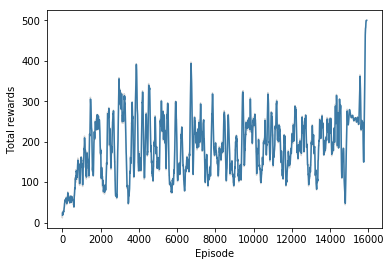

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

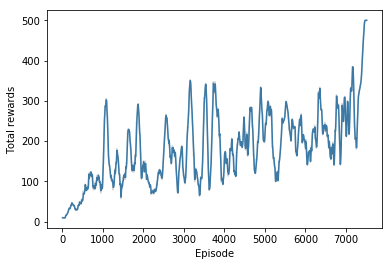

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

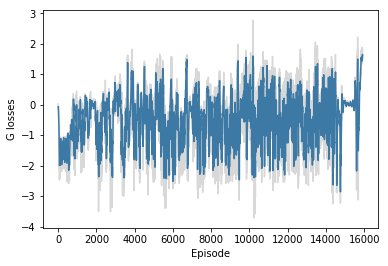

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

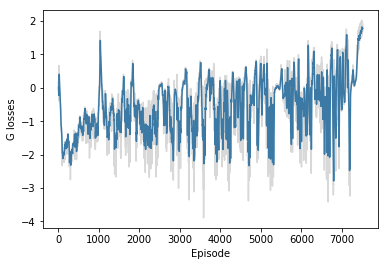

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

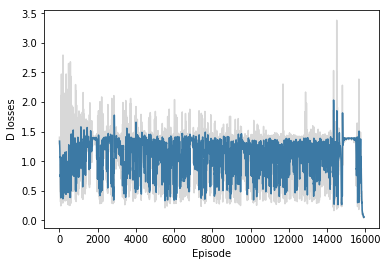

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

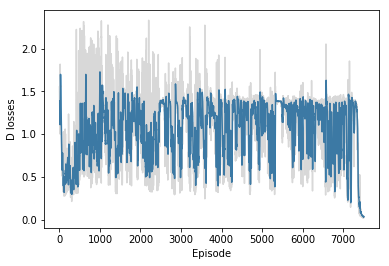

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

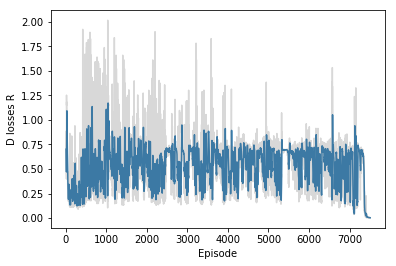

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

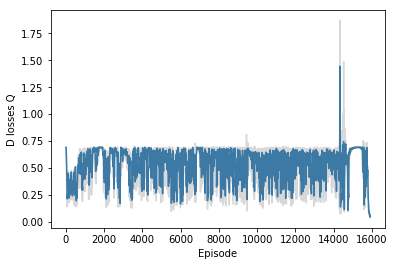

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

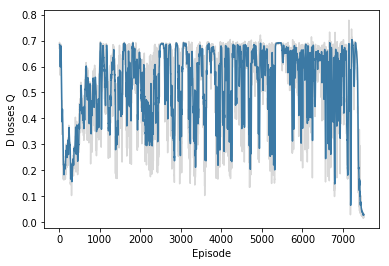

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.